# **Functions _ PR Model**


In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random as random
import matplotlib.animation as animation
import pandas as pd
from random import sample
from tensorflow.keras import Sequential
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Input, InputLayer, Add

from tensorflow.keras import backend as K
from tensorflow.keras import Model, regularizers, Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, Dense, Activation, Flatten, Reshape, MaxPool3D, MaxPool2D, Permute, BatchNormalization, GaussianNoise,DepthwiseConv2D, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l1, l2
import math
import sys



digit_max=10






#Dataset generating functions (Ines)


def generate_frames_dataset(digits_set, labels_set, n_digits=5, n_frames=1000,
                            upsample=True, frame_size=280,
                            downsample=False, pool_size=7, strides=7, final_size=4,
                            movie=False, duration=5,
                            perturbations = False, perturbations_time="random", perturbations_duration=2, half=False,
                            spot_proba = 1, spot_factor=100, shadow_factor=0.5,
                           digit_max = 10):

    """Generates a dataset of frames with n_digits, with variable frame_size, and possibilitiy to downsample, or movies (with identical frames) if movie=True. Adds light perturbations if perturbations=True, that can be 2 frames long homogenous or half frame light or shadow, at a specific time or random time.

    Args:
    digits_set: np.array of MNIST digits
    labels_set: np.array of int type corresponding to the labels
    n_digits: int
    n_frames: int
    upsample; bool, True or False
    frame_size: if upsample, size of the frame after the upsampling, before the downsampling
    downsample: bool, True or False
    pool_size: int, if downsample
    strides: int, if downsample
    final_size: int
    movie: bool, True or False
    duration: int, if movie
    perturbations: bool, whether to add spotlights and shadows
    perturbations_time: str or int, when to start the 2-frames long perturbations
    half: bool, whether to add the perturbations on only half of the frame (if False : homogeneous perturbation)
    spot_proba: float, between 0 and 1, probability that the perturbation is a spotlight (0.5 if you want equiprobable spotlights and shadows)
    spot_factor: float, by how much to multiply the light intensity
    shadow_factor: float, but how much to multiply the light intensity as well ( < 1 )
    digit_max: maximum of the classes labels, by default 10. Can be less, if you only want to work with some of the classes, and reduce the MNIST dataset you use.

    Returns:
    dataset: np.array of frames (n_frames, final_size, final_size) or movies (n_frames, final_size, final_size, duration)
    labels_set: np.array of set of digit_max frames, corresponding to the labels for each class (n_frames, final_size, final_size, digit_max+1)

    """


    digit_shape = np.shape(digits_set[0])

    digit_max = len(list(set(labels_set)))
    frames = []
    labels = []


    if upsample:

        for i in range(n_frames):

            frame = np.zeros((frame_size, frame_size), dtype="float32")
            label = [np.zeros((frame_size, frame_size), dtype="float32" ) for i in range(digit_max)]  #build empty frames and labels


            indexes = random.sample(range(len(digits_set)), n_digits)  #select the MNIST digits, and get the corresponding labels
            digits = digits_set[indexes]
            digits_labels = labels_set[indexes]

            positions = [random.sample(range(frame_size-digit_shape[0]-1),2) for i in range(n_digits)]  #choose the position of the digits
            background = np.ones((frame_size, frame_size), dtype="float32")

            if downsample :

                new_frame_size, new_digits, new_positions = little_downsample(frame_size, digits, positions, pool_size, strides)
                #computing the downsampled positions and digits
                frame, label = create_frame_and_labels(new_frame_size, new_digits, digits_labels, new_positions, digit_max)

            else:

                frame, label = create_frame_and_labels(frame_size, digits, digits_labels, positions, digit_max)

            if movie:

            	frame = [frame for i in range(duration)]  #making a movie out of identical frames

            	if perturbations:  #adding spotlights and shadows

            		frame = add_perturbations(frame, half, spot_proba, spot_factor, shadow_factor, perturbations_time, movie_duration, final_size)

            labels.append(label)
            frames.append(frame)

    else:  #if not upsampled

        for i in range(n_frames):

            n = random.randint(0,len(digits_set)-1)

            digit_label = labels_set[n]

            frame = digits_set[n]
            label = label_mnist(frame, digit_label, digit_max)


            if downsample:

                new_frame_size, new_digits, new_positions = little_downsample(frame_size, [frame], [[0,0]], pool_size, strides)
                frame, label = create_frame_and_labels(new_frame_size, new_digits, [digit_label], new_positions, digit_max)


            if movie:

            	frame = [frame for i in range(duration)]

            	if perturbations:

            		frame = add_perturbations(frame, half, spot_proba, spot_factor, shadow_factor, perturbations_time, perturbations_duration, duration)

            labels.append(label)
            frames.append(frame)

    dataset = np.array(frames)
    labels_set = np.array(labels)

    #getting the dimensions right for the model
    if not movie:
        dataset = dataset[:,:,:,None]
        labels_set = np.transpose(labels_set, (0,2,3,1))


    dataset = np.transpose(dataset, (0,2,3,1))
    labels_set = np.transpose(labels_set, (0,2,3,1))

    return dataset, labels_set













def generate_movie_dataset_5(digits_set, labels_set,
                            n_movies=1000, duration=5,
                            frame_size = 280, n_digits=5,
                            depth=2, level=1,
                            shadow = False, shadow_ratio = 0.2, light_intensity = 0.1,
                            max_jump=1, speed=1,
                            digit_max = 10
                            ):

    """Generates a dataset of movies with moving digits

    Args:
    digits_set: np.array of MNIST digits
    labels_set: np.array of the corresponding labels
    n_movies: int, number of movies
    duration: int, duration of the movie
    frame_size: int, size of the frame
    n_digits: int, numer of digits
    shadow: bool, True or False
    shadow_ratio: float, usually 1/10**n, shadow surface/total surface, defines the radius. Reasonable circle size with ratio=0.3
    light_intensity: float, usually 10**n, factor applied to pixels in the shadow

    Returns:
    movies: np.array of movies, shape (n_movies, frame_size, frame_size, duration)
    labels: np. array of frames labelling the last frame of each movie for each class

    """

    radius = int(frame_size*np.sqrt(shadow_ratio/np.pi))

    movies, labels = [], []

    label_size = frame_size/2**(depth-level-1)

    digit_size = len(digits_set[0][0])

    for n in range(n_movies):

        # select the digits

        indexes = random.sample(range(len(digits_set)), n_digits)

        digits = digits_set[indexes]
        digits_labels = labels_set[indexes]

        #Initial values for the positions and directions of the digits

        positions = [random.sample(range(speed*max_jump, frame_size-digit_size-speed*max_jump),2) for i in range(n_digits)]
        directions =  [non_null_sample(max_jump, 2) for i in range(n_digits)]

        #create the movie and the movie labels

        movie = []

        for time in range(duration):

            for k, digit in enumerate(digits):

                #Compute the new position

                position = new_position(positions[k], directions[k], speed)
                positions[k] = position

                #Compute the next position to check it's going to be fine

                next_position = new_position(positions[k], directions[k], speed)

                while out_of_frame(next_position, frame_size, digit_size):

                    #Correct the direction if next position is out of frame

                    rebound_point = closest_frontier(next_position, frame_size, digit_size)
                    directions[k] = mirror_direction(directions[k], rebound_point, frame_size)
                    next_position = new_position(positions[k], directions[k], speed)

                if in_the_center(positions[k], frame_size, speed, digit_size, max_jump):

                    #Randomly change the direction, if far enough from the walls
                    directions[k] = change_direction(directions[k], max_jump)

            #Create the frame with the positions of the digits
            frame = create_frame(frame_size, digits, positions)


            if shadow:
                frame = add_shadow(frame, radius, light_intensity)

            movie.append(frame)

            if time == duration-1 :

                    #only label the last time step

                    movie_labels = create_labels(frame_size, digits, digits_labels, positions, digit_max)

        movies.append(movie)
        labels.append(movie_labels)

    #Get the right shape for the model
    movies = np.transpose(movies, (0,2,3,1))
    labels = np.transpose(labels, (0,2,3,1))

    return np.array(movies), np.array(labels)









#Auxiliary functions for the generating functions (Ines)















def add_perturbations(frame, half, spot_proba, spot_factor, shadow_factor, perturbations_time, perturbations_duration, movie_duration):

	"""

	Adds light level variations to a frame movie. Either on all the frame, or only half, either spotlight or shadow or both with a probability.

	Args:
	frame: 28x28 np array
	half: boolean
	spot_proba: 0 if only shadows, 1 if only spotlights, 0.5 if randomly one or the other.
	spot_factor: factor to multiply the pixel values if spotlight, usually 10**n
	shadow_factor: factor to multiply pixel values if shadow, usually 1/10**n
	perturbations_time: "random" by default, or int, has to be <= movie_duration-perturbations_duration
	perturbations_duration: int, in number of frames
	movie_duration: int
	final_size: int, size of the frame

	Returns:
	frame: modified frame

	"""
	frame_size = len(frame)

	if perturbations_time=="random":

		start_time = random.randint(0,movie_duration-perturbations_duration)

	else:
		start_time = perturbations_time

	end_time = start_time + perturbations_duration -1

	random_nb = np.random.random() #to decide if spotlight or shadow


	if half:
		random_half = np.random.randint(0,2)

		if random_half==1: #low half perturbated

			new_frames = []
			for k in range(perturbations_duration):

				new_frame = np.vstack([frame[start_time+k][:int(frame_size/2)] * ( (random_nb < spot_proba)*spot_factor + (random_nb >= spot_proba)*shadow_factor ) , frame[start_time+k][int(frame_size/2):]])
				new_frames.append(new_frame)

		else: #top half perturbated

			new_frames = []
			for k in range(perturbations_duration):

				new_frame = np.vstack([frame[start_time+k][:int(frame_size/2)], frame[start_time+k][int(frame_size/2):] * ( (random_nb < spot_proba)*spot_factor + (random_nb >= spot_proba)*shadow_factor )])
				new_frames.append(new_frame)


	else:  #homogeneous perturbation

		new_frames = []
		for k in range(perturbations_duration):

			new_frame = frame[start_time+k] * ( (random_nb < spot_proba)*spot_factor + (random_nb >= spot_proba)*shadow_factor )
			new_frames.append(new_frame)

	for k in range(perturbations_duration):

		frame[start_time+k] = new_frames[k]

	return frame













def add_shadow(frame, radius, intensity):

    """Adds a shadow on a frame.

    Args:
    frame: np.array
    radius: float
    intensity: factor applied to the pixels in the shadow

    Returns:
    shad_frame: np.array of the frame with the shadow

    """

    frame_size = len(frame)
    shad_frame = frame.copy()

    for i,line in enumerate(frame):
        for j,pixel in enumerate(line):

            x,y  = i - frame_size/2, j - frame_size/2

            if np.sqrt(x**2 + y**2) <= radius :
                shad_frame[i,j] = intensity*frame[i,j]

    return shad_frame
















def create_labels(frame_size, digits, digits_labels, positions, digit_max):


    """Create the labels corresponding to a frame.

    Args:
    frame_size: float
    digits: MNIST digits present on the frame
    digits_labels: labels of the digits
    positions: 2-uple (x,y) for each digit
    digit_max: 10

    Returns:
    labels:frames corresponding to each class

    """

    labels = np.array([np.zeros((frame_size, frame_size)) for i in range(digit_max)]+ [np.ones((frame_size, frame_size))])

    for k, digit in enumerate(digits):


        frame = labels[digits_labels[k]]



        label_k = insert(digit, frame, positions[k])


        labels[digits_labels[k]] = label_k


        labels[-1] = np.maximum(labels[-1]-labels[digits_labels[k]], 0)

    return labels

















def label_mnist(digit_frame, digit, digit_max=10):


	"""

	Creates the labels frames corresponding to an MNIST digit

	Args:
	digit_frame: 28x28 np array, MNIST digit directly
	digit: int, MNIST label
	digit_max: int, default to 10

	Returns:
	labels: digit_max+1 frames, shape (digit_max+1, 28,28), with zeros on every frame but the digit frame, where the non zero MNIST pixels are =1.

	"""

	labels = [np.zeros(np.shape(digit_frame), dtype="float32") for i in range(digit_max+1)]

	label = np.zeros(np.shape(digit_frame), dtype="float32")
	for i in range(len(digit_frame)):
		for j in range(len(digit_frame[i])):
	    		if digit_frame[i][j] != 0:
	    			label[i][j] = 1

	labels[digit] = label
	labels[-1] = 1-label

	return labels















def insert(digit, frame, position):

    """

    Adds a digit in the frame. If there is already a digit, it has priority (the other is "hidden" behind)

    Args:
    digit: 28x28 array
    frame: array
    position: x,y for the digit's top left corner

    Outputs:
    frame: array

    """

    max_value = np.max(digit)
    for i, line in enumerate(digit):

        for j, pixel in enumerate(line):

            frame_value = frame[position[0]+i, position[1]+j]

            if frame_value == 0 :
                frame[position[0]+i, position[1]+j] = pixel

            #else : already a prioritary digit here


    return frame















def create_frame_and_labels(frame_size, digits, digits_labels, positions, digit_max):

    """Create a frame and the corresponding labels.

    Args:
    frame_size: int
    digits: np.array of MNIST digits to put on the frame
    digits_labels: np.array of int labels corresponding to the digits
    positions: 2-uple (x,y) for each digit
    digit_max: 10

    Returns:
    frame: the created frame
    labels: the associated label frames for each class

    """

    frame = np.zeros((frame_size, frame_size))
    background = np.ones((frame_size, frame_size))
    labels = [np.zeros((frame_size, frame_size)) for i in range(digit_max)]

    for k, digit in enumerate(digits):

        digit_label = digits_labels[k]
        position = positions[k]

        frame, labels[int(digit_label)], background = insert_and_label(digit, digit_label, frame, labels[int(digit_label)], position, background)

    labels.append(background)

    return np.array(frame), np.array(labels)

















def insert_and_label(digit, digit_label, frame, proba, position, background):

    """

    Adds a digit to a frame and to the corresponding labels

    Args:
    digit: MNIST digit
    digit_label: int
    frame: frame to insert the digit in
    proba: label drame corresponding to the digit
    position: (x,y) digit position
    background: background frame in the labels

    Returns:
    frame: modified frame
    new_proba: modified label frame
    background: modified background frame

    """


    new_proba = proba.copy()
    max_value = np.max(digit)

    for i, line in enumerate(digit):
        for j, pixel in enumerate(line):

            frame_value = frame[position[0]+i, position[1]+j]

            if frame_value == 0:
                frame[position[0]+i, position[1]+j] = pixel

            #else : already a digit there, priority to the first arrived

            if pixel != 0:

                new_proba[position[0]+i][position[1]+j] = 1
                background[position[0]+i][position[1]+j] = 0
                #where a non-zero digit pixel is inserted, a one is inserted in the same position of the corresponding matrix



    return frame, new_proba, background

















def downsample_digit(digits_list,
                     pool_size, strides
                    ):

    """

    Downsamples digits

    Args:
    digits_list: list of MNIST digits
    pool_size: int, for the downsampling
    strides: int, for the downsampling

    Returns:
    down_digits: list of downsampled digits
    new_digit_size: int

    """

    down_digits = []

    digit_size = len(digits_list[0][0])


    for digit in digits_list :


        down_digit = []
        line = 0

        while line < len(digit[0])-pool_size+1 :
            new_line = []
            column = 0
            while column < len(digit[0])-pool_size+1 :

                new_line.append(np.max( digit[line:line+pool_size, column:column+pool_size]))
                column += strides

            line += strides
            down_digit.append(new_line)

        down_digit= np.array(down_digit)


        down_digits.append(down_digit)
        new_digit_size = len(down_digits[0])

    return down_digits, new_digit_size












def little_downsample(frame_size, digits, positions, pool_size, strides):

    """Computes the new frame size, the new MNIST digits and their new positions after the downsampling.
    Allows to create the downsampled frame rather then downsampling a frame, faster.

    Args:
    frame_size; int, before downsampling
    digits: MNIST digits
    positions: 2-uple (x,y) for each digit
    pool_size: int
    strides: int

    Returns:
    down_frame_size: int, new frame size
    down_digits: np.array of new digits
    down_positions: 2-uple of new (x,y) position for each digit

    """

    digit_size = len(digits[0][0])

    down_frame_size = (frame_size-pool_size)/strides +1
    down_positions = []
    down_digits = []

    for position in positions:
        x,y = position
        down_x, down_y = x//strides, y//strides
        down_positions.append([down_x,down_y])


    down_digits, digit_size = downsample_digit(digits, pool_size, strides)


    return int(down_frame_size), down_digits, down_positions
















def create_frame(frame_size, digits, positions):

    """

    Creates the frame zith all the digits.

    Args:
    frame_size: for a square frame
    digits: list of 28x28 arrays
    positions: list of x,y corresponding to the digits' top left corners, in the same order

    Outputs:
    frame: 280x280 array

    """

    frame = np.zeros((frame_size, frame_size))
    for k, digit in enumerate(digits):
        position = positions[k]
        frame = insert(digit, frame, position)
    return frame

















def mirror_direction(direction, position, frame_size):

    """

    Finds the new direction when a digit rebounds on a wall.

    Args:
    direction: current direction of the digit [dx,dy]
    position: current position of the digit [x,y]
    frame_size: for a square frame

    Outputs:
    direction: [dx,dy]

    """

    dx, dy = direction
    x,y = position
    if (x==0 or x==frame_size-1) and y!=0 and y!=frame_size-1:
        dx = -dx
    if (y==0 or y==frame_size-1) and x!=0 and x!=frame_size-1:
        dy = -dy
    if (x==0 or x==frame_size-1) and (y==0 or y==frame_size-1):
        dx, dy = -dx, -dy
    return [dx, dy]


















def change_direction(direction, max_jump):

    """

    Generates a slight change in direction, called with a small probability.

    Args:
    direction: current direction [dx,dy]
    max_jump: initially defined constant

    Outputs:
    direction: new direction[dx,dy]

    """

    random_nb = random.random()
    if random_nb < 0.05:
        direction[0] = min(max_jump, max(-max_jump,direction[0]+1))
        # to check that still between -max_jump and max_jump
    elif random_nb >= 0.05 and random_nb < 0.1 :
        direction[0] = min(max_jump, max(-max_jump,direction[0]-1))
    if random_nb >= 0.1 and random_nb < 0.15:
        direction[1] = min(max_jump, max(-max_jump,direction[1]+1))
    elif random_nb >= 0.15 and random_nb < 0.2 :
        direction[1] = min(max_jump, max(-max_jump,direction[1]-1))
    return direction



















def closest_frontier(position, frame_size, digit_size):

	"""

	Finds the closest point on the walls to a digit

	Args:
	position: (x,y) position of the top left corner of the digit
	frame_size: int
	digit_size: int

	Returns:
	(x,y) position of the closest point on a wall

	"""

	x,y = position
	neighbor_frontiers = [(frame_size-1,y), (0,y), (x, frame_size-1), (x,0)]
	distances = []
	distances.append(frame_size - (x+digit_size))
	distances.append(x)
	distances.append(frame_size - (y+digit_size))
	distances.append(y)
	return neighbor_frontiers[distances.index(min(distances))]



















def non_null_sample(max_value, number):

	"""

	Selects a number-uple of values different from (0,...,0) for the directions, usually (dx,dy) because 2D

	Args:
	max_value: int, max value to choose
	number: number of numbers to pick

	Returns:
	number-uple of values not all zero, usually (dx,dy)

	"""

	values = list(np.arange(-max_value, max_value+1))
	sample = []
	for i in range(number-1):
		sample.append(random.choice(values))
	#for the last value, we cannot add a zero if there are only zero in the selected values
	if list(set(sample)) != [0]:
		sample.append(random.choice(values))
	else:
		values.remove(0)
		sample.append(random.choice(values))
	return sample

















def new_position(position, direction, speed):

	"""

	Computes the new position from current position, direction and speed

	Args:
	position: (x,y) int
	direction: (dx, dy) int
	speed: int

	Returns:
	(x,y) new position : x += speed*dx

	"""

	x,y = position
	dx, dy = direction
	return [x+speed*dx, y+speed*dy]

















def out_of_frame(position, frame_size, digit_size):

	"""

	Checks whether a position would go out of the frame

	Args:
	position: (x,y) int
	frame_size: int
	digit_size: int

	Returns:
	bool: True if out of frame

	"""
	for i, dimension in enumerate(position) :

		if dimension + digit_size  > frame_size:
			return True
		if dimension < 0:
			return True
	return False


















def in_the_center(position, frame_size, speed, digit_size, max_jump):
	"""

	Checks whether a digit is far enough from the walls (to randomly change direction without danger)

	Args:
	position: (x,y) int
	frame_size: int
	speed: int
	digit_size: int
	max_jump: int

	Returns:
	bool: True if far enough from the walls

	"""

	security_distance = abs(speed*max_jump)+ digit_size
	for dimension in position :
		if abs(frame_size-dimension)<security_distance or dimension < security_distance:
	    		return False
	return True


















def save_movie(movie, title, directory, time_interval=70):


    """
    Saves a movie in a directory in GIF format

    Args:
    movie: np.array of dimension (n_frames, frame_size, frame_size)
    title: string
    directory: str of shape "folder1/folder2/"
    time_interval: int, between two frames. 50 is fast, 150 is slow

    Returns:
    nothing, the movie is saved.

    """

    fig, ax  = plt.subplots()
    ims = []
    for i, image in enumerate(movie):
        im = ax.imshow((image), animated=True)
        if i == 0:
            ax.imshow(image)
        ims.append([im])

    gif = animation.ArtistAnimation(fig, ims, interval=time_interval, blit=True,
                                repeat_delay=1000)
    gif.save(directory+title+".gif")









#Custom metrics (Ines)














@tf.function(experimental_relax_shapes=True)
def new_weighted_loss_0(y_true, y_pred):

    """
    Counts the number of zeros and ones pixels on the labels, then applies the weights on all the frames based on the background to balance the digits and background classes (because a lot more zeros). Then computes the weighted cross-entropy loss (- mean of true_labels * weights * log(predictions) )

    Args:
    y_true: true labels
    y_pred: predictions

    Returns:
    Cross-entropy loss

    """

    background = y_true[:, :,-1]
    w1 = tf.reduce_sum(background)/tf.cast(tf.size(background), tf.float32)
    w2 = 1-w1
    w = background*w2 + (1-background)*w1

    #loss = tf.reduce_mean(w[:, :, None]*tf.square(tf.subtract(y_true, y_pred)))
    #to broadcast (over channels)
    #tf.print(tf.math.log(y_pred))

    y_pred = tf.clip_by_value(y_pred, 0.0001, 0.9999)
    term = w[:,:, None]* (y_true)* tf.math.log(y_pred)
    loss =tf.reduce_mean(term)
    #tf.print(loss)

    return tf.math.abs(loss)













@tf.function
def new_weighted_loss(y_true, y_pred):

    """
    Counts the number of zeros and ones pixels on the labels, then applies the weights on each frame separately to balance the zeros and ones classes (because a lot more zeros). Then computes the weighted cross-entropy loss (- mean of true_labels * weights * log(predictions) )

    Args:
    y_true: true labels
    y_pred: predictions

    Returns:
    Cross-entropy loss

    """

    w1 = tf.reduce_sum(y_true)/tf.cast(tf.size(y_true), tf.float32)  #proportion of ones pixels
    w2 = 1-w1   #proportion of zeros pixels

    N = len(y_true[0,0,0])  # number of classes
    weights = tf.TensorArray(tf.float32, size=N)

    #now we build the weights matrix

    for i in range(N):

    	frame = y_true[:,:,:,i]
    	weights_frame = frame*w2 + (1-frame)*w1   #ones pixels get the zeros pixels proportion as their weight, for each frame

    	weights = weights.write(i, weights_frame)

    weights = tf.transpose(weights.stack(), (1, 2, 3, 0))

    y_pred = tf.clip_by_value(y_pred, 0.0001, 0.9999)
    #to avoid log(0) that was causing an error
    term = weights * (y_true)* tf.math.log(y_pred)
    loss = - tf.reduce_mean(term)

    return loss















@tf.function(experimental_relax_shapes=True)
def my_accuracy(y_true, y_pred):

	"""
	Computes the mean of exp(-abs(relative_error)), only taking into account digit pixels, and not the background. Idea: to get a better range of the accuracy values, we could add a multiplying factor inside the exp.

	Args:
	y_true: true labels
	y_pred: predictions

	Returns:
	non-categorical accuracy

	"""

	y_true_digits = y_true[:,:,:,:-1]
	y_pred_digits = y_pred[:,:,:,:-1]
	background = y_true[:,:,:,:-1]
	n_classes = y_true.get_shape()[-1]-1

	#What I used in my runs
	similarity = tf.math.exp(- tf.math.abs( y_pred_digits - y_true_digits) )

	#What I realized on the presentation day would have been better
	#1. Using the relative error
	#2. Using a factor to decide how low the accuracy can go (right now, betwen 0.9 and 1...)
	#similarity = tf.math.exp(- tf.math.abs( factor * (y_pred_digits - y_true_digits)/y_true_digits )



	digit_index = tf.math.argmax(tf.math.reduce_max(y_true[:,:,:,:-1], axis=(0,1,2)))
	digit_frame = y_true_digits[:,:,:,digit_index]

	weighted_similarity = digit_frame[:,:,:,None] * similarity



	my_accuracy = tf.cast(tf.reduce_sum( weighted_similarity ), tf.float32) / tf.cast(tf.math.count_nonzero(digit_frame) * n_classes, tf.float32)

	return my_accuracy













@tf.function(experimental_relax_shapes=True)
def my_cat_accuracy(y_true, y_pred):

	"""
	Computes the frequency of good predictions, choosing the maximum probability over the classes, only taking into account digit pixels, and not the background.

	Args:
	y_true: true labels
	y_pred: predictions

	Returns:
	categorical accuracy

	"""

	background = y_true[:,:,:,-1]

	#we "force the network to choose" by taking the maximum over the classes
	indexes_true = tf.math.argmax(y_true,axis=3)
	indexes_pred = tf.math.argmax(y_pred,axis=3)

	#the "indexes" are just one frame wih values between 0 and 10, indicating the class with the maximum probability for each pixel

	#find where the digit actually is
	digit_index = tf.math.argmax(tf.math.reduce_max(y_true[:,:,:,:-1], axis=(0,1,2)))

	#the reduce_max is list of n_classes element, excluding the background. the max is the frame with the actual digit (the others are only zeros)

	#we count the pixels where the predicted class is correct, and is the digit (not background)
	acc = tf.math.reduce_sum(tf.cast((indexes_true == indexes_pred) & (indexes_true==digit_index), tf.float32)) / tf.cast(tf.math.count_nonzero(1-background), tf.float32)

	return acc









#Code for the photoreceptor model (Saad)


def conv_oper_multichan(x,kernel_1D):

    spatial_dims = x.shape[-1]
    x_reshaped = tf.expand_dims(x,axis=2)
    kernel_1D = tf.squeeze(kernel_1D,axis=0)
    kernel_1D = tf.reverse(kernel_1D,[0])
    tile_fac = tf.constant([spatial_dims,1])
    kernel_reshaped = tf.tile(kernel_1D,(tile_fac))
    kernel_reshaped = tf.reshape(kernel_reshaped,(1,spatial_dims,kernel_1D.shape[0],kernel_1D.shape[-1]))

#**** color image ?
    # kernel_reshaped = tf.reshape(kernel_reshaped,(1,spatial_dims,kernel_1D.shape[0],kernel_1D.shape[-1],3))

    kernel_reshaped = tf.experimental.numpy.moveaxis(kernel_reshaped,-2,0)

    pad_vec = [[0,0],[kernel_1D.shape[0]-1,0],[0,0],[0,0]]
    # # pad_vec = [[0,0],[0,0],[0,0],[0,0]]

    # conv_output = tf.nn.conv2d(x_reshaped,kernel_reshaped,strides=[1,1,1,1],padding=pad_vec,data_format='NHWC')
    conv_output = tf.nn.depthwise_conv2d(x_reshaped,kernel_reshaped,strides=[1,1,1,1],padding=pad_vec,data_format='NHWC')

    # print(conv_output.shape)
    return conv_output




@tf.function()#experimental_relax_shapes=True)
def slice_tensor(inp_tensor,shift_vals):
    # print(inp_tensor.shape)
    # print(shift_vals.shape)
    shift_vals = shift_vals[:,tf.newaxis,:]
    shift_vals = tf.tile(shift_vals,[1,inp_tensor.shape[-2],1])
    tens_reshape = tf.reshape(inp_tensor,[-1,inp_tensor.shape[1]*inp_tensor.shape[2]*inp_tensor.shape[3]*inp_tensor.shape[4]])
    # print('tens_reshape: ',tens_reshape.shape)
    shift_vals_new = (inp_tensor.shape[1]-shift_vals[0])*(inp_tensor.shape[-1]*inp_tensor.shape[-2])
    rgb = tf.range(0,shift_vals_new.shape[-1])
    rgb = rgb[tf.newaxis,:]
    rgb = tf.tile(rgb,[shift_vals_new.shape[0],1])
    temp = tf.range(0,shift_vals_new.shape[-1]*shift_vals_new.shape[-2],shift_vals_new.shape[-1])
    rgb = rgb+temp[:,None]
    shift_vals_new = shift_vals_new + rgb
    extracted_vals = tf.gather(tens_reshape,shift_vals_new,axis=1)
    # print('extracted_vals: ',shift_vals.shape)
    extracted_vals_reshaped = tf.reshape(extracted_vals,(-1,1,inp_tensor.shape[2],inp_tensor.shape[3],inp_tensor.shape[4]))

    return extracted_vals_reshaped





def generate_simple_filter_multichan(tau,n,t):
    t_shape = t.shape[0]
    t = tf.tile(t,tf.constant([tau.shape[-1]], tf.int32))
    t = tf.reshape(t,(tau.shape[-1],t_shape))
    t = tf.transpose(t)
    f = (t**n[:,None])*tf.math.exp(-t/tau[:,None]) # functional form in paper
    rgb = tau**(n+1)
    f = (f/rgb[:,None])/tf.math.exp(tf.math.lgamma(n+1))[:,None] # normalize appropriately
    # print(t.shape)
    # print(n.shape)
    # print(tau.shape)

    return f

# class photoreceptor_DA_multichan_randinit(tf.keras.layers.Layer):
#     def __init__(self,units=1,kernel_regularizer=None):
#         super(photoreceptor_DA_multichan_randinit,self).__init__()
#         self.units = units
#         self.kernel_regularizer = regularizers.get(kernel_regularizer)



class photoreceptor_DA_multichan_randinit(tf.keras.layers.Layer):
    def __init__(self, units=1, kernel_regularizer=None, **kwargs):
        super(photoreceptor_DA_multichan_randinit, self).__init__(**kwargs)
        self.units = units
        self.kernel_regularizer = regularizers.get(kernel_regularizer)

    def get_config(self):
         config = super().get_config()
         config.update({
             "units": self.units,
             "kernel_regularizer": self.kernel_regularizer
         })
         return config

    def build(self,input_shape):    # random inits


        # # # # Constant Values
        # zeta_init = tf.keras.initializers.Constant(0.2)
        # self.zeta = self.add_weight(name='zeta',initializer=zeta_init,shape=[1,self.units],trainable=False)
        # zeta_mulFac = tf.keras.initializers.Constant(1000.)
        # self.zeta_mulFac = self.add_weight(name='zeta_mulFac',initializer=zeta_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for kappa
        # kappa_init = tf.keras.initializers.Constant(0.13)
        # self.kappa = self.add_weight(name='kappa',initializer=kappa_init,shape=[1,self.units],trainable=False)
        # kappa_mulFac = tf.keras.initializers.Constant(1000.)
        # self.kappa_mulFac = self.add_weight(name='kappa_mulFac',initializer=kappa_mulFac,shape=[1,self.units],trainable=False)

        # # # # you can have a constant value for alpha
        # alpha_init = tf.keras.initializers.Constant(0.0667)
        # self.alpha = self.add_weight(name='alpha',initializer=alpha_init,shape=[1,self.units],trainable=False)
        # alpha_mulFac = tf.keras.initializers.Constant(1000.)
        # self.alpha_mulFac = self.add_weight(name='alpha_mulFac',initializer=alpha_mulFac,shape=[1,self.units],trainable=False)

        # # # # you can have a constant value for beta
        # beta_init = tf.keras.initializers.Constant(0)
        # self.beta = self.add_weight(name='beta',initializer=beta_init,shape=[1,self.units],trainable=False)
        # beta_mulFac = tf.keras.initializers.Constant(1000.)
        # self.beta_mulFac = self.add_weight(name='beta_mulFac',initializer=beta_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for gamma
        # gamma_init = tf.keras.initializers.Constant(0.1)
        # self.gamma = self.add_weight(name='gamma',initializer=gamma_init,shape=[1,self.units],trainable=False)
        # gamma_mulFac = tf.keras.initializers.Constant(10.)
        # self.gamma_mulFac = self.add_weight(name='gamma_mulFac',initializer=gamma_mulFac,shape=[1,self.units],trainable=False)


        # # # you can have a costant value constant value for tauY
        # tauY_init = tf.keras.initializers.Constant(0.06)
        # self.tauY = self.add_weight(name='tauY',initializer=tauY_init,shape=[1,self.units],trainable=False)
        # tauY_mulFac = tf.keras.initializers.Constant(10.)
        # self.tauY_mulFac = self.add_weight(name='tauY_mulFac',initializer=tauY_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for nY
        # nY_init = tf.keras.initializers.Constant(0.1)
        # self.nY = self.add_weight(name='nY',initializer=nY_init,shape=[1,self.units],trainable=False)
        # nY_mulFac = tf.keras.initializers.Constant(10.)
        # self.nY_mulFac = self.add_weight(name='nY_mulFac',initializer=nY_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for tauz
        # tauZ_init = tf.keras.initializers.Constant(0.09)
        # self.tauZ = self.add_weight(name='tauZ',initializer=tauZ_init,shape=[1,self.units],trainable=False)
        # tauZ_mulFac = tf.keras.initializers.Constant(100.)
        # self.tauZ_mulFac = self.add_weight(name='tauZ_mulFac',initializer=tauZ_mulFac,shape=[1,self.units],trainable=False)

        # # # you can have a costant value constant value for nz
        # nZ_init = tf.keras.initializers.Constant(0.09)
        # self.nZ = self.add_weight(name='nZ',initializer=nZ_init,shape=[1,self.units],trainable=False)
        # nZ_mulFac = tf.keras.initializers.Constant(10.)
        # self.nZ_mulFac = self.add_weight(name='nZ_mulFac',initializer=nZ_mulFac,shape=[1,self.units],trainable=False)




# Range of values for each parameter



##

        # zeta_range = (0.04197,0.041970000001)
        zeta_range = (0,1)
        # zeta_range = (.02602935,.02602935000001)
        # zeta_range = (.02,.02000001)
        zeta_init = tf.keras.initializers.RandomUniform(minval=zeta_range[0],maxval=zeta_range[1]) #tf.keras.initializers.Constant(0.0159)
        self.zeta = self.add_weight(name='zeta',initializer=zeta_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        zeta_mulFac = tf.keras.initializers.Constant(1000.)
        self.zeta_mulFac = self.add_weight(name='zeta_mulFac',initializer=zeta_mulFac,shape=[1,self.units],trainable=False)



        # # you can have a range for kappa
        # kappa_range = (0.04294,0.042940000001)
        kappa_range = (0,1)
        # kappa_range = (0.05,0.0500001)
        # kappa_range = (0.049,0.049000001)
        kappa_init = tf.keras.initializers.RandomUniform(minval=kappa_range[0],maxval=kappa_range[1]) #tf.keras.initializers.Constant(0.0159)
        self.kappa = self.add_weight(name='kappa',initializer=kappa_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        kappa_mulFac = tf.keras.initializers.Constant(1000.)
        self.kappa_mulFac = self.add_weight(name='kappa_mulFac',initializer=kappa_mulFac,shape=[1,self.units],trainable=False)



        # # you can have a range for alpha
        #alpha_range = (0.04988,0.049880000001)
        alpha_range = (0,1)
        # alpha_range = (0.03487017,0.0348701700001)
        # alpha_range = (0.05,0.05000001)
        alpha_init = tf.keras.initializers.RandomUniform(minval=alpha_range[0],maxval=alpha_range[1]) #tf.keras.initializers.Constant(0.0159)
        self.alpha = self.add_weight(name='alpha',initializer=alpha_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        alpha_mulFac = tf.keras.initializers.Constant(100.)
        self.alpha_mulFac = self.add_weight(name='alpha_mulFac',initializer=alpha_mulFac,shape=[1,self.units],trainable=False)



        # # you can have a range for beta
        #beta_range = (0.04965,0.049650000001)
        beta_range = (0,1)
        # beta_range = (0.02,0.02000001)
        # beta_range = (0.04995,0.04995000001)
        beta_init = tf.keras.initializers.RandomUniform(minval=beta_range[0],maxval=beta_range[1])  #tf.keras.initializers.Constant(0.02)#
        self.beta = self.add_weight(name='beta',initializer=beta_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        beta_mulFac = tf.keras.initializers.Constant(10.)
        self.beta_mulFac = self.add_weight(name='beta_mulFac',initializer=beta_mulFac,shape=[1,self.units],trainable=False)



        # # you can have a range for gamma
        # gamma_range = (0.04986,0.04986000001)
        gamma_range = (0,1)
        # gamma_range = (0.02,0.02000001)
        gamma_init = tf.keras.initializers.RandomUniform(minval=gamma_range[0],maxval=gamma_range[1])  #tf.keras.initializers.Constant(0.075)#
        self.gamma = self.add_weight(name='gamma',initializer=gamma_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        gamma_mulFac = tf.keras.initializers.Constant(10.)
        self.gamma_mulFac = self.add_weight(name='gamma_mulFac',initializer=gamma_mulFac,shape=[1,self.units],trainable=False)


        #You can have a rannge for tauy, multiplication factor is 1000 from frame 1 to frame 20
        # tauY_range = (0.02222,0.02222000001)
        tauY_range = (0,1)
        # tauY_range = (0.02,0.0200001)
        # tauY_range = (0.04997,0.04997000001)
        tauY_init = tf.keras.initializers.RandomUniform(minval=tauY_range[0],maxval=tauY_range[1])  #tf.keras.initializers.Constant(0.01)#
        self.tauY = self.add_weight(name='tauY',initializer=tauY_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        tauY_mulFac = tf.keras.initializers.Constant(100.) #tf.keras.initializers.Constant(100.)
        self.tauY_mulFac = tf.Variable(name='tauY_mulFac',initial_value=tauY_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)


        # you can have a range for nY
        # nY_range = (0.02,0.02000001)
        nY_range = (0,1)
        # nY_range = (0.02,0.0200001)
        # nY_range = (0.02,0.02000001)
        nY_init = tf.keras.initializers.RandomUniform(minval=nY_range[0],maxval=nY_range[1]) #tf.keras.initializers.Constant(0.01)#
        self.nY = self.add_weight(name='nY',initializer=nY_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        nY_mulFac = tf.keras.initializers.Constant(10.)
        self.nY_mulFac = tf.Variable(name='nY_mulFac',initial_value=nY_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)


        # you can have a range for tauz , multiplication factor is 100 from frame 2 to frame 20
        # tauZ_range = (0.02262,0.02262000001)
        tauZ_range = (0,1)
        # tauZ_range = (0.05,0.0500001)
        # tauZ_range = (0.0208,0.0208000001)
        tauZ_init = tf.keras.initializers.RandomUniform(minval=tauZ_range[0],maxval=tauZ_range[1]) #tf.keras.initializers.Constant(0.5)#
        self.tauZ = self.add_weight(name='tauZ',initializer=tauZ_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        tauZ_mulFac = tf.keras.initializers.Constant(100.)
        self.tauZ_mulFac = tf.Variable(name='tauZ_mulFac',initial_value=tauZ_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)


        # you can have a range for nz
        # nZ_range = (0.03513,0.03513000001)
        nZ_range = (0,1)
        # nZ_range = (0.04983,0.04983000001)
        nZ_init = tf.keras.initializers.RandomUniform(minval=nZ_range[0],maxval=nZ_range[1])  #tf.keras.initializers.Constant(0.01)#
        self.nZ = self.add_weight(name='nZ',initializer=nZ_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        nZ_mulFac = tf.keras.initializers.Constant(10.)
        self.nZ_mulFac = tf.Variable(name='nZ_mulFac',initial_value=nZ_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)





# remove kc
        # multiplication factor is 100 from frame 1 to frame 20
        tauC_range = (0.02,0.05)
        tauC_init = tf.keras.initializers.RandomUniform(minval=tauC_range[0],maxval=tauC_range[1])  #tf.keras.initializers.Constant(0.2)#
        self.tauC = self.add_weight(name='tauC',initializer=tauC_init,shape=[1,self.units],trainable=True,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,tauC_range[0],tauC_range[1]))
        tauC_mulFac = tf.keras.initializers.Constant(100.)
        self.tauC_mulFac = tf.Variable(name='tauC_mulFac',initial_value=tauC_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)

        nC_range = (1e-5,0.2)
        nC_init = tf.keras.initializers.RandomUniform(minval=nC_range[0],maxval=nC_range[1])
        self.nC = self.add_weight(name='nC',initializer=nC_init,shape=[1,self.units],trainable=False,regularizer=self.kernel_regularizer,constraint=lambda x: tf.clip_by_value(x,nC_range[0],nC_range[1]))
        nC_mulFac = tf.keras.initializers.Constant(10.)
        self.nC_mulFac = tf.Variable(name='nC_mulFac',initial_value=nC_mulFac(shape=(1,self.units),dtype='float32'),trainable=False)

    def call(self,inputs):

        timeBin = 1

        alpha =  self.alpha*self.alpha_mulFac
        beta = self.beta*self.beta_mulFac
        gamma =  self.gamma*self.gamma_mulFac
        zeta = self.zeta*self.zeta_mulFac
        kappa = self.kappa*self.kappa_mulFac
        tau_y =  (self.tauY_mulFac*self.tauY) / timeBin
        tau_z =  (self.tauZ_mulFac*self.tauZ) / timeBin
        tau_c =  (self.tauC_mulFac*self.tauC) / timeBin
        n_y =  (self.nY_mulFac*self.nY)
        n_z =  (self.nZ_mulFac*self.nZ)
        n_c =  (self.nC_mulFac*self.nC)
       # print('tau_z: ',tau_y.shape)

        t = tf.range(0,inputs.shape[1],dtype='float32')

        Ky = generate_simple_filter_multichan(tau_y,n_y,t)
        Kc = generate_simple_filter_multichan(tau_c,n_c,t)
        Kz = generate_simple_filter_multichan(tau_z,n_z,t)

#****** # To simplify the model, kc was removed

        # Kz = (gamma*Kc) + ((1-gamma) * Kz)
        # replace kc by ky
        Kz = (gamma*Ky) + ((1-gamma) * Kz)
        # print('Kz: ',Kz.shape)

        # Kz = Kz[None,0,:]
        # print('Kz_new',Kz.shape)

        # print('inputs: ',inputs.shape)
        y_tf = conv_oper_multichan(inputs,Ky)
        z_tf = conv_oper_multichan(inputs,Kz)
        # print('z_tf: ',z_tf.shape)

        y_tf_reshape = tf.reshape(y_tf,(-1,y_tf.shape[1],y_tf.shape[2],inputs.shape[-1],tau_z.shape[-1]))
        z_tf_reshape = tf.reshape(z_tf,(-1,z_tf.shape[1],z_tf.shape[2],inputs.shape[-1],tau_z.shape[-1]))
        # print('z_tf_reshape: ',z_tf_reshape.shape)

#***** For Colour image, theshape of the PR was modifie

        # y_tf_reshape = tf.reshape(y_tf,(-1,y_tf.shape[1],y_tf.shape[2],3,tau_z.shape[-1]))
        # z_tf_reshape = tf.reshape(z_tf,(-1,z_tf.shape[1],z_tf.shape[2],3,tau_z.shape[-1]))





#*******## For time distributed, remove these four lines:

        # y_shift = tf.math.argmax(Ky,axis=1);y_shift = tf.cast(y_shift,tf.int32)
        # z_shift = tf.math.argmax(Kz,axis=1);z_shift = tf.cast(z_shift,tf.int32)

        # y_tf_reshape = slice_tensor(y_tf_reshape,y_shift)
        # z_tf_reshape = slice_tensor(z_tf_reshape,z_shift)
        # print('z_tf_slice: ',z_tf_reshape.shape)



    # the output shape
        outputs = (zeta[None,None,0,None,:] + (alpha[None,None,0,None,:]*y_tf_reshape[:,:,0,:,:]))/(kappa[None,None,0,None,:]+1e-6+(beta[None,None,0,None,:]*z_tf_reshape[:,:,0,:,:]))



        # If you want to further simplify the model, set kappa=1, and zeta=0
        # outputs = (0 + (alpha[None,None,0,None,:]*y_tf_reshape[:,:,0,:,:]))/(1+1e-6+(beta[None,None,0,None,:]*z_tf_reshape[:,:,0,:,:]))

        # print(outputs.shape)

        return outputs




class Normalize_multichan(tf.keras.layers.Layer):
    """
    BatchNorm is where you calculate normalization factors for each dimension seperately based on
    the batch data
    LayerNorm is where you calculate the normalization factors based on channels and dimensions
    Normalize_multichan calculates normalization factors based on all dimensions for each channel seperately
    """

    def __init__(self,units=1):
        super(Normalize_multichan,self).__init__()
        self.units = units

    def get_config(self):
         config = super().get_config()
         config.update({
             "units": self.units,
         })
         return config

    def call(self,inputs):
        inputs_perChan = tf.reshape(inputs,(-1,inputs.shape[-1]))
        value_min = tf.reduce_min(inputs_perChan,axis=0)
        value_max = tf.reduce_max(inputs_perChan,axis=0)

        # value_min = tf.expand_dims(value_min,axis=0)
        R_norm = (inputs - value_min[None,None,None,None,:])/(value_max[None,None,None,None,:]-value_min[None,None,None,None,:])
        R_norm_perChan = tf.reshape(R_norm,(-1,R_norm.shape[-1]))
        R_mean = tf.reduce_mean(R_norm_perChan,axis=0)
        R_norm = R_norm - R_mean[None,None,None,None,:]
        return R_norm


















#(Saad)
def get_weightsDict(model):
    names = [weight.name for layer in model.layers for weight in layer.weights]
    weights = model.get_weights()
    weights_dict = {}
    for i in range(len(names)):
        weight_name = names[i][:-2]
        weights_dict[weight_name] = np.atleast_1d(np.squeeze(weights[i]))
    return weights_dict










#Block functions for the model (Ines)













def conv_block(x, n_filters):
    """Conv2D then ReLU activation"""
    x = layers.Conv2D(n_filters, 3,
                      padding = "same",
                      activation = "relu",
                      kernel_initializer = "he_normal")(x)

    return x










def double_conv_block(x, n_filters):
    """ 2 Conv2D """
    x = layers.Conv2D(n_filters, 3,
                      padding = "same",
                      activation = "relu",
                      kernel_initializer = "he_normal")(x)

    x = layers.Conv2D(n_filters, 3,
                      padding = "same",
                      activation = "relu",
                      kernel_initializer = "he_normal")(x)
    return x













def downsample_block(x, n_filters):
    """conv_bloc, MaxPool and Dropout"""
    f = conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p














def upsample_block(x, conv_features, n_filters):
    """ Conv2DTranspose, concatenate, Dropout, conv_block"""

    x = layers.Conv2DTranspose(n_filters, 2, 2, padding="same")(x)

    x = layers.concatenate([x, conv_features])

    x = layers.Dropout(0.3)(x)

    x = conv_block(x, n_filters)
    return x









#Functions to build the models (Ines)










def build_photo_unet_model(size, duration, photo, digit_max=10, depth =2, level=1, chan1_n = 9):

    """
    Builds a U-net model with the photoreceptors model,
    then a convolutional U-net with "depth" blocks on each side.

    Args:
    size: int, frame_size of the input
    duration: int, duration of the movies
    digit_max: int, default to 10
    depth: int, number of blocks in the model on each side, default to 2
    level: block at which we take the output (default to 1, but I tried pretraining on level 0, with downsampled labels...)
    chan1_n: photoreceptor model parameter, default to 9

    Returns:
    the model

    """

    n_filters = [10] + [32*2**i for i in range(depth)]

    # inputs
    inputs = layers.Input(shape=(size,size,duration))

    #1st version
    #inputs = layers.BatchNormalization()(inputs)

    if photo :
        # Saad's photoreceptor layer

        y = Reshape((inputs.shape[-1],inputs.shape[-3]*inputs.shape[-2]))(inputs)

        y = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y)

        y = Reshape((1,inputs.shape[-3],inputs.shape[-2],chan1_n))(y)
        y = y[:,0,:,:,:]

        inputs_unet = Activation('relu')(y)

    else:

    	inputs_unet = inputs

    #2nd version
    norm_inputs = layers.BatchNormalization()(inputs_unet)
    f_list, p_list = [], [norm_inputs]

    for i in range(depth):
        f, p = downsample_block(p_list[-1], n_filters[i])
        f_list.append(f)
        p_list.append(p)

    bottleneck = double_conv_block(p_list[-1], n_filters[depth])
    u_list = [bottleneck]

    for i in range(level+1):
        u = upsample_block(u_list[-1], f_list[-i-1], n_filters[depth-i-1])
        u_list.append(u)

    outputs = layers.Conv2D(digit_max+1, 1,
                            padding="same",
                            activation = "softmax")(u_list[-1])


    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model











# Data generator code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly (Ines)
#I ended up not using it because I had too many errors with the PR model...












class DataGenerator_frames(tf.keras.utils.Sequence):

    def __init__(self, data,labels,
                 n_channels=1,
                 n_classes=11,
                 batch_size=64,
                 n_digits = 5,
                 upsample=True, frame_size = 280,
                 downsample=False, pool_size=7, strides=7, final_size=4,
                 movie=False, duration=5,
                 digit_max=10,
                 nb_batches = 500,
                 shuffle=True
                ):


        #'Initialization'

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.batch_size = batch_size

        self.n_digits = n_digits
        #n_frames = batch_size
        self.upsample=upsample
        self.frame_size = frame_size
        self.downsample=downsample
        self.pool_size=pool_size
        self.strides=strides
        self.final_size=final_size
        self.movie=movie
        self.duration = duration
        self.digit_max = digit_max

        self.nb_batches = nb_batches
        self.shuffle = shuffle
        self.dim = (duration,self.frame_size,self.frame_size)


    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(self.nb_batches))

    def __getitem__(self, index):


        # Generate data
        X, y = self.__data_generation()



        return X, y


    def __data_generation(self):


        X,y = generate_frames_dataset(digits_train, labels_train,
                                      n_digits=self.n_digits, n_frames=self.batch_size,
                                      upsample=self.upsample, frame_size=self.frame_size,
                                      downsample=self.downsample, pool_size = self.pool_size, strides=self.strides,
                                      final_size = self.final_size,
                                      movie=self.movie, duration=self.duration,
                                      digit_max = self.digit_max
                                      )

        return X, y









class DataGenerator_movies(tf.keras.utils.Sequence):

    def __init__(self, data,labels,
                 n_channels=1,
                 n_classes=11,
                 batch_size=64, duration=5,
                 frame_size=280, n_digits=5,
                 depth=2, level=1,

                shadow = False, shadow_ratio = 0.5, light_intensity = 0.1,
                max_jump=1, max_value=254, speed=1,
                digit_max = 10,

                 nb_batches = 500,
                 shuffle=True
                ):


        #'Initialization'

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.batch_size = batch_size

        #n_movies = batch_size
        self.duration = duration
        self.frame_size = frame_size
        self.n_digits = n_digits
        self.depth = depth
        self.level = level
        self.shadow = shadow
        self.shadow_ratio = shadow_ratio
        self.light_intensity = light_intensity
        self.max_jump = max_jump
        self.max_value = max_value
        self.speed = speed
        self.digit_max = digit_max

        self.nb_batches = nb_batches
        self.shuffle = shuffle
        self.dim = (duration,self.frame_size,self.frame_size)

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.floor(self.nb_batches))

    def __getitem__(self, index):


        # Generate data
        X, y = self.__data_generation()


        return X, y



    def __data_generation(self):


        X,y = generate_movie_dataset_5(digits_train, labels_train,
                                             n_movies = self.batch_size, duration = self.duration,
                                            frame_size = self.frame_size, n_digits = self.n_digits,
                                            depth = self.depth, level = self.level,
                                            shadow = self.shadow, shadow_ratio = self.shadow_ratio,
                                             light_intensity = self.light_intensity,
                                            max_jump=self.max_jump, max_value=self.max_value, speed=self.speed,
                                            digit_max = self.digit_max
                                                      )

        return X, y











#Useful function to put arguments in the python command then get them in the script (Richard)
def read_args(data):
    for arg in sys.argv[1:]:
        if arg.startswith("--") and "=" in arg:
            try:
                name, value, type_var = arg[2:].split("=")
            except:
                raise ValueError(f"Unknown variable format {arg}")

            if name in data:

                if type_var=="bool":

                    value= value=="True"
                elif type_var=="int":

                    value=int(value)
                elif type_var=="float":

                    value=float(value)

                data[name] = value
            else:
                raise ValueError(f"Unknown variable {name}")
        else:
            raise ValueError(f"Unknown variable format {arg}")

# **Functions_CIFAR10**

In [ ]:
## get the weights for PR layer
import re
import os
# get all the weights for all the layers
def get_weightsDict(mdl):
    names = [weight.name for layer in mdl.layers for weight in layer.weights]
    weights = mdl.get_weights()
    weights_dict = {}
    for i in range(len(names)):
        weight_name = names[i][:-2]
        weights_dict[weight_name] = np.atleast_1d(np.squeeze(weights[i]))
    return weights_dict, names

# Get the weights for a specific layer
def get_weightsOfLayer(weights_dict,layer_name):
    weights_keys = list(weights_dict.keys())
    rgb = re.compile(layer_name+'/')
    layer_weight_names = list(filter(rgb.match, weights_keys))
    weights_layer = {}
    for l_name in layer_weight_names:
        param_name_full = os.path.basename(l_name)
        rgb = re.findall(r'[^0-9]',param_name_full)
        rgb = ''.join(rgb)
        if rgb[-1] == '_':
            rgb = rgb[:-1]
        param_name = rgb
        weights_layer[param_name] = weights_dict[l_name]
    return weights_layer

In [ ]:
# Apply Normalization Layer to each frame ( similar to using Time-Distributed LayerNorm)

from tensorflow.keras.layers import LayerNormalization, Layer
import tensorflow as tf
class FrameLayerNorm(Layer):
    def __init__(self, **kwargs):
        super(FrameLayerNorm, self).__init__(**kwargs)
        # Normalization is applied to the last 3 dimensions (pixels,pixels,channels)
        self.layer_norm = LayerNormalization(axis=[-3,-2,-1])

    def call(self, x):
        # store the intermediate results
        frames = tf.TensorArray(tf.float32, size=tf.shape(x)[1])

        # there are 20 frames
        def loop_body(i, frames):
            # Apply LayerNormalization to each farme
            norm_frame = self.layer_norm(x[:, i, :, :, :])
            frames = frames.write(i, norm_frame)
            return i+1, frames

        # Run the loop
        _, frames = tf.while_loop(
            lambda i, _: i < tf.shape(x)[1],
            loop_body,
            loop_vars=(0, frames)
        )

        # Stack the results
        return tf.transpose(frames.stack(), perm=[1, 0, 2, 3, 4])

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
# Learning rate schedule
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    # lr = 1e-4
    lr = 1e-3
    if epoch > 140:
        lr *= 1e-4
        #0.5e-3
    elif epoch > 100:
        lr *= 1e-3
        #1e-3
    elif epoch > 50:
        lr *= 1e-2
        #1e-2
    elif epoch > 20:
        lr *= 1e-1
        #1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
# Define the normalization function
def normalize_image(image):
    # Manual normalization
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image

In [ ]:
def compute_rms_error_per_frame(frame1, frame2):
    assert frame1.shape == frame2.shape

    img_height, img_width, img_channels = frame1.shape
    error = np.square(frame1.astype(np.float64) - frame2.astype(np.float64))
    rms_error = np.sqrt(np.mean(error))

    return rms_error

# **1: Mount the Drive**


In [ ]:
# code runs more than 12 hours (if you are using google colab)
from IPython.display import display, Javascript

javascript_code = '''
function clickConnect() {
    console.log("Working");
    document.querySelector("colab-toolbar-button").click();
}

setInterval(clickConnect, 60000);
'''

display(Javascript(javascript_code))

<IPython.core.display.Javascript object>

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')
path_to_module= '/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10'
import sys
sys.path.append(path_to_module)

Mounted at /content/drive



# **2: Import Libraries**

In [36]:
# These libraries are used for animations
!pip install matplotlib JSAnimation
!apt install ffmpeg
!pip install -q imageio
!pip install -q imageio-ffmpeg
!pip install git+https://github.com/qubvel/classification_models.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-2gbbm_t0
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-2gbbm_t0
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:

# import the libraries

import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from JSAnimation import IPython_display
from IPython.display import HTML
import seaborn as sns

import cv2

## import the functions ( double check/ include auto)
# from functions2 import *


# Importing necessary libraries
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint

# Keras Sequential Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler, ReduceLROnPlateau

# Importing all the different layers and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU, TimeDistributed, GlobalAveragePooling1D,Concatenate,Lambda,Input
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.applications as ap
from classification_models.keras import Classifiers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

from skimage.draw import line

from scipy.ndimage import gaussian_filter

from matplotlib.animation import FFMpegWriter
from IPython.display import FileLink


#CFAR10 and ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar100,cifar10

# ResNet20
from __future__ import print_function
import keras
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100,cifar10
import numpy as np
import os



# **3. Load the dataset**


In [37]:
# set a fixed seed value for input dataset
# np.random.seed(42)
# tf.random.set_seed(42)

# there are 10 classes for CIRAF-10
num_classes = 10


# movie as an input with PR model or time-distributed ( color movie with 20 frames)
input_shape = (20, 32, 32, 3)


# Load CIFAR-10 dataset ( you can also load CIRAF-100 cifar100.load_data())
(x_train, y_train),(x_test,y_test)=cifar10.load_data()

# Normalize the data
x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0


# one-hot encoding
y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)

In [38]:
# convert to one-hot encoded (for frame-level comparison)
y_test_encoded=np.argmax(y_test,axis=1)

In [ ]:
# Label for each class
label_to_class={0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
y_train_int_labels = np.argmax(y_train, axis=1)
y_train_word_labels = [label_to_class[label] for label in y_train_int_labels]

# **4: Create a movie with no mask-Train Dataset**


In [ ]:
def create_movie(data,labels,repeats):
  n_samples, img_height, img_width, channels=data.shape
  movie_labels=np.zeros((n_samples,num_classes),dtype=int)
  movie_data=np.zeros((n_samples,repeats,img_height,img_width,channels),dtype=np.float32)
  for i in range(n_samples):
      # repeat each frame n times to create a movie
      movie_data[i] = np.repeat(data[i][np.newaxis, :, :], repeats, axis=0)
      movie_labels[i] = labels[i]

  movie_labels[i]=labels[i]
  return movie_data, movie_labels


In [ ]:
# create a movie- train dataset (repeat one frame 20 times, 30 times,..)
repeats=20
x_train_movie, movie_labels_train=create_movie(x_train,y_train, repeats)

## **4.1: Visualize the train dataset**

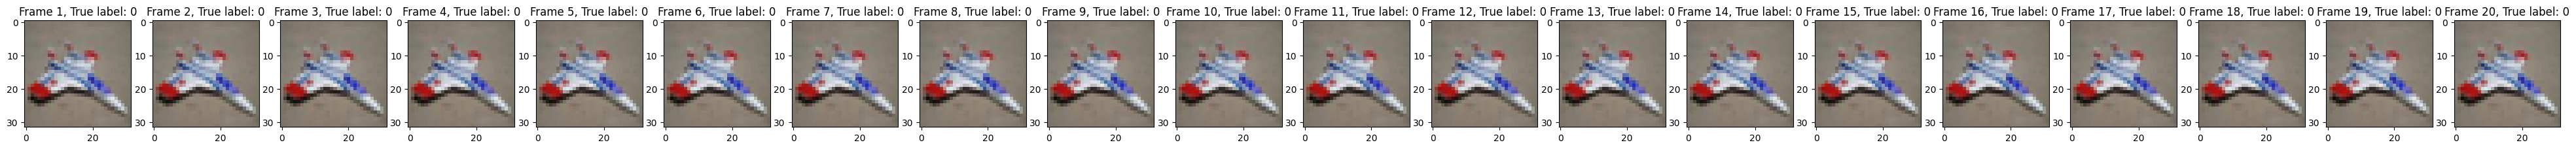

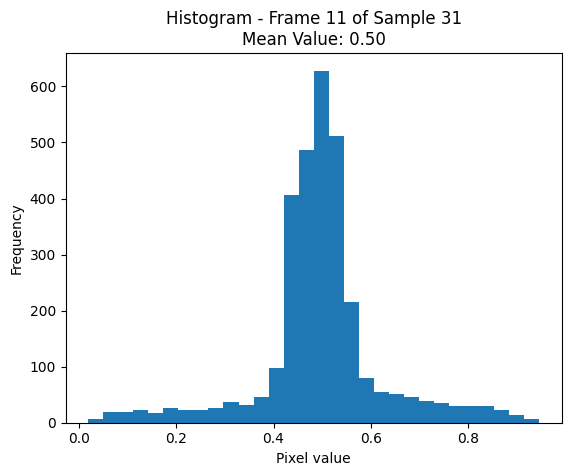

In [ ]:

sample_index=30
# number of frames for each movie
num_frames=20

fig, axs= plt.subplots(1,num_frames,figsize=(50,30),subplot_kw={'aspect':'equal'})

# loop through the frames
for i in range(num_frames):

  frame_label=str(np.argmax(y_train[sample_index]))
  axs[i].set_title(f"Frame {i+1}, True label: {frame_label}")
  axs[i].imshow(x_train_movie[sample_index,i,:,:,:])


plt.show()


frame_to_plot=10
hist_data=x_train_movie[sample_index,frame_to_plot].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()

# **5: Masks**



## **5.1: Binary Mask**

In [ ]:
## Binary Mask (modify_brightness_mask7)

def modify_brightness_mask7(img,min_spotlight_intensity,max_spotlight_intensity):

  # randomly generate a spotlight intensity within the given min and max range
  spotlight_intensity=np.random.uniform(min_spotlight_intensity,max_spotlight_intensity)

  # width and height of the image
  image_shape=img.shape[:2]

  # Create a binary mask with the same shape as CIFAR10 images
  mask_2d=np.random.randint(0,5,size=image_shape)

  # Shuffle the indices in the 2D mask
  shuffled_indices=np.random.permutation(np.arange(mask_2d.size))

  # Apply the shuffle indices to the 2D mask
  shuffled_mask= mask_2d.reshape(-1)[shuffled_indices]

  # reshape the shuffled mask to the original image shape
  shuffled_mask_2d=shuffled_mask.reshape(image_shape)

  # # Create the binary mask: if the pixel value> mean value of all pixels set to 1, otherwise set to 0
  binary_mask = np.where(shuffled_mask_2d > np.mean(shuffled_mask_2d), 1, 0)

  # Replicate the binary mask across all three channels (RGB)
  mask_3d = np.repeat(binary_mask[:, :, np.newaxis], 3, axis=2)

  # apply the light intensity to the mask
  img_mod=img.copy()
  # unmasked pixels remain unchanged
  img_mod=img_mod*((mask_3d*spotlight_intensity))+img_mod*(1-mask_3d)

  return img_mod, spotlight_intensity

## **5.2: Circular Mask**

In [ ]:
# Circular mask (modify_brightness_mask6)
def modify_brightness_mask6(img, min_spotlight_intensity, max_spotlight_intensity):

    # generate random numbers
    cx = np.random.randint(4, 24)
    cy = np.random.randint(4, 24)
    r = np.random.randint(4, 12)

    # create a mask matrix with enteries of 1 instead of zero
    mask_circ = np.ones_like(img)
    y, x = np.ogrid[-cy:img.shape[0] - cy, -cx:img.shape[1] - cx]
    mask_condition = (x**2 + y**2) <= r**2

    # randomly generate a spotlight intensity within the given min and max range
    spotlight_intensity = np.random.uniform(min_spotlight_intensity, max_spotlight_intensity)

    # mask is apppied to all three channels
    for c in range(img.shape[-1]):
        mask_circ[..., c][mask_condition] = spotlight_intensity

    # apply the mask to the image
    img_mod = img.copy()
    masked_img_circ = ((mask_circ) * img_mod)

    return masked_img_circ,spotlight_intensity

# **6: Create a movie with mask- Test Dataset**

In [ ]:
# Condition 1: Create a movie with the mask being generated for the last 5 frames

def create_movie_with_mask_last(data, labels, repeats, mask_frames, spotlight_intensity_min, spotlight_intensity_max):
    n_samples, img_height, img_width,img_channel = data.shape
    movie_data = np.zeros((n_samples, repeats, img_height, img_width, img_channel), dtype=np.float32)
    movie_labels = np.zeros((n_samples, num_classes), dtype=int)
    intensity_values=[]
    mask_frames_start = repeats - mask_frames
    for i in range(n_samples):
        mask = None
        for j in range(repeats):
            if mask_frames_start <= j < repeats:
                if mask is None:
                    # change the function for different masks (modify_brightness_mask6=circular mask function & modify_brightness_mask7=binary mask)
                    mask, intensity = modify_brightness_mask6(data[i], spotlight_intensity_min, spotlight_intensity_max)
                movie_data[i, j, :, :, :] = mask
                intensity_values.append(intensity)
            else:
                movie_data[i, j, :, :, :] = data[i]

        movie_labels[i] = labels[i]

    return movie_data, movie_labels,intensity_values

In [ ]:
# Condition2: Create a movie with a mask being generated for n (mask_frames_list) consecutive frames

def create_movie_with_mask(data, labels, repeat, mask_frames_list, spotlight_intensity_min, spotlight_intensity_max):
    n_samples, img_height, img_width, img_channel = data.shape
    movie_data = np.zeros((n_samples, repeat, img_height, img_width, img_channel), dtype=np.float32)
    movie_labels = np.zeros((n_samples, num_classes), dtype=int)
    category_labels = []
    intensity_values=[]

    for i in range(n_samples):

        # Choose a random number from mask_frames_list ( number of masked images)
        mask_frames = np.random.choice(mask_frames_list)

        # Choose a random starting frame for this sample
        mask_start = np.random.randint(0, repeat - mask_frames + 1)

        # Assign a category label for each start frame and number of masked frames
        category_labels.append((mask_start, mask_frames))

        # Create a mask for this sample
        mask = None
        for j in range(repeat):
            if j >= mask_start and j < mask_start + mask_frames:
                if mask is None:
                   # change the function for different masks (modify_brightness_mask6=circular mask function & modify_brightness_mask7=binary mask)
                    mask, intensity = modify_brightness_mask6(data[i], spotlight_intensity_min, spotlight_intensity_max)
                movie_data[i, j, :, :, :] = mask
                intensity_values.append(intensity )
            else:
                movie_data[i, j, :, :, :] = data[i]

        movie_labels[i] = labels[i]

    return movie_data, movie_labels, category_labels,intensity_values


## **6.1: Define Intensity and Number of Masked Images**

In [ ]:
# Test Dataset with Mask

# minimum intensity
spotlight_intensity_min=0.005
# maximum intensity
spotlight_intensity_max=100

# Number of masked images
# list should be used for create_movie_with_mask function
# mask_frames_list=[5]
#integer should be used for create_movie_mask_last
mask_frames_int=5

# total number of frames
repeats=20


## **6.2: Test Dataset with Masked Images**

In [ ]:
# Apply mask to random set of n frames  (create_movie_with_mask)
# x_test_mask_movie, movie_labels_mask_test, category_labe_labels, intensity_values=create_movie_with_mask(x_test,y_test,repeats,mask_frames_list,spotlight_intensity_min,spotlight_intensity_max)

# Apply mask to last 5 frames of the movie (create_movie_with_mask_last)
x_test_mask_movie, movie_labels_mask_test, intensity_values_test=create_movie_with_mask_last(x_test,y_test,repeats,mask_frames_int,spotlight_intensity_min,spotlight_intensity_max)

## **6.3: Train Dataset with Masked Images**

In [ ]:
# Train Dataset with Mask

x_train_mask_movie, movie_labels_mask_train, intensity_values_train=create_movie_with_mask_last(x_train,y_train,repeats,mask_frames_int,spotlight_intensity_min,spotlight_intensity_max)

## **6.4: Visualize the test dataset**


Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986
Intensity: 92.24674946689986


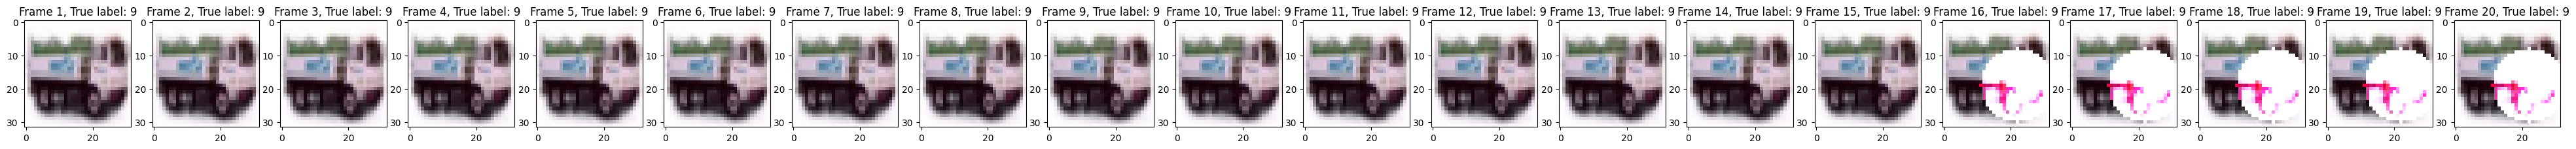

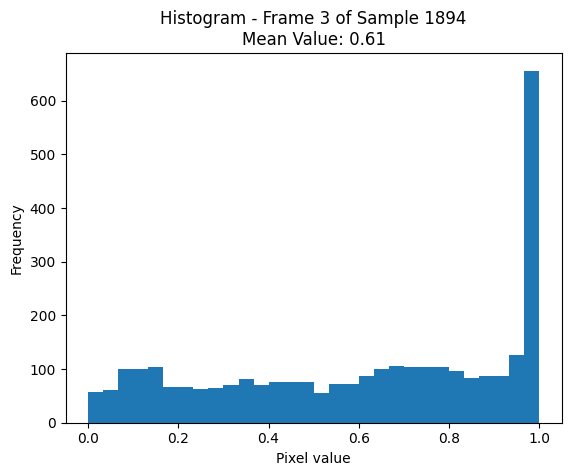

In [ ]:
# Test Dataset
sample_index=1893
# number of frames for each movie
num_frames=20

fig, axs= plt.subplots(1,num_frames,figsize=(50,30),subplot_kw={'aspect':'equal'})

# loop through the frames
for i in range(num_frames):
  frame_label=str(np.argmax(y_test[sample_index]))
  intensity = intensity_values_test[sample_index]
  axs[i].set_title(f"Frame {i+1}, True label: {frame_label}")
  img_for_display = ((x_test_mask_movie[sample_index,i,:,:,:])*255).astype('uint8')
  axs[i].imshow((x_test_mask_movie[sample_index,i,:,:,:]))
  # axs[i].imshow(img_for_display)


  print(f"Intensity: {intensity}")


plt.show()

# Histogram
frame_to_plot=2
hist_data=x_test_mask_movie[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


## **6.5: Visualize the train dataset with masked images**

Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728
Intensity: 74.82451149966728


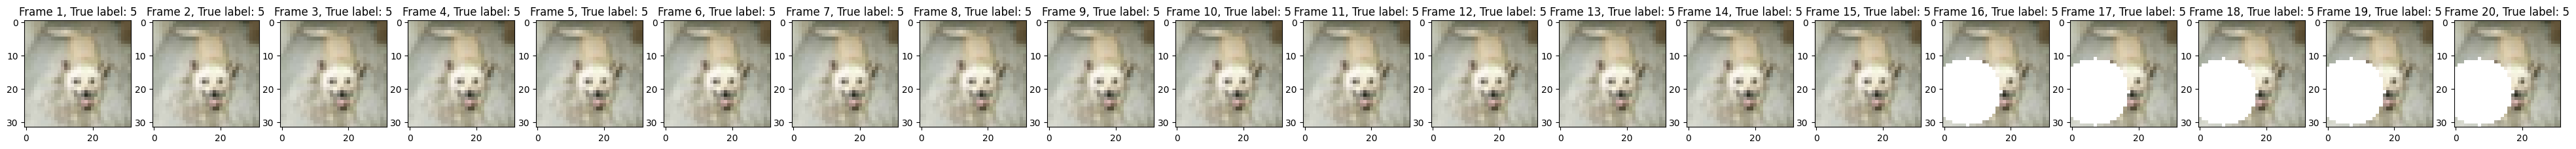

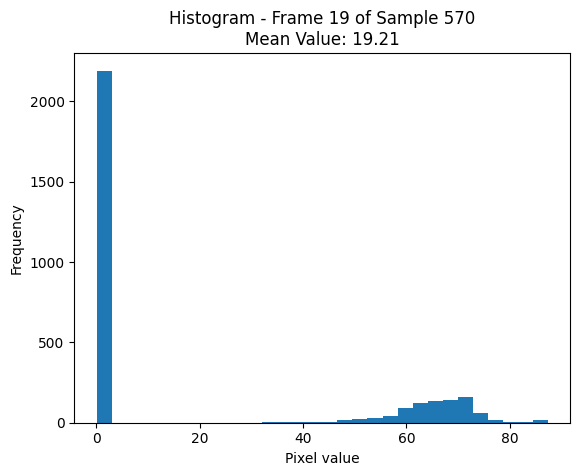

In [ ]:
# Train Dataset
sample_index=569
# number of frames for each movie
num_frames=20

fig, axs= plt.subplots(1,num_frames,figsize=(50,30),subplot_kw={'aspect':'equal'})

# loop through the frames
for i in range(num_frames):
  frame_label=str(np.argmax(y_train[sample_index]))
  intensity = intensity_values_train[sample_index]

  axs[i].set_title(f"Frame {i+1}, True label: {frame_label}")
  img_for_display = ((x_train_mask_movie[sample_index,i,:,:,:])*255).astype('uint8')
  axs[i].imshow((x_train_mask_movie[sample_index,i,:,:,:]))
  # axs[i].imshow((x_test_mask_movie_norm[sample_index,i,:,:,:]))
  # axs[i].imshow(img_for_display)

  print(f"Intensity: {intensity}")


plt.show()

# Histogram
frame_to_plot=18
hist_data=x_train_mask_movie[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()

# **7. Train dataset vs. test dataset**


## **7.1: Bar Plot**

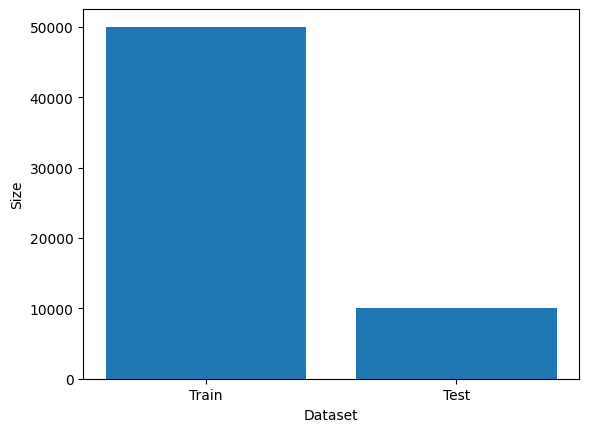

In [ ]:
# # Plot a bar chart (train vs test)
## masked images for training: x_train_mask_movie
## unmasked images for training: x_train_movie
train_size=x_train_mask_movie.shape[0]
test_size=x_test_mask_movie.shape[0]
# train_repeated_size=x_train_repeated.shape[0]
plt.bar(['Train', 'Test'], [train_size, test_size])
plt.xlabel('Dataset')
plt.ylabel('Size')
plt.show()

## **7.2: Train Dataset+Labels**

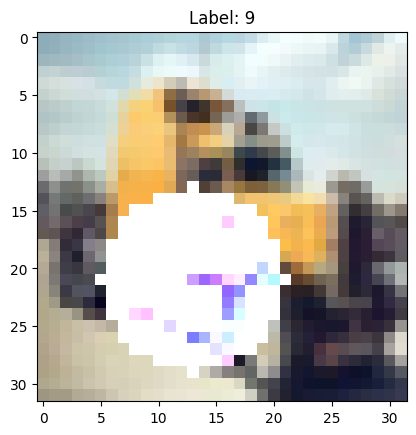

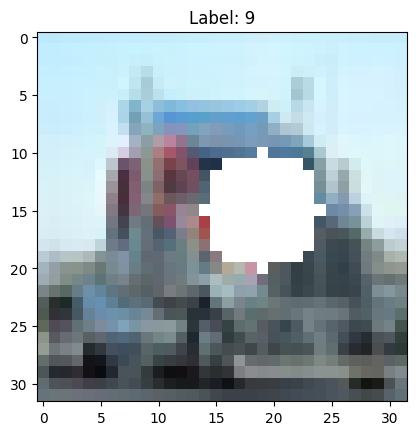

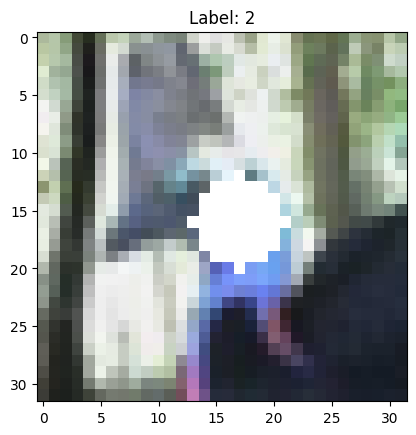

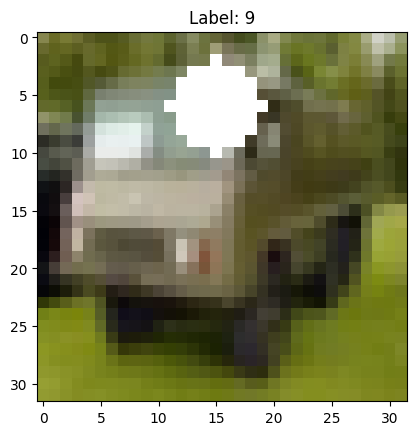

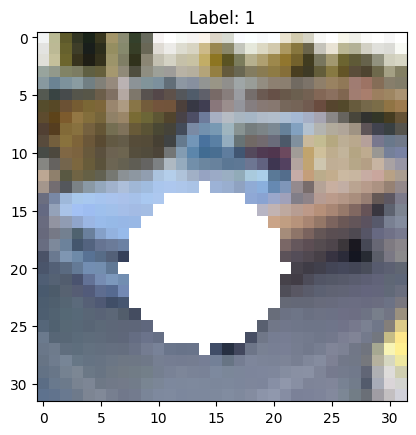

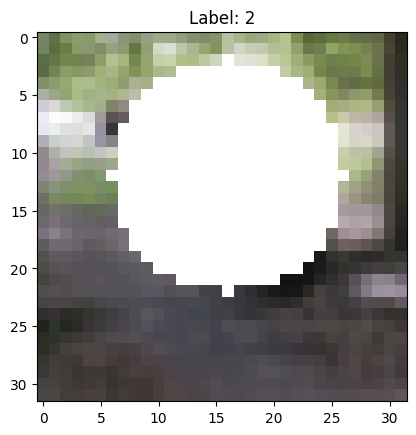

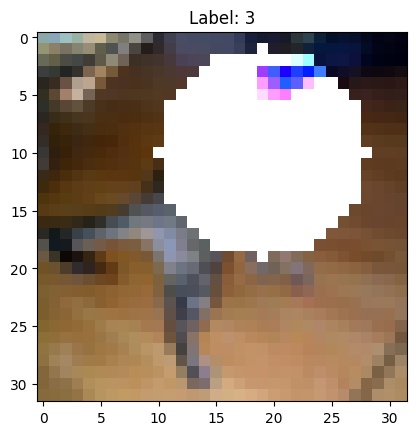

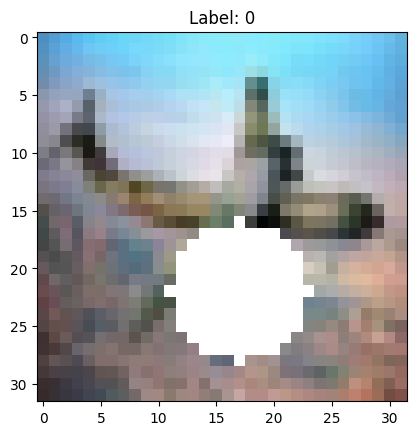

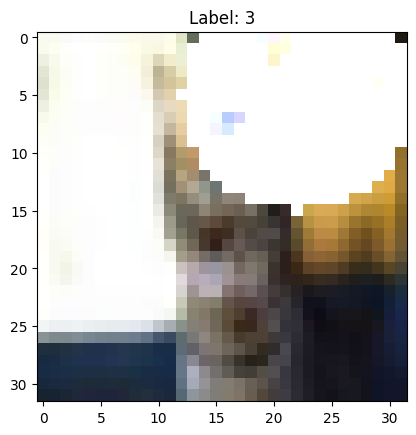

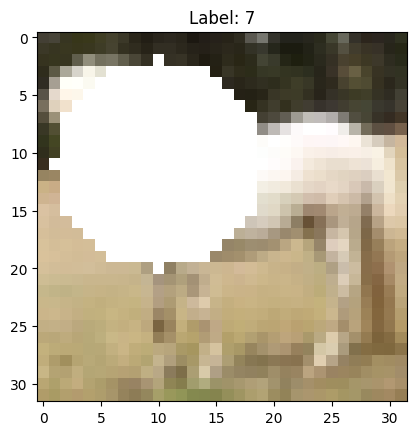

In [ ]:
# 1. Verify data and labels alignment:

# Number of random samples to visualize
num_samples = 10
frame_index=19

for _ in range(num_samples):
    idx = np.random.randint(0, len(x_train_mask_movie))
    movie = x_train_mask_movie[idx]
    frame=movie[frame_index]
    label = np.argmax(y_train[idx])

    # Visualize the sample and its label
    plt.imshow(frame)
    plt.title(f"Label: {label}")
    plt.show()

## **7.3: Test Dataset + Labels**

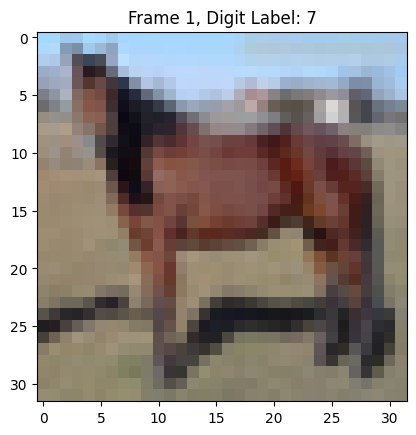

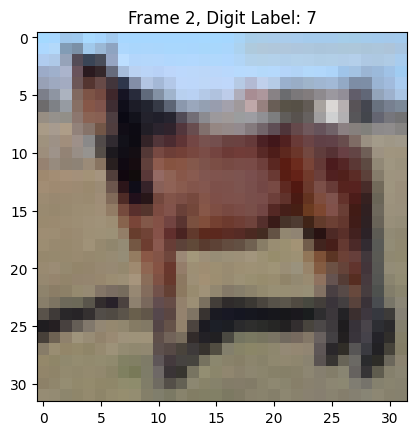

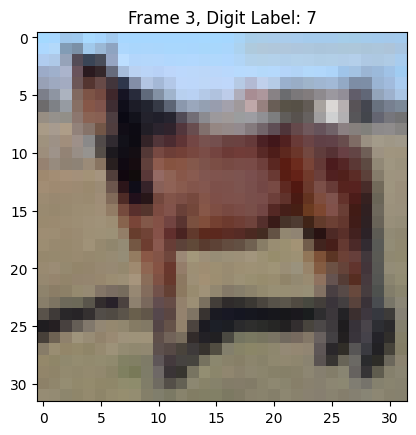

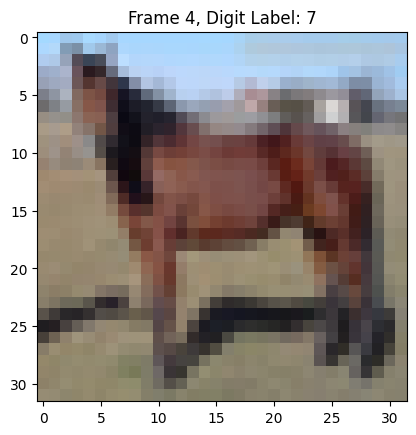

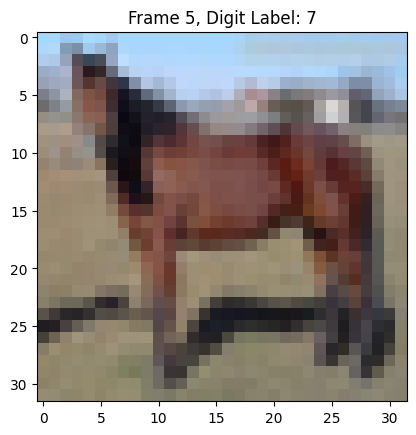

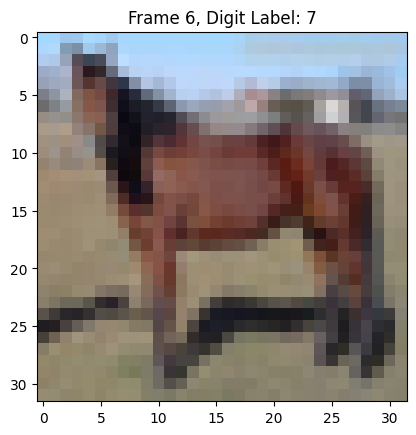

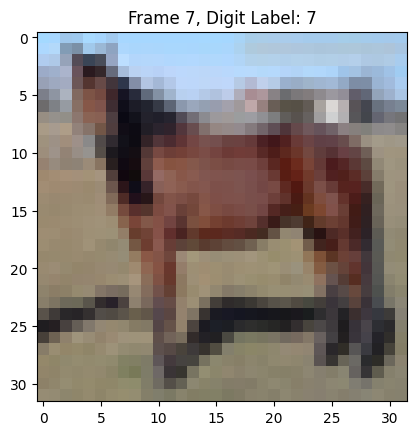

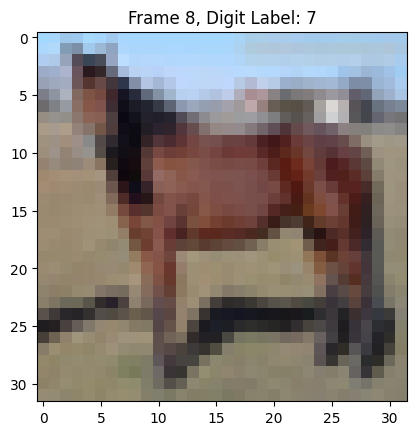

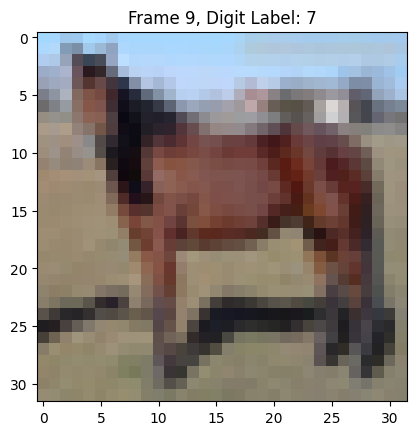

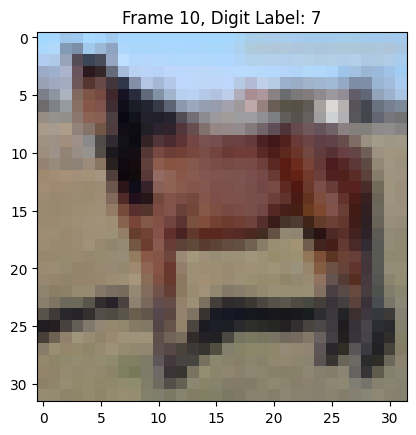

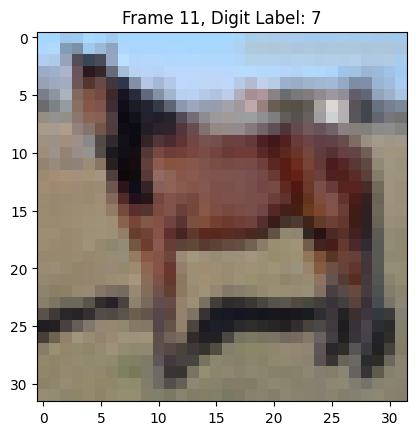

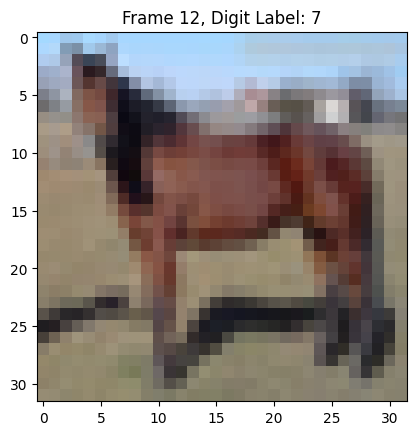

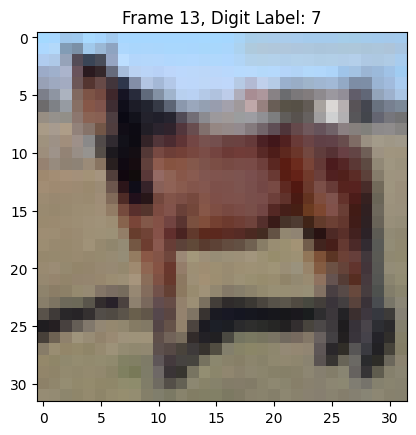

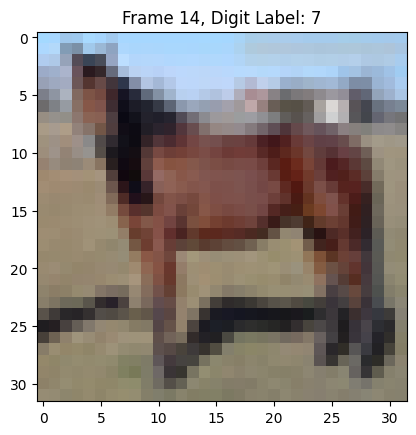

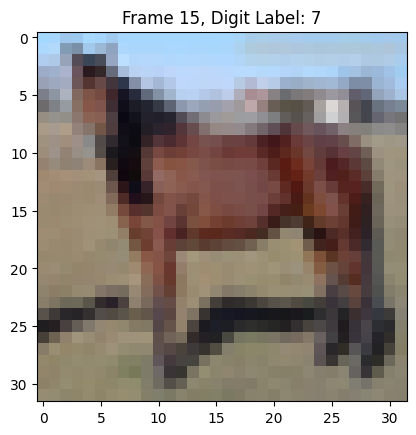

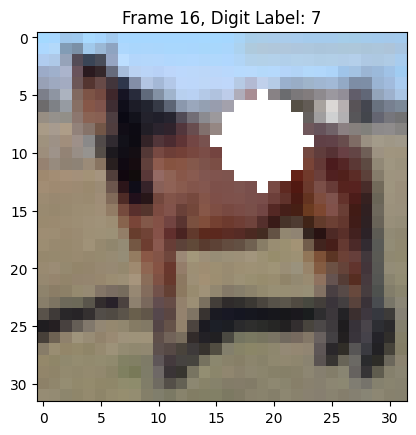

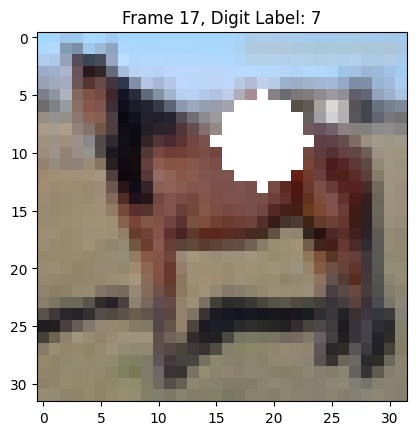

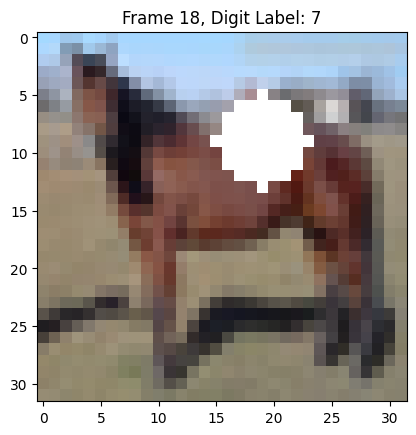

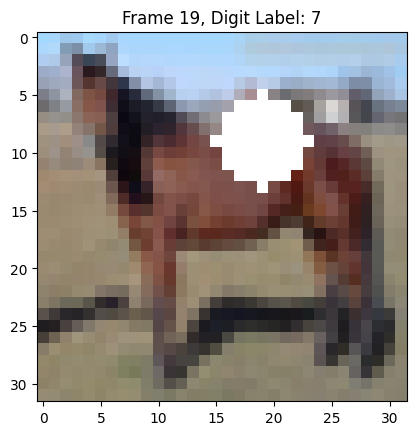

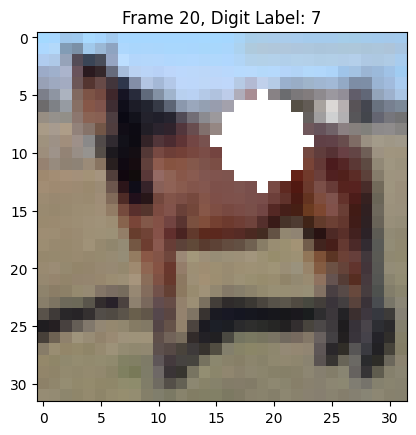

In [ ]:
# 2. Visualize all the frames of a movie
def visualize_movie_frames(x, y, movie_index):
    movie_data = x[movie_index]
    movie_labels = np.argmax(y[movie_index])

    # number of movie frames
    frames = 20

    # Get the digit label for the whole movie sequence
    digit_label = (movie_labels)

    # Iterate through the frames and visualize them with their corresponding label
    for i in range(frames):
        frame = movie_data[i]
        # farme_norm=normalize(frame)
        plt.imshow(frame)
        plt.title(f"Frame {i+1}, Digit Label: {digit_label}")
        plt.show()


# index of the movie
movie_index = 800
visualize_movie_frames(x_test_mask_movie, y_test, movie_index)

# **8. Data Generator**

In [ ]:
# Movie level data generator: label/frame
def movie_level_data_generator(x, y, batch_size):
    n_samples = len(x)
    indices = np.arange(n_samples)
    frames = 20

    while True:
        np.random.shuffle(indices)

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = indices[start:end]

            batch_x = np.array([x[i] for i in batch_idx])
            batch_y = y[batch_idx]

            # Repeat the labels for # frames
            batch_y = np.repeat(batch_y, frames, axis=0)

            # Reshape the labels to match the model's output shape
            batch_y = batch_y.reshape(-1, frames, 10)

            # Frame and its corresponding label for each movie in the batch
            for movie_idx, movie_data in enumerate(batch_x):
                for i in range(frames):
                    frame = movie_data[i, :, :]
                    label = batch_y[movie_idx, i, :]

                    digit = frame
                    digit_label = np.argmax(label)


                    digit = digit.reshape(32, 32,3)

                    # plt.imshow(digit)
                    # plt.title(f"Movie {movie_idx+1}, Frame {i+1}, Digit Label: {digit_label}")
                    # plt.show()

            yield batch_x, batch_y

In [ ]:
# Train dataset
# masked images for training : x_train_mask_movie
# unmasked images for training only: x_train_movie
train_generator = movie_level_data_generator(x_train_mask_movie, y_train, batch_size=16)
# Iterate over the generator
x, y = next(train_generator)
# Test dataset
validation_generator = movie_level_data_generator(x_test_mask_movie, y_test, batch_size=16)
# Iterate over the generator
x, y = next(validation_generator)
batch_size = 16
steps_per_epoch = len(x_train_mask_movie) // batch_size
validation_steps = len(x_test_mask_movie) // batch_size

# **9. Models**

## **9.1: Pre-trained ResNet50 Model**

### **9.1.1: Pre-trained ResNet50 without PR**

In [ ]:
# ResNet50 Model

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, LSTM

frame_num = 20

# color image
input_shape = (32, 32, 3)
# color movie
movie_input_shape = (frame_num, 32, 32, 3)
num_classes = 10

# ResNet50 base model
# don't include the top (fully-connected layer)
ResNet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# input layer ( movie)
input_layer = Input(shape=movie_input_shape)

# Add a layer Norm
# Time-independent layer norm
layer_norm=LayerNormalization()(input_layer)
# Time-distributed layer norm
# layer_norm=TimeDistributed(LayerNormalization())(input_layer)


# ResNet50 base model with TimeDistributed layer
resnet_td = TimeDistributed(ResNet50_base)(layer_norm)
y2 = TimeDistributed(Flatten())(resnet_td)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

model1 = Model(inputs=input_layer, outputs=y2)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# To reduce the font size
html_style = "<style>.text_cell_render {font-size: 2%;}</style>"
display(HTML(html_style))
display(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 32, 32, 3)]   0         
                                                                 
 layer_normalization (LayerN  (None, 20, 32, 32, 3)    6         
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, 20, 1, 1, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 2048)         0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 20, 2048)          0         
                                                             

None

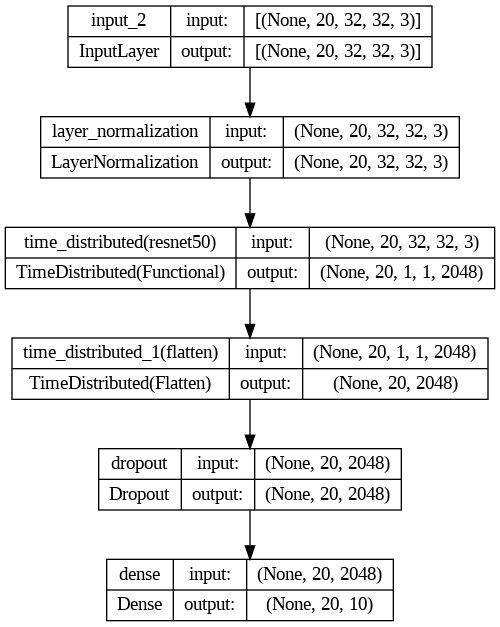

In [ ]:
# Plot the model for submodels_PR3
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='ResNet50.png', show_shapes=True, show_layer_names=True)

#### **9.1.1.1: Compiling and Training the model**

In [ ]:
# one label per frame
import os

n = 70


model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule(0)), metrics=['accuracy'])


# specify the path to save the model
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model1:ResNet50'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# load the weight for the last epoch
# initial_epoch=69
# model1.load_weights('/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model1:ResNet50/saved_models with layer norm no axis/cifar10_%s_model.070.h5')


# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             save_weights_only=False,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


callbacks = [checkpoint, lr_reducer, lr_scheduler]


history1 = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n, #initial_epoch=initial_epoch,
                      validation_data=validation_generator, validation_steps=validation_steps,callbacks=callbacks ,
                      verbose=1)

Learning rate:  0.001
Learning rate:  0.001
Epoch 1/70
3125/3125 [==============================] - ETA: 0s - loss: 2.2118 - accuracy: 0.2594
Epoch 1: saving model to /content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model1:ResNet50/saved_models/cifar10_%s_model.001.h5
3125/3125 [==============================] - 547s 159ms/step - loss: 2.2118 - accuracy: 0.2594 - val_loss: 1.8624 - val_accuracy: 0.3477 - lr: 0.0010
Learning rate:  0.001
Epoch 2/70
3125/3125 [==============================] - ETA: 0s - loss: 1.7520 - accuracy: 0.3756
Epoch 2: saving model to /content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model1:ResNet50/saved_models/cifar10_%s_model.002.h5
3125/3125 [==============================] - 499s 160ms/step - loss: 1.7520 - accuracy: 0.3756 - val_loss: 2.0460 - val_accuracy: 0.3909 - lr: 0.0010
Learning rate:  0.001
Epoch 3/70
3125/3125 [==============================] - ETA: 0s - loss: 1.6300 - accuracy: 0.4334
Epoch 3: s

#### **9.1.1.2:Load the model**


In [ ]:
from keras.models import load_model

# specify the path to the model
checkpoint_path = "/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model1:ResNet50/model1.h5"

# load the model from the checkpoint
model1 = load_model(checkpoint_path)



#### **9.1.1.3: Accuracy plot**


In [ ]:
# Accuracy plot (Average Accuracy per movie)

n1=70
dict_hist = history1.history

list_ep = [i for i in range(1,n1+1)]

plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(list_ep, dict_hist['accuracy'],ls='--',label='accuracy-train_dataset')
plt.plot(list_ep, dict_hist['val_accuracy'],ls='--',label='accuracy-validation_dataset')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(list_ep, dict_hist['loss'],ls='--',label='loss-train_dataset')
plt.plot(list_ep, dict_hist['val_loss'],ls='--',label='loss-validation_dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

#### **9.1.1.4:Frame Level Predictions**


In [ ]:

frame_num=20

# predicted label matches the actual label
num_movies_all_correct=np.zeros(20)
frame_accs=np.zeros(20)
mismatched_movies=[]

# Loop through each movie in the test set
for movie_idx, movie_data in enumerate(x_test_mask_movie):

    # labels (use y_test_encoded)
    movie_labels = (y_test_encoded[movie_idx])
    movie_labels = np.repeat(movie_labels, frame_num, axis=0)
    # label tensor and frames tensor
    movie_labels = movie_labels.reshape(frame_num, -1)

    # Predict the labels for each frame in the movieslack
    predicted_labels = model1.predict(movie_data.reshape(1, 20, 32, 32,3))

    # Calculate the accuracy for each frame in the movie
    mismatch_found = False
    for frame_idx in range(20):
        frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
        frame_accs[frame_idx] += (frame_acc)


        # Repeat the label for each frame in the movie
        label = movie_labels[frame_idx]

        print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")
    # When comparing the frames, do not consider the first frame edge effect so starts from 1
    all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
    if all_correct:
        num_movies_all_correct += 1

# Print the number of movies where all frames match the labels
print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")

# Divide by the number of movies to get the mean accuracy for each frame
frame_accs /= len(x_test_mask_movie)



Streaming output truncated to the last 5000 lines.
Movie 9762, Frame 20 Accuracy: [ True],predicted_label:5, actual label:[5]
1/1 [==============================] - 0s 29ms/step
Movie 9763, Frame 1 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 2 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 3 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 4 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 5 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 6 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 7 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 8 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 9 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 10 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 11 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 

#### **9.1.1.5:Predicted and True Labels Comparison**

In [ ]:
# Choose a movie index to plot its frames
movie_idx =4579

# Get the data and labels for the chosen movie
movie_data = x_test_mask_movie[movie_idx]
movie_labels = y_test[movie_idx]

# Repeat the labels for each frame in the movie ( the first frame is eliminated )
frame_num = 20
movie_labels = np.repeat(movie_labels, frame_num, axis=0)
movie_labels = movie_labels.reshape(frame_num, -1)

# Predict the labels for each frame in the movie
predicted_labels = model1.predict(movie_data.reshape(1, 20, 32, 32,3))




fig, axs = plt.subplots(1, num_frames, figsize=(100, 30), subplot_kw={'aspect': 'equal'})

# loop through the frames and display each one separately
for i in range(num_frames):

    digit = movie_data[i, :, :, :]
    digit_label = np.argmax(predicted_labels[0][i])
    digit = digit.reshape(32, 32,3)
    axs[i].imshow(digit)
    axs[i].set_title(f"Movie {movie_idx+1}, Frame {i+1}, Digit Label: {digit_label}")
    axs[i].axis('off')



plt.show()


### **9.1.2: ResNet50+PR(R+G+B) Model-with the PR model**

In [ ]:
#CNN + PR Model (Time Distributed)- MNIST

from PIL import Image
from tensorflow.keras.regularizers import l1_l2

## ResNet Model
frame_num = 20
num_classes = 10

# Number of channels for PR model
chan1_n=1
chanl_col=3

output=[]


# input_movie has three colors
input_layer = Input(shape=(frame_num, 32, 32, 3))


# input to ResNet50 model
input_shape = (20, 32, 32)
inputs = Input(shape=input_shape)

# Run the model for each color

for i in range(chanl_col):


    # Split the channels
    channel_input = Lambda(lambda x: x[..., i:i+1])(input_layer)

    # layer_norm=LayerNormalization()(channel_input)
    # PR Architecture
    y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]))(channel_input)
    y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
    y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-1],chan1_n))(y1)
    y1 = y1[:,:,:,:,:]

    #y1_norm = TimeDistributed(LayerNormalization(axis=[-3, -2]))(y1)
    output.append(y1)

# Red Channel
ch_r=output[0]
# Green Channel
ch_g=output[1]
# Blue Channel
ch_b=output[2]

# 1: Concatenate about the last axis
merged_channels = Concatenate(axis=-1)([ch_r, ch_g, ch_b])



# # 2: Stacking the output (Stacking vs )
# Stack the last axis
output_stack = tf.stack(output, axis=-2)
# Reshape the output
reshaped_output = tf.reshape(output_stack, shape=(-1, frame_num, 32, 32, chanl_col))


# Normalization layer
# layer_norm=TimeDistributed(LayerNormalization(axis=[-3, -2]))(merged_channels)
layer_norm=LayerNormalization()(merged_channels)

# use conv2D to reduce the number of channels (More than 1 channel)
#y1_reduced = Conv2D(filters=3, kernel_size=(1, 1), strides=(1, 1))(layer_norm)
#y1_normalized = BatchNormalization()(y1_reduced)


# # ResNet50 base model (pre-trained model)
ResNet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,chanl_col))


y2= TimeDistributed(ResNet50_base)(layer_norm)
y2 = TimeDistributed(Flatten())(y2)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)





# Outputs

# Different colors
red=(Model(inputs=input_layer, outputs=ch_r))
green=(Model(inputs=input_layer, outputs=ch_g))
blue=(Model(inputs=input_layer, outputs=ch_b))

# Concatenation
concat=(Model(inputs=input_layer, outputs=merged_channels))

# Stacking
stack=(Model(inputs=input_layer, outputs=reshaped_output))

# Normalization
norm=(Model(inputs=input_layer, outputs=layer_norm))

# Final Model
model3 = Model(inputs=input_layer, outputs=y2)

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
# To reduce the font size
html_style = "<style>.text_cell_render {font-size: 2%;}</style>"
display(HTML(html_style))
display(model3.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 32, 32,  0           []                               
                                 3)]                                                              
                                                                                                  
 lambda (Lambda)                (None, 20, 32, 32,   0           ['input_1[0][0]']                
                                1)                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 20, 32, 32,   0           ['input_1[0][0]']                
                                1)                                                          

None

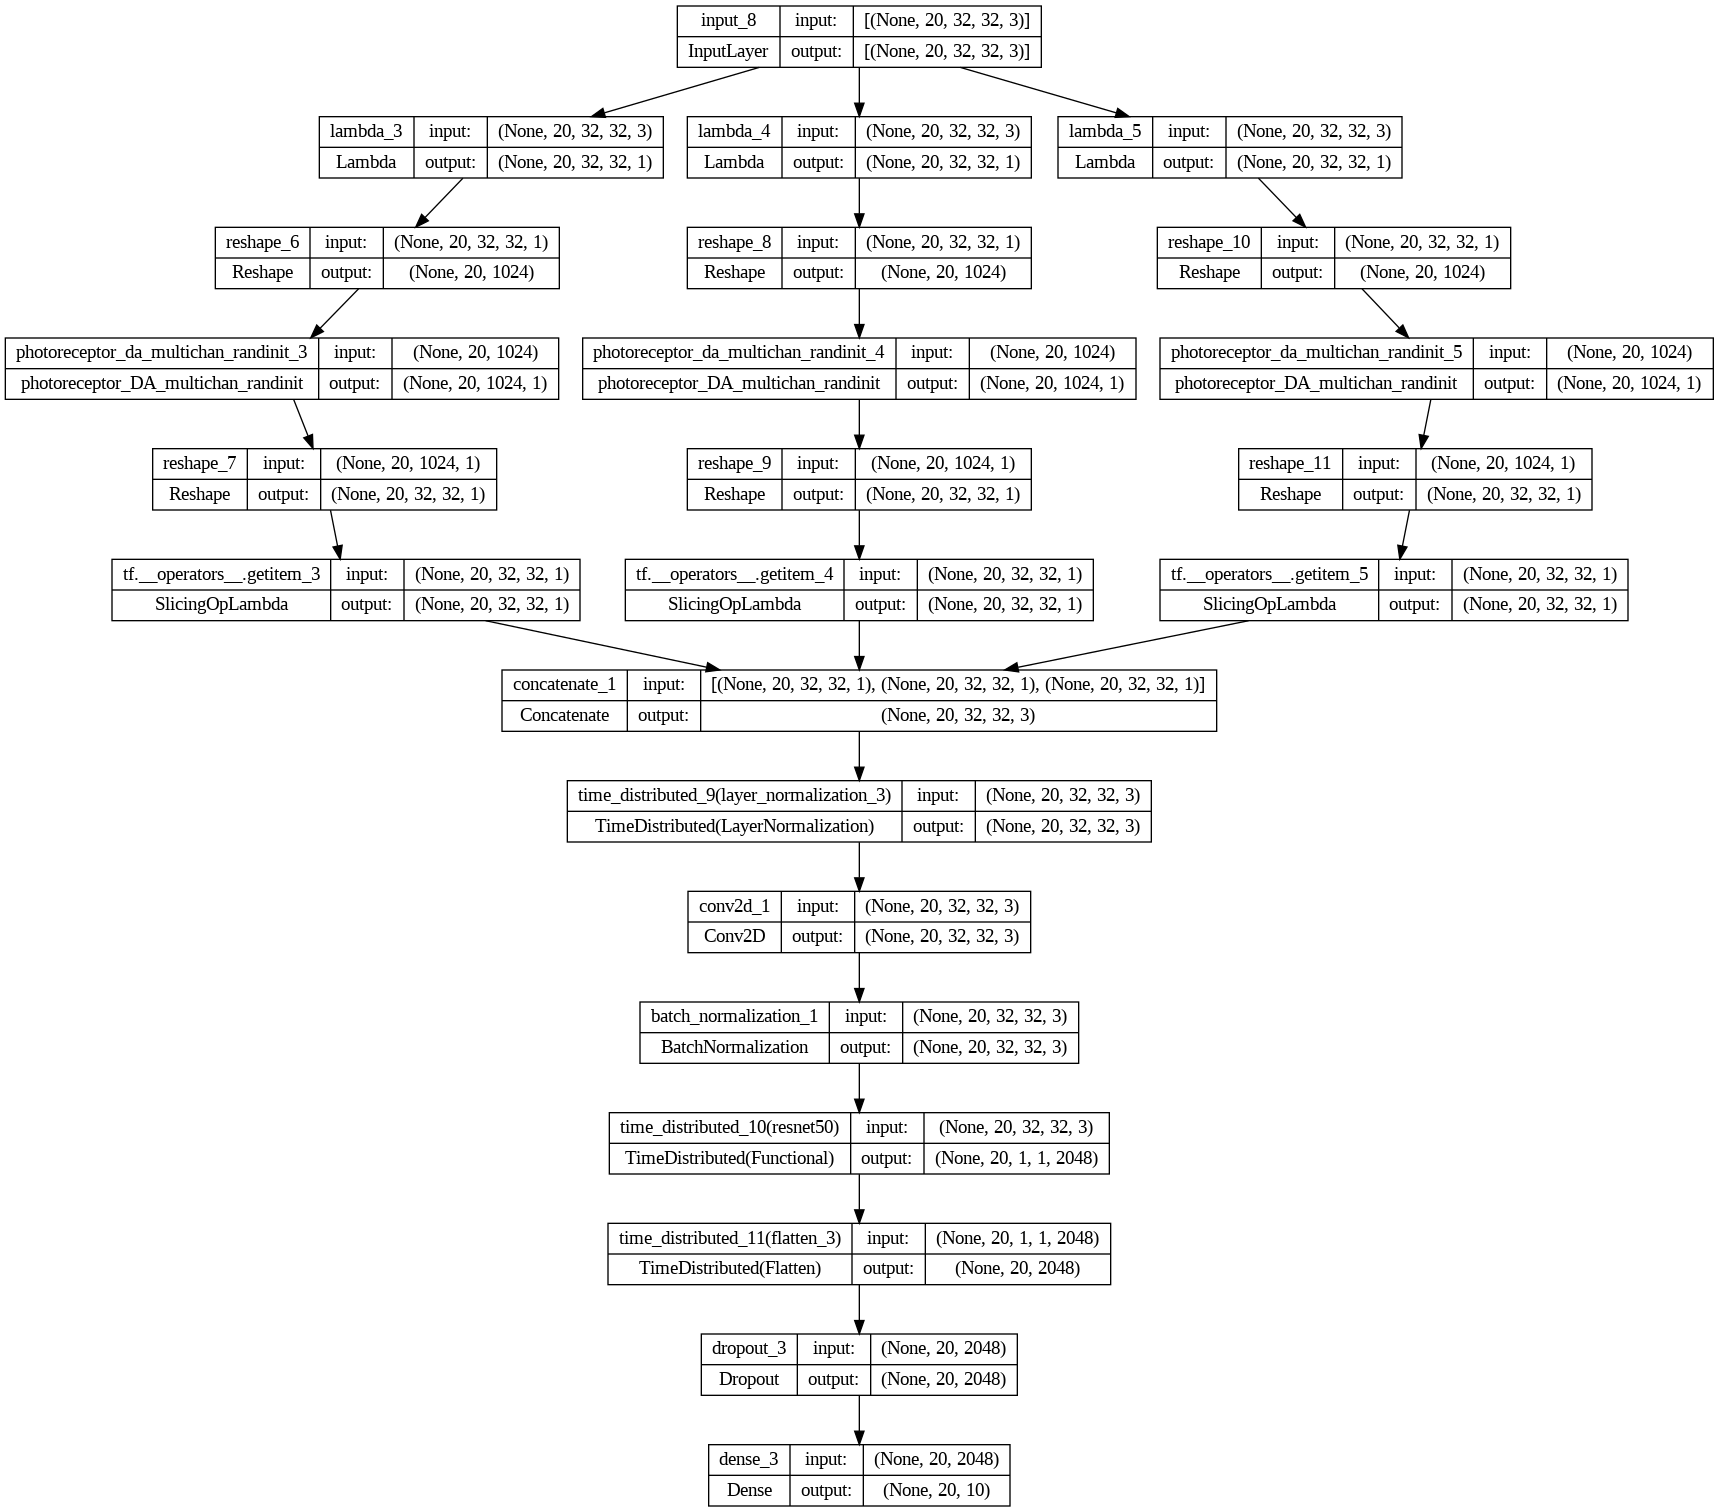

In [ ]:
# Plot the model for submodels_PR3
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='ResNet50+PR(R+G+B).png', show_shapes=True, show_layer_names=True)

#### **9.1.2.1:Compiling and Training**


#### **9.1.2.2: Accuracy Plot**

In [30]:
# one label per frame
import os

n = 70

#
model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule(0)), metrics=['accuracy'])
# model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# specify the path to save the model
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3:DynamicCoding/Nilou_Codes/CIFAR10/Model3:ResNet50'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# load the weight for the last epoch
#initial_epoch=69
#model3.load_weights('//content/drive/MyDrive/PhD-Nilou/Project#3:DynamicCoding/Nilou_Codes/CIFAR10/Model3:ResNet50/saved_models/cifar10_%s_model.021.h5')


# Save all the weight values not just the best one
checkpoint = ModelCheckpoint(filepath=filepath,
                             save_weights_only=False,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False,
                             )

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


callbacks = [checkpoint, lr_reducer, lr_scheduler]

# remove the initial epoch if the saved weight values are not used
history3 = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n, #initial_epoch=initial_epoch,
                      validation_data=validation_generator, validation_steps=validation_steps,callbacks=callbacks ,
                      verbose=1)

Learning rate:  0.001
Learning rate:  1e-05
Epoch 70/70
3125/3125 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9126
Epoch 70: saving model to /content/drive/MyDrive/PhD-Nilou/Project#3:DynamicCoding/Nilou_Codes/CIFAR10/Model3:ResNet50/saved_models/cifar10_%s_model.070.h5
3125/3125 [==============================] - 621s 185ms/step - loss: 0.2529 - accuracy: 0.9126 - val_loss: 1.1772 - val_accuracy: 0.7068 - lr: 1.0000e-05


In [ ]:
# Accuracy plot (Average accuracy per movie)

n1=5
dict_hist = history3.history

list_ep = [i for i in range(1,n1+1)]

plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(list_ep, dict_hist['accuracy'],ls='--',label='accuracy-train_dataset')
plt.plot(list_ep, dict_hist['val_accuracy'],ls='--',label='accuracy-validation_dataset')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(list_ep, dict_hist['loss'],ls='--',label='loss-train_dataset')
plt.plot(list_ep, dict_hist['val_loss'],ls='--',label='loss-validation_dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

#### **9.1.2.3: Frame-Level Predictions**

In [39]:

frame_num=20
num_movies_all_correct=np.zeros(20)
frame_accs=np.zeros(20)
mismatched_movies=[]

# Loop through each movie in the test set
for movie_idx, movie_data in enumerate(x_test_mask_movie):

    # labels
    movie_labels = (y_test_encoded[movie_idx])
    movie_labels = np.repeat(movie_labels, frame_num, axis=0)
    # label tensor and frames tensor
    movie_labels = movie_labels.reshape(frame_num, -1)

    # Predict the labels for each frame in the movieslack
    predicted_labels = model3.predict(movie_data.reshape(1, 20, 32, 32,3))

    # Calculate the accuracy for each frame in the movie
    mismatch_found = False
    for frame_idx in range(20):
        frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
        frame_accs[frame_idx] += (frame_acc)


        # Repeat the label for each frame in the movie
        label = movie_labels[frame_idx]

        print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")


    # Do not consider the first frame becasue of the edge effect (starts from 1)
    all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
    if all_correct:
        num_movies_all_correct += 1

# Print the number of movies where all frames match the labels
print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")

# Divide by the number of movies to get the mean accuracy for each frame
frame_accs /= len(x_test_mask_movie)


#### **O9.1.2.4: Output channels Visualization**

1/1 [==============================] - 0s 38ms/step


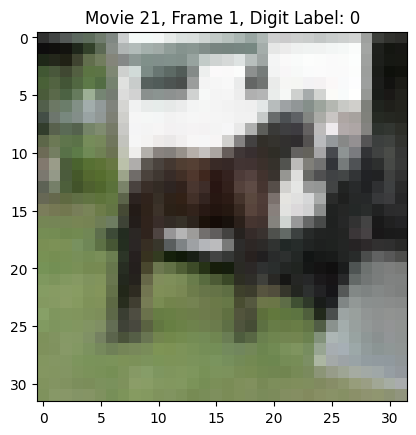

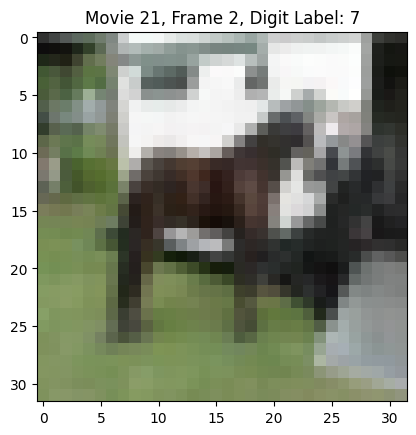

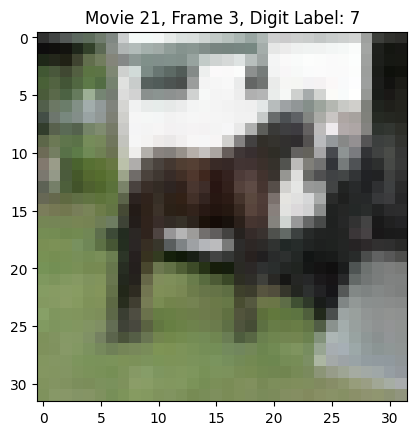

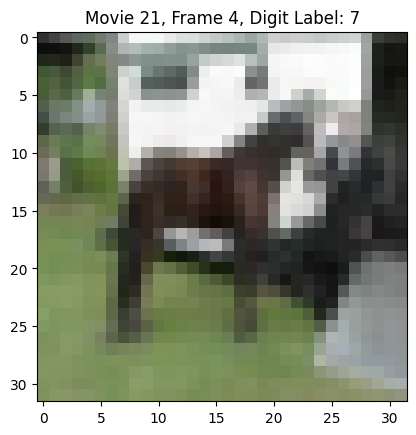

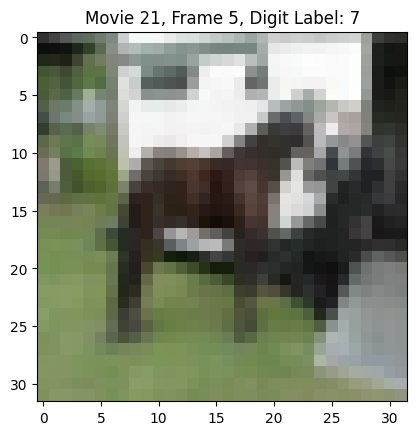

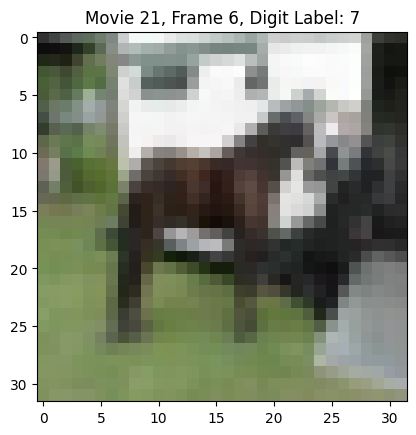

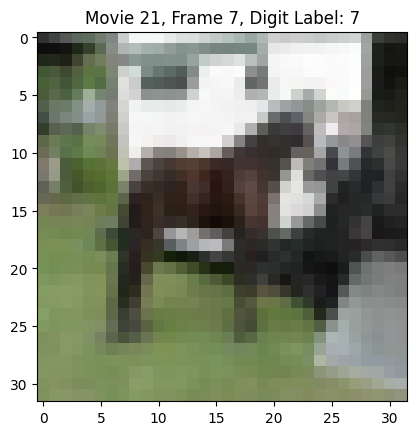

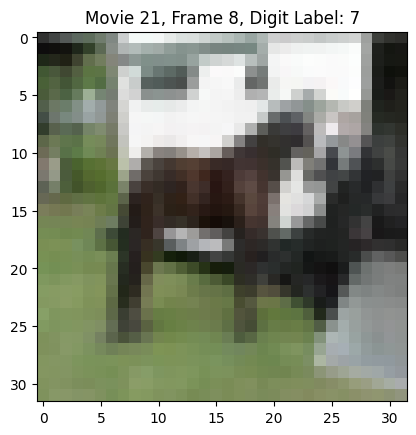

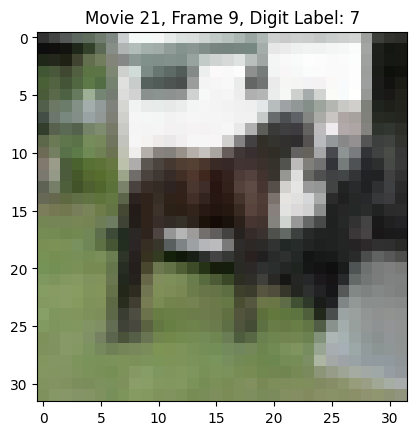

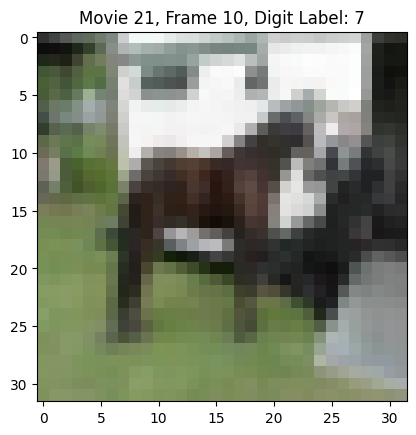

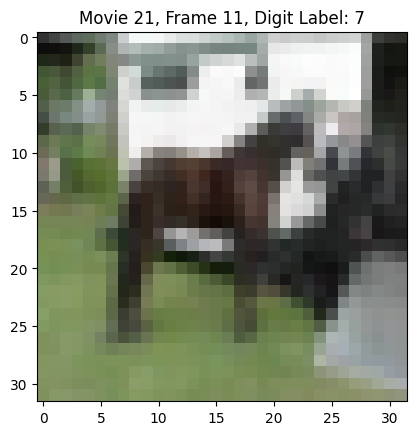

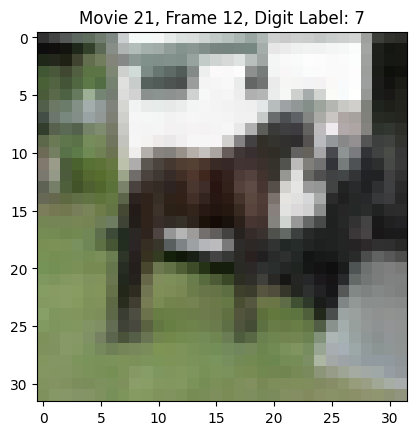

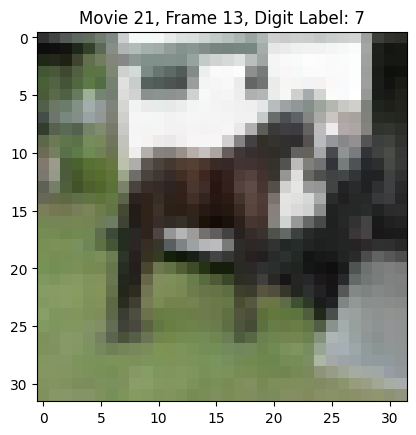

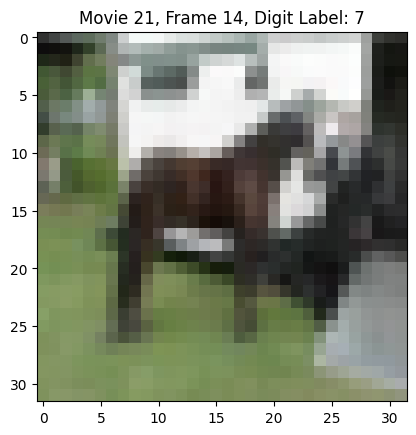

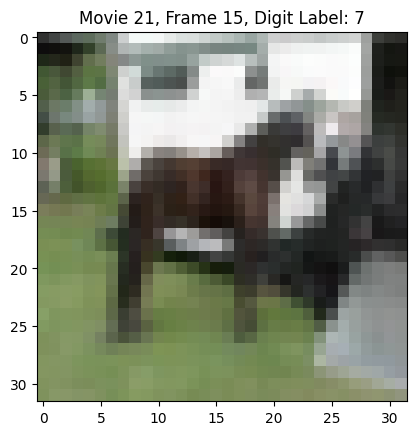

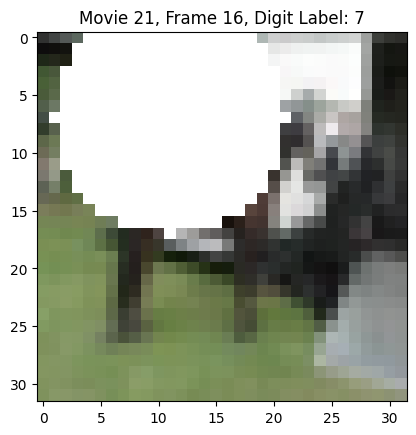

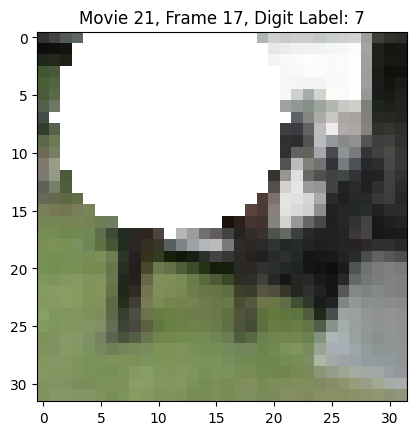

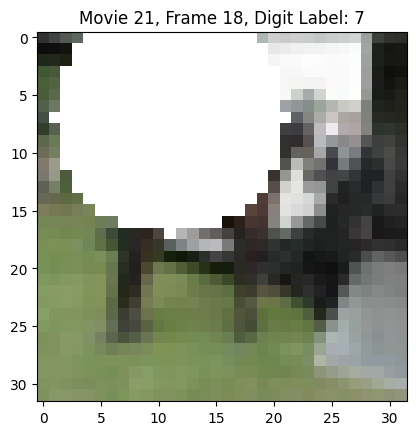

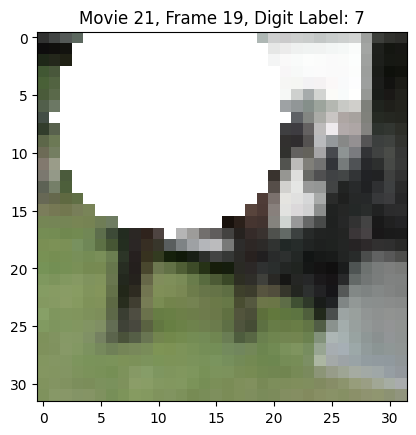

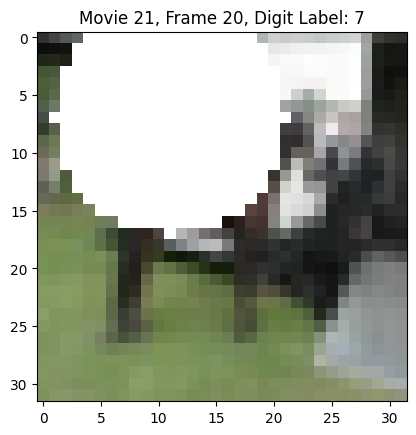

In [ ]:
# Choose a movie index to plot its frames
movie_idx =20

# Get the data and labels for the chosen movie
movie_data = x_test_mask_movie[movie_idx]
movie_labels = y_test[movie_idx]

# Repeat the labels for each frame in the movie
frame_num = 20
movie_labels = np.repeat(movie_labels, frame_num, axis=0)
movie_labels = movie_labels.reshape(frame_num, -1)

# Predict the labels for each frame in the movie
predicted_labels = model3.predict(movie_data.reshape(1, 20, 32, 32, 3))

# Loop through each frame in the movie and plot it with its predicted label
for frame_idx in range(frame_num):
    # Display the digit image and its predicted label
    digit = movie_data[frame_idx, :, :]
    digit_label = np.argmax(predicted_labels[0][frame_idx])
    digit = digit.reshape(32, 32,3)
    plt.imshow(digit)
    plt.title(f"Movie {movie_idx+1}, Frame {frame_idx+1}, Digit Label: {digit_label}")
    plt.show()

#### **9.1.2.5: Predicted and True Labels Comparison**




1/1 [==============================] - 0s 28ms/step


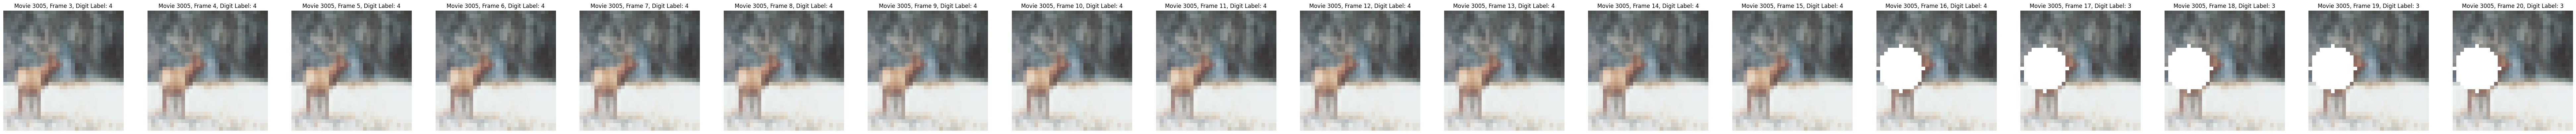

In [ ]:
# Actual digit vs predicted image
movie_idx = 3004
# the number of frames in each image
num_frames =20

# Get the data and labels for the chosen movie
movie_data = x_test_mask_movie[movie_idx]
movie_labels = y_test[movie_idx]

# Repeat the labels for each frame in the movie
frame_num = 18
movie_labels = np.repeat(movie_labels, frame_num, axis=0)
movie_labels = movie_labels.reshape(frame_num, -1)

# Predict the labels for each frame in the movie
predicted_labels = model3.predict(movie_data.reshape(1, 20, 32, 32, 3))

fig, axs = plt.subplots(1, frame_num , figsize=(100, 30), subplot_kw={'aspect': 'equal'})
# loop through the frames and display each one separately
for i in range(frame_num):
    digit = movie_data[i+2, :, :]
    digit_label = np.argmax(predicted_labels[0][i+2])
    digit = digit.reshape(32, 32,3)
    axs[i].imshow(digit)
    axs[i].set_title(f"Movie {movie_idx+1}, Frame {i+3}, Digit Label: {digit_label}")
    axs[i].axis('off')


plt.show()


#### **9.1.2.6: Photoreceptor Parameters/weight values**

In [ ]:
# There are three sets of parameters
weights, names=get_weightsDict(model3)
print(names)
s1=names[0]
s2=names[22]
s3=names[44]
print(s1)
print(s2)
print(s3)

substring1 = s1.split("/")[0]
substring2 = s2.split("/")[0]
substring3 = s3.split("/")[0]
layer_name_ch1=substring1
layer_name_ch2=substring2
layer_name_ch3=substring3

print(substring1)
print(substring2)
print(substring3)

W_L_ch1=get_weightsOfLayer(weights,layer_name_ch1)
W_L_ch2=get_weightsOfLayer(weights,layer_name_ch2)
W_L_ch3=get_weightsOfLayer(weights,layer_name_ch3)
print(W_L_ch1)
print(W_L_ch2)
print(W_L_ch3)



weights_ch1 = concat.layers[7].get_weights()
weights_ch2 = concat.layers[8].get_weights()
weights_ch3 = concat.layers[9].get_weights()
print(weights_ch1)
print(weights_ch2)
print(weights_ch3)

['photoreceptor_da_multichan_randinit/zeta:0', 'photoreceptor_da_multichan_randinit/kappa:0', 'photoreceptor_da_multichan_randinit/alpha:0', 'photoreceptor_da_multichan_randinit/beta:0', 'photoreceptor_da_multichan_randinit/gamma:0', 'photoreceptor_da_multichan_randinit/tauY:0', 'photoreceptor_da_multichan_randinit/nY:0', 'photoreceptor_da_multichan_randinit/tauZ:0', 'photoreceptor_da_multichan_randinit/nZ:0', 'photoreceptor_da_multichan_randinit/tauC:0', 'photoreceptor_da_multichan_randinit/zeta_mulFac:0', 'photoreceptor_da_multichan_randinit/kappa_mulFac:0', 'photoreceptor_da_multichan_randinit/alpha_mulFac:0', 'photoreceptor_da_multichan_randinit/beta_mulFac:0', 'photoreceptor_da_multichan_randinit/gamma_mulFac:0', 'photoreceptor_da_multichan_randinit/tauY_mulFac:0', 'photoreceptor_da_multichan_randinit/nY_mulFac:0', 'photoreceptor_da_multichan_randinit/tauZ_mulFac:0', 'photoreceptor_da_multichan_randinit/nZ_mulFac:0', 'photoreceptor_da_multichan_randinit/tauC_mulFac:0', 'photorecep

#### **9.1.2.7: Visualizing the output of each layer**

In [ ]:
# Output of different layers
output_r=red.predict(x_test_mask_movie)
output_g=green.predict(x_test_mask_movie)
output_b=blue.predict(x_test_mask_movie)
output_con=concat.predict(x_test_mask_movie)
#output_stack=stack.predict(x_test_mask_movie)
#output_norm=norm.predict(x_test_mask_movie)

313/313 [==============================] - 2s 5ms/step


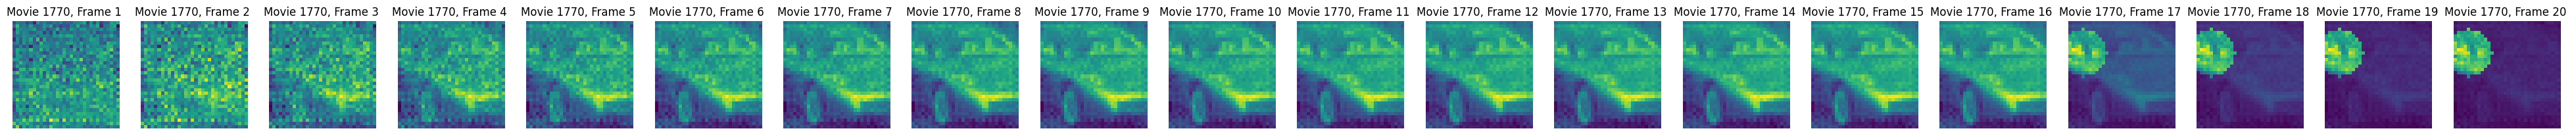

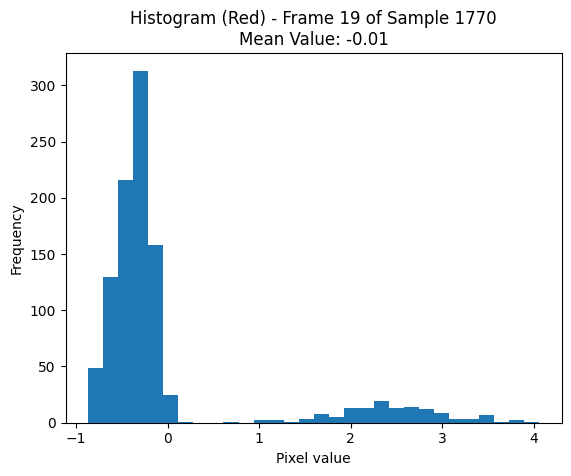

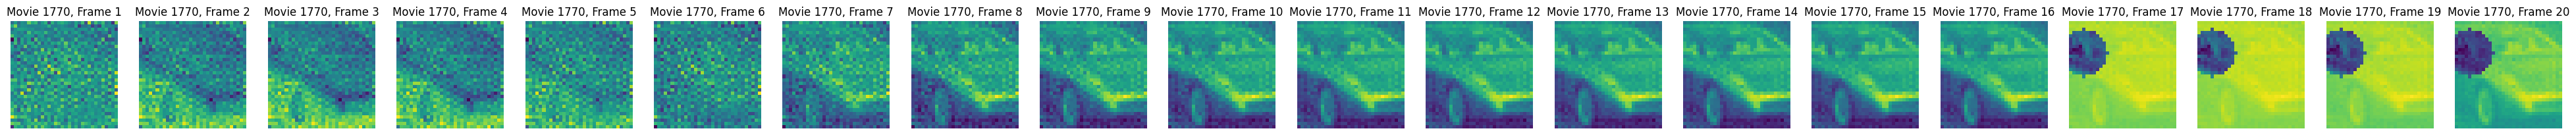

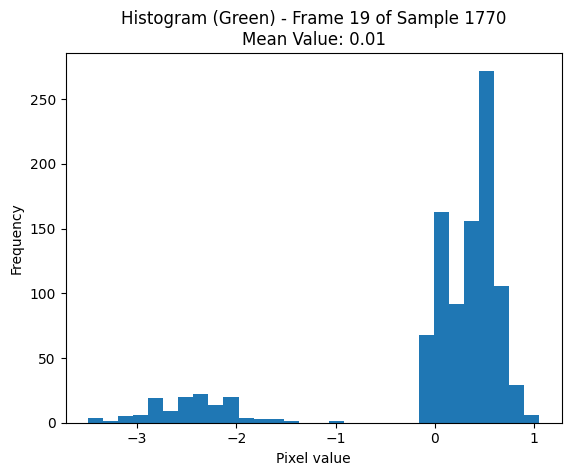

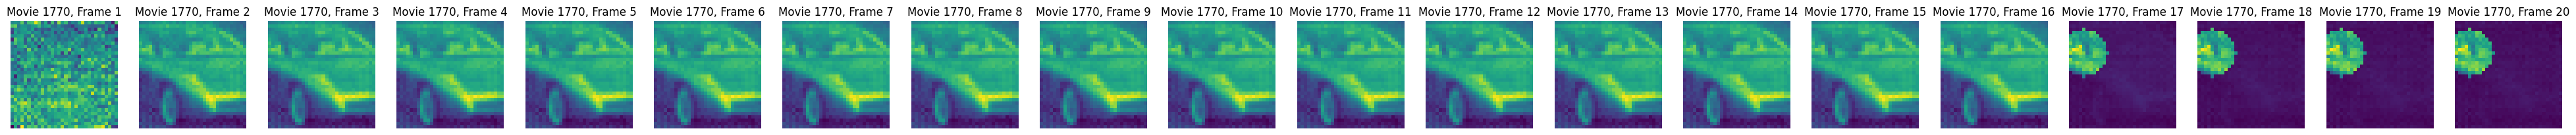

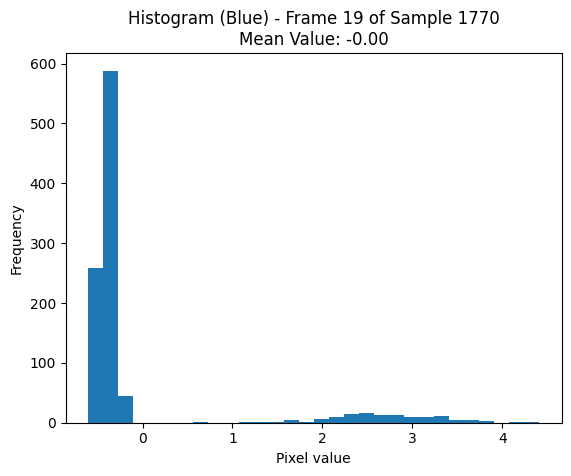

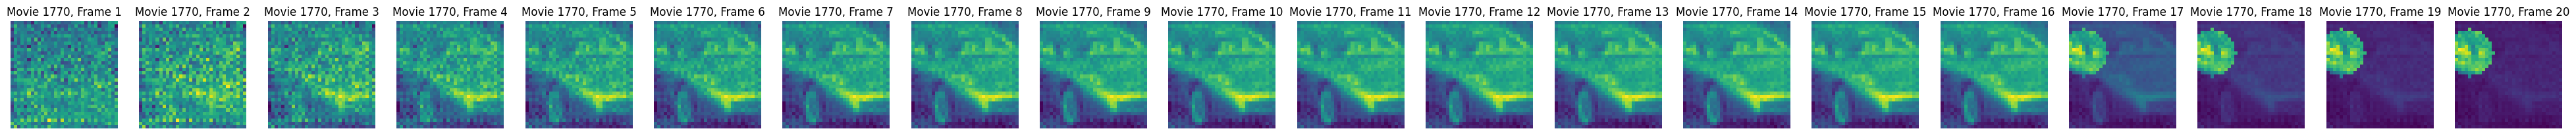

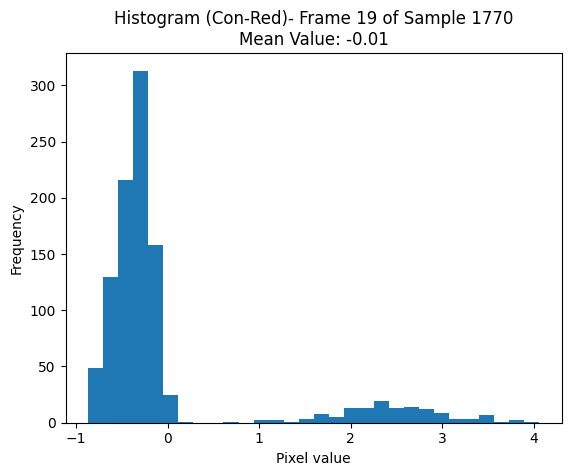

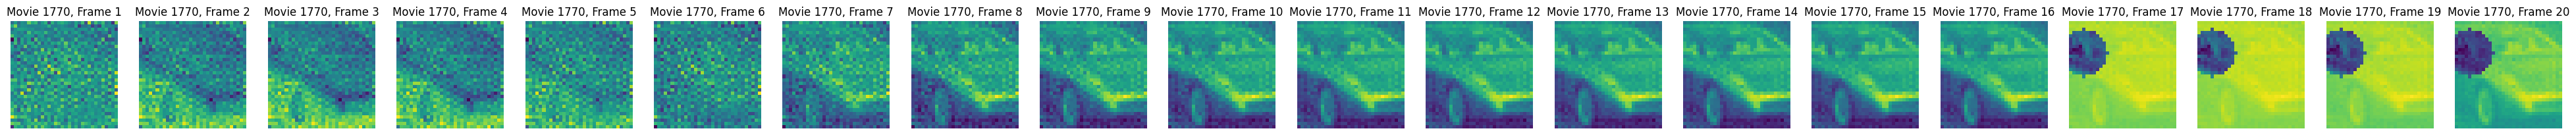

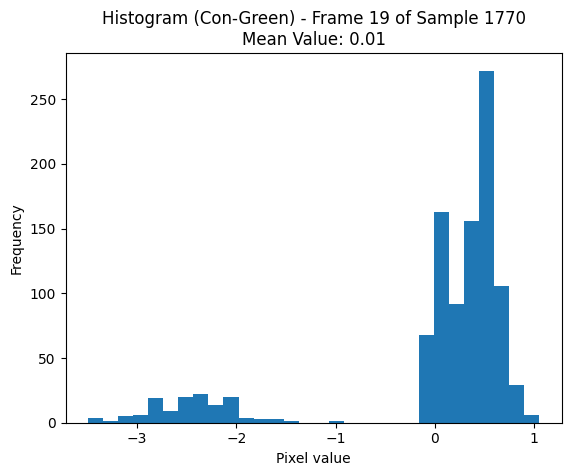

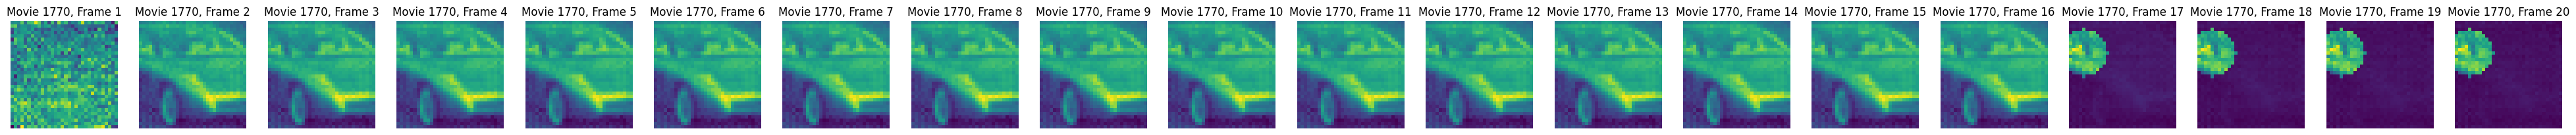

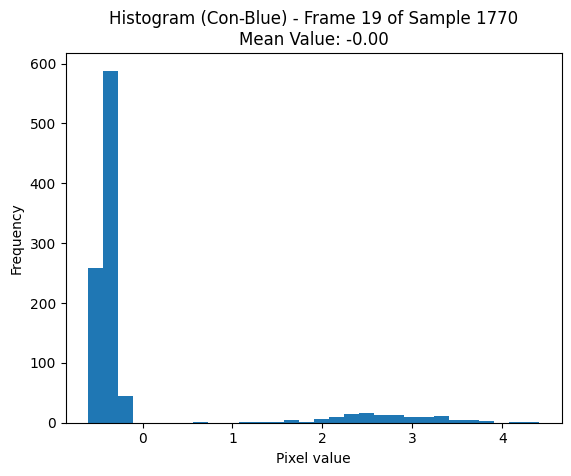

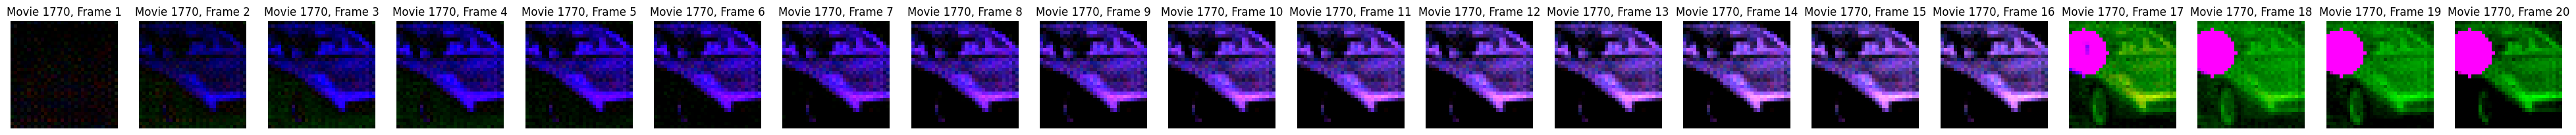

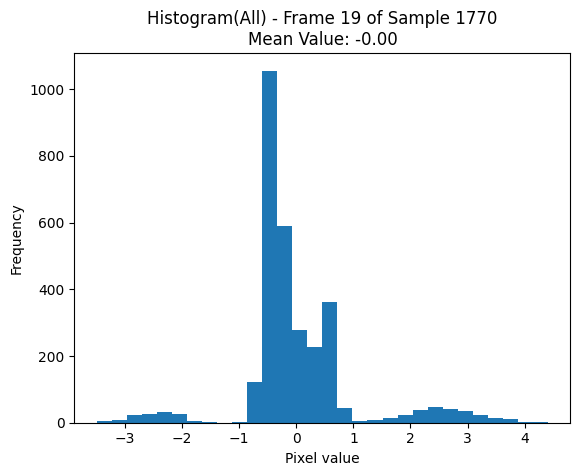

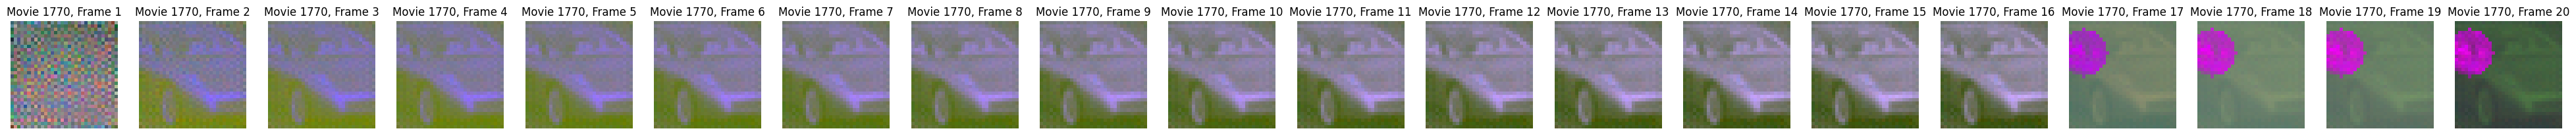

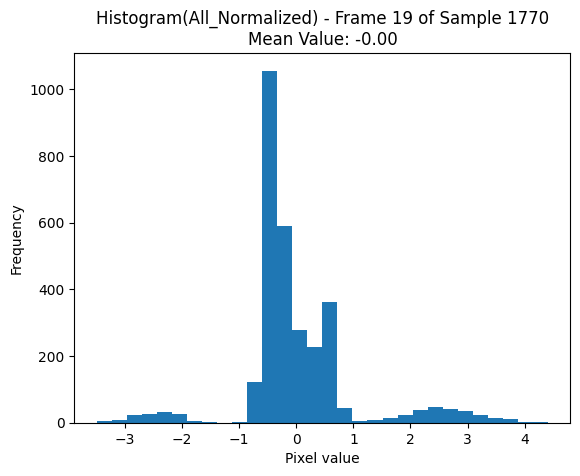

In [ ]:
# the index of the sample you want to display
sample_index = 1769
# the number of frames in each image
num_frames = 20


# loop through the frames and display each one separately (Red)

fig_r, axs_r = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_r[i].imshow(output_r[sample_index, i,:,:])
    axs_r[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_r[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_r[sample_index,frame_to_plot,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()



# loop through the frames and display each one separately (Green)

fig_g, axs_g = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_g[i].imshow(output_g[sample_index, i,:,:])
    axs_g[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_g[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_g[sample_index,frame_to_plot,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately (Blue)

fig_b, axs_b= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_b[i].imshow(output_b[sample_index, i,:,:])
    axs_b[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_b[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_b[sample_index,frame_to_plot,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately (Concatenation- Red)
fig_rc, axs_rc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_rc[i].imshow(output_con[sample_index, i,:,:,0])
    axs_rc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_rc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con[sample_index,frame_to_plot,:,:,0].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Con-Red)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately (Concatenation- Green)
fig_gc, axs_gc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_gc[i].imshow(output_con[sample_index, i,:,:,1])
    axs_gc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_gc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con[sample_index,frame_to_plot,:,:,1].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Con-Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()

# loop through the frames and display each one separately (Concatenation- Blue)
fig_bc, axs_bc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_bc[i].imshow(output_con[sample_index, i,:,:,2])
    axs_bc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_bc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con[sample_index,frame_to_plot,:,:,2].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Con-Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately (Concatenation- All colors)
fig_con, axs_con= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_con[i].imshow((output_con[sample_index, i,:,:,:]))
    axs_con[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_con[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram(All) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()

# loop through the frames and display each one separately (Concatenation_normalized- All colors)
fig_con_norm, axs_con_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_con_norm[i].imshow(normalize_image(output_con[sample_index, i,:,:,:]))
    axs_con_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_con_norm[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram(All_Normalized) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately (Stack- Red)
# fig_rstack, axs_rstack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_rstack[i].imshow(output_stack[sample_index, i,:,:,0])
#     axs_rstack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_rstack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack[sample_index,frame_to_plot,:,:,0].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Stack- Green)
# fig_gstack, axs_gstack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_gstack[i].imshow(output_stack[sample_index, i,:,:,1])
#     axs_gstack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_gstack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack[sample_index,frame_to_plot,:,:,1].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Stack- Blue)
# fig_bstack, axs_bstack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_bstack[i].imshow(output_stack[sample_index, i,:,:,2])
#     axs_bstack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_bstack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack[sample_index,frame_to_plot,:,:,2].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Stack- All colors)
# fig_stack, axs_stack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_stack[i].imshow(output_stack[sample_index, i,:,:,:])
#     axs_stack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_stack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack[sample_index,frame_to_plot,:,:,:].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-All)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()



# # loop through the frames and display each one separately (Normalized- red)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow(output_norm[sample_index, i,:,:,0])
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm[sample_index,frame_to_plot,:,:,0].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-Red)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()

# # loop through the frames and display each one separately (Normalized- Green)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow(output_norm[sample_index, i,:,:,1])
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm[sample_index,frame_to_plot,:,:,1].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-Green)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Normalized- Blue)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow(output_norm[sample_index, i,:,:,2])
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm[sample_index,frame_to_plot,:,:,2].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-Blue)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()

# # loop through the frames and display each one separately (Normalized- All)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow((output_norm[sample_index, i,:,:,:]))
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm[sample_index,frame_to_plot,:,:,:].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-All)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Normalized2- All)
# fig_norm2, axs_norm2= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm2[i].imshow(normalize_image(output_norm[sample_index, i,:,:,:]))
#     axs_norm2[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm2[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm[sample_index,frame_to_plot,:,:,:].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm2-All)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()

### **9.1.3: PR+ResNet50(RGB)-with the PR model**

In [ ]:
## PR+ CNN Model- CFAR10
from tensorflow.keras.layers import MaxPooling3D
## PR+ CNN Model- CFAR10

## ResNet Model
frame_num = 20
num_classes = 10
chan1_n=20
chanl_col=3

# there are 3 channels (RBG) and 20 frames
input_shape = (frame_num, 32, 32,chanl_col)

# define inputs tensor
inputs = Input(shape=input_shape)


# PR Architecture

# reshape the input to PR (frame_num=20, width*height*colour=3072)
y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]*inputs.shape [-3]))(inputs)
y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
# reshape the output of PR (frame_num=20, width=32, height=32, channel_num*colour=60)
y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-3],chan1_n*inputs.shape [-1]))(y1)
# # leave the first 5 frames
y1 = y1[:,:,:,:,:]

# Time series Layer Norm
# layer_norm=TimeDistributed(LayerNormalization(axis=[-3, -2, -1]))(y1)
# layer_norm=FrameLayerNorm()(y1)
layer_norm=LayerNormalization()(y1)


# # ResNet is designed for colour images, add a maxpooling layer

y1_reduced = Conv2D(filters=3, kernel_size=(1, 1), strides=(1, 1))(layer_norm)
y1_normalized = BatchNormalization()(y1_reduced )



# # ResNet50 base model (pre-trained model)
ResNet50_base = ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,chanl_col))


y2= TimeDistributed(ResNet50_base)(y1_normalized)
y2 = TimeDistributed(Flatten())(y2)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)


PR_out=(Model(inputs=inputs, outputs=y1))
PR_out_norm=(Model(inputs=inputs, outputs=layer_norm))
model5 = Model(inputs=inputs, outputs=y2)




In [ ]:
model5.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 32, 32, 3)]   0         
                                                                 
 reshape_2 (Reshape)         (None, 20, 3072)          0         
                                                                 
 photoreceptor_da_multichan_  (None, 20, 3072, 20)     440       
 randinit_1 (photoreceptor_D                                     
 A_multichan_randinit)                                           
                                                                 
 reshape_3 (Reshape)         (None, 20, 32, 32, 60)    0         
                                                                 
 tf.__operators__.getitem_1   (None, 20, 32, 32, 60)   0         
 (SlicingOpLambda)                                               
                                                           

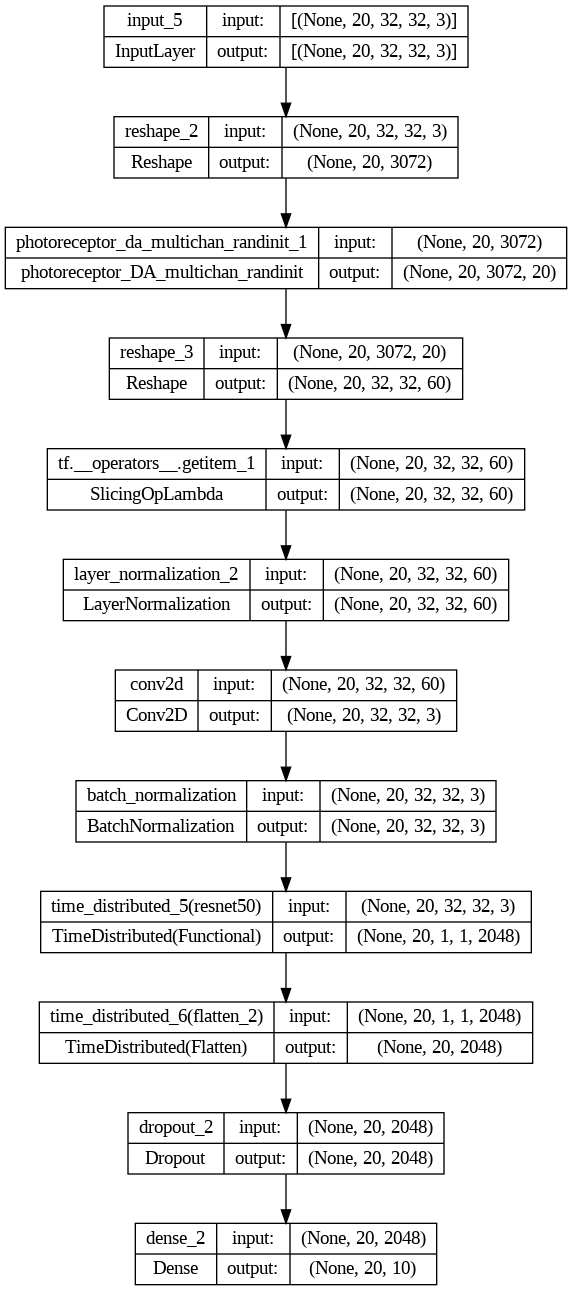

In [ ]:
# Plot the model for submodels_PR3
from keras.utils.vis_utils import plot_model
plot_model(model5, to_file='ResNet50+PR(RGB).png', show_shapes=True, show_layer_names=True)

#### **9.1.3.1: Compiling and Training**

In [ ]:
# # one label per frame
import os

n = 70
# initial_epoch=38
#
model5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_schedule(0)), metrics=['accuracy'])


# specify the path to save the model
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model5:ResNet50'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# load the weight for the last epoch
# model5.load_weights('/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model5:ResNet50/saved_models/cifar10_%s_model.039.h5')

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             save_weights_only=False,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


callbacks = [checkpoint, lr_reducer, lr_scheduler]


history5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n, #initial_epoch=initial_epoch,
                      validation_data=validation_generator, validation_steps=validation_steps,callbacks=callbacks,
                      verbose=1)

#### **9.1.3.2: Accuracy Plot**


In [ ]:
n1=70
dict_hist = history5.history # assuming you have already trained your model and stored the history object

list_ep = [i for i in range(1,n1+1)]

plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1) # adding a subplot for accuracy
plt.plot(list_ep, dict_hist['accuracy'],ls='--',label='accuracy-train_dataset')
plt.plot(list_ep, dict_hist['val_accuracy'],ls='--',label='accuracy-validation_dataset')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2) # adding a subplot for loss
plt.plot(list_ep, dict_hist['loss'],ls='--',label='loss-train_dataset')
plt.plot(list_ep, dict_hist['val_loss'],ls='--',label='loss-validation_dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

#### **9.1.3.3: Frame-Level Predictions**

In [ ]:

# import matplotlib.pyplot as plt
frame_num=20
num_movies_all_correct=np.zeros(20)
frame_accs=np.zeros(20)
mismatched_movies=[]

# Loop through each movie in the test set
for movie_idx, movie_data in enumerate(x_test_mask_movie):

    # labels
    movie_labels = (y_test_encoded[movie_idx])
    movie_labels = np.repeat(movie_labels, frame_num, axis=0)
    # label tensor and frames tensor
    movie_labels = movie_labels.reshape(frame_num, -1)

    # Predict the labels for each frame in the movieslack
    predicted_labels = model5.predict(movie_data.reshape(1, 20, 32, 32, 3))

    # Calculate the accuracy for each frame in the movie
    mismatch_found = False
    for frame_idx in range(20):
        frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
        frame_accs[frame_idx] += (frame_acc)


        # Repeat the label for each frame in the movie
        label = movie_labels[frame_idx]

        print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

    all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
    if all_correct:
        num_movies_all_correct += 1

# Print the number of movies where all frames match the labels
print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")

# Divide by the number of movies to get the mean accuracy for each frame
frame_accs /= len(x_test_mask_movie)

#### **9.1.3.4 :Visualizing the output of each layer**

In [ ]:
# Check the output of PR ( time series )
output_PR=PR_out.predict(x_test_mask_movie)
output_PR_norm=PR_out_norm.predict(x_test_mask_movie)

In [ ]:
import matplotlib.colors as colors
## output of the PR Model

# the index of the sample you want to display
sample_index = 1893
# the number of frames in each image
num_frames = 20


# plot the red channel before normalization layer
fig_Pr_r, axs_Pr_r = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Pr_r[i].imshow(output_PR[sample_index, i,:,:,0])
    axs_Pr_r[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Pr_r[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR[sample_index,frame_to_plot,:,:,0].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()



# plot the green channel before normalization layer
fig_Pr_g, axs_Pr_g = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Pr_g[i].imshow(output_PR[sample_index, i,:,:,1])
    axs_Pr_g[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Pr_g[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR[sample_index,frame_to_plot,:,:,1].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()



# plot the blue channel before normalization layer
fig_Pr_b, axs_Pr_b = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Pr_b[i].imshow((output_PR[sample_index, i,:,:,2]))
    axs_Pr_b[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Pr_b[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR[sample_index,frame_to_plot,:,:,2].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()




## plot all channels before normalization layer
fig_Pr, axs_Pr = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Pr[i].imshow(normalize_image(output_PR[sample_index, i,:,:,:]))
    axs_Pr[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Pr[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (All) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()







# plot the red channel after normalization layer
fig_Prn_r, axs_Prn_r = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Prn_r[i].imshow(output_PR_norm[sample_index, i,:,:,0])
    axs_Prn_r[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Prn_r[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm[sample_index,frame_to_plot,:,:,0].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# plot the green channel after normalization layer
fig_Prn_b, axs_Prn_b = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Prn_b[i].imshow(output_PR_norm[sample_index, i,:,:,1])
    axs_Prn_b[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Prn_b[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm[sample_index,frame_to_plot,:,:,1].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# plot the blue channel after normalization layer
fig_Prn_g, axs_Prn_g = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Prn_g[i].imshow(output_PR_norm[sample_index, i,:,:,2])
    axs_Prn_g[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Prn_g[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm[sample_index,frame_to_plot,:,:,2].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()



# plot all channels after normalization layer
fig_Prn, axs_Prn = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_Prn[i].imshow(normalize_image(output_PR_norm[sample_index, i,:,:,:]))
    axs_Prn[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_Prn[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (All) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()

#### **9.1.3.5 :Photoreceptor Parameters/Weight values**

In [40]:
# Weight values of PR Layer
weights, names=get_weightsDict(model5)
print(names)
s1=names[0]

print(s1)
substring1 = s1.split("/")[0]

layer_name_ch1=substring1
print(substring1)
W_L_ch1=get_weightsOfLayer(weights,layer_name_ch1)

print(W_L_ch1)
weights_ch1 = model5.layers[2].get_weights()
print(weights_ch1)


In [ ]:
# Maps the weight names to their indices
weight_name_to_index={}

weights = PR_out.layers[2].get_weights()
for i in range(len(weights)):
    print(f"Weight {i} name: {PR_out.layers[2].weights[i].name}")

weight_names = []
for i, weight in enumerate(weights):
    weight_name = PR_out.layers[2].weights[i].name
    weight_name = weight_name.split("/")[-1]  # Get the substring after the last slash
    weight_name = weight_name.split(":")[0]  # Get the substring before the colon
    weight_names.append(weight_name)

for i, weight_name in enumerate(weight_names):
  weight_name_to_index[weight_name]=i


## **9.2: Untrained ResNet20 Model**





In [ ]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar100,cifar10
import numpy as np
import os


# Training parameters
batch_size = 128  # didn't use their data generator
epochs = 70
# cifar10
num_classes = 10



# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------

n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


# Learning rate schedule (with 200 epochs)
# def lr_schedule(epoch):
#     """Learning Rate Schedule

#     Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
#     Called automatically every epoch as part of callbacks during training.

#     # Arguments
#         epoch (int): The number of epochs

#     # Returns
#         lr (float32): learning rate
#     """
#     lr = 1e-3

#     if epoch > 180:
#         lr *= 0.5e-3
#     elif epoch > 160:
#         lr *= 1e-3
#     elif epoch > 120:
#         lr *= 1e-2
#     elif epoch > 80:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr



def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    # lr = 1e-4
    lr = 1e-3
    if epoch > 140:
        lr *= 1e-4
        #0.5e-3
    elif epoch > 100:
        lr *= 1e-3
        #1e-3
    elif epoch > 50:
        lr *= 1e-2
        #1e-2
    elif epoch > 20:
        lr *= 1e-1
        #1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16, #16
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

# there are 10 clases for CIFAR-10)
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # Normalizatio Layer
    # norm_input=LayerNormalization()(inputs)

    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    # outputs = Dense(num_classes,
    #                 activation='softmax',
    #                 kernel_initializer='he_normal')(y)
    outputs = y

    # Instantiate model.
    resnet_v2 = Model(inputs=inputs, outputs=outputs)
    return resnet_v2

### **9.2.1: ReNet20+PR(RGB)**

In [ ]:
# number of frames of the input movies
frame_num = 20

# there are 10 classes for CIFAR-10 and 100 for CIFAR-100
num_classes = 10

# Depth should be computed using the above table
depth=20

# number of channel of the PR model
chan1_n=1

# color channels ( CIFAR=3, MNIST=1)
chanl_col=3

# Input shape for 20 channels
#input_shape_res=(32, 32, 60)

# Input shape for 1 channel
input_shape_res=(32, 32, 3)


# there are 3 channels (RBG) and 20 frames
input_shape = (frame_num, 32, 32,chanl_col)

# define inputs tensor
inputs = Input(shape=input_shape)




# PR Architecture
# reshape the input to PR (frame_num=20, width*height*colour=3072)
y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]*inputs.shape [-3]))(inputs )
y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
# reshape the output of PR (frame_num=20, width=32, height=32, channel_num*colour=60)
y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-3],chan1_n*inputs.shape [-1]))(y1)
# To eliminate the edge effect, you can start from frame 5:
# y1[index, frames, height, width, channels]
y1 = y1[:,:,:,:,:]


# # Layer Norm: Not distributed over time and time distributed

# layer_norm = LayerNormalization(axis=-1)(y1)
layer_norm=TimeDistributed(LayerNormalization(axis=[-3, -2, -1]))(y1)


# # ResNet20 base model
ResNet20_image = resnet_v2(input_shape_res, depth, num_classes)

# # input layer ( movie)
# input_layer = Input(shape=movie_input_shape)

# ResNet20 base model with TimeDistributed layer
resnet_td = TimeDistributed(ResNet20_image)(layer_norm)
y2 = TimeDistributed(Flatten())(resnet_td)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

# outputs ( for visualization)
PR_out20= Model(inputs=inputs, outputs=y1)
PR_out_norm20=Model(inputs=inputs, outputs=layer_norm)
model2 = Model(inputs=inputs, outputs=y2)



In [ ]:
ResNet20_image.summary()
# To reduce the font size
html_style = "<style>.text_cell_render {font-size: 2%;}</style>"
display(HTML(html_style))
display(ResNet20_image.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

None

In [ ]:
# Plot the model for submodels_PR3
from keras.utils.vis_utils import plot_model
plot_model(ResNet20_image, to_file='Model #3.png', show_shapes=True, show_layer_names=True)

#### **9.2.1.1: Compiling and Training**


In [ ]:
# Compile the model



model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])


# Prepare model model saving directory. ( It saves every epoch)
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3:DynamicCoding/Nilou_Codes/CIFAR10/Model2:ResNet20'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)



# Load weight values (you can start it from initial_epoch)
#initial_epoch=69
#model2.load_weights('/content/drive/MyDrive/PhD-Nilou/Project#3:DynamicCoding/Nilou_Codes/CIFAR10/Model2:ResNet20/saved_models/cifar10_ResNet20v2_model.070.h5')

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,#initial_epoch=initial_epoch,
                      validation_data=validation_generator, validation_steps=validation_steps,
                      verbose=1, workers=1,
                        callbacks=callbacks)



Learning rate:  0.001
Learning rate:  1e-05
Epoch 70/70
625/625 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8812
Epoch 70: saving model to /content/drive/MyDrive/PhD-Nilou/Project#3:DynamicCoding/Nilou_Codes/CIFAR10/Model2:ResNet20/saved_models/cifar10_ResNet20v2_model.070.h5
625/625 [==============================] - 62s 53ms/step - loss: 0.5236 - accuracy: 0.8812 - val_loss: 1.4236 - val_accuracy: 0.6555 - lr: 1.0000e-05


#### **9.2.1.2:Accuracy Plot**

In [ ]:
n1=70
dict_hist = history2.history # assuming you have already trained your model and stored the history object

list_ep = [i for i in range(1,n1+1)]

plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1) # adding a subplot for accuracy
plt.plot(list_ep, dict_hist['accuracy'],ls='--',label='accuracy-train_dataset')
plt.plot(list_ep, dict_hist['val_accuracy'],ls='--',label='accuracy-validation_dataset')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2) # adding a subplot for loss
plt.plot(list_ep, dict_hist['loss'],ls='--',label='loss-train_dataset')
plt.plot(list_ep, dict_hist['val_loss'],ls='--',label='loss-validation_dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

#### **9.2.1.3:Frame-Level Prediction**

In [ ]:
# convert to one-hot encoded
# y_test_encoded=np.argmax(y_test,axis=1)

# Number of frames in each movie
frame_num=20

# number of movies that all the predicted labels match the actual labels
num_movies_all_correct=np.zeros(20)
frame_accs=np.zeros(20)
mismatched_movies=[]

# Loop through each movie in the test set
for movie_idx, movie_data in enumerate(x_test_mask_movie):

    # labels
    movie_labels = (y_test_encoded[movie_idx])
    movie_labels = np.repeat(movie_labels, frame_num, axis=0)

    # label tensor and frames tensor
    movie_labels = movie_labels.reshape(frame_num, -1)

    # Predict the labels for each frame in the movieslack
    predicted_labels = model2.predict(movie_data.reshape(1, 20, 32, 32, 3))

    # Calculate the accuracy for each frame in the movie
    mismatch_found = False
    for frame_idx in range(20):
        frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
        frame_accs[frame_idx] += (frame_acc)


        # Repeat the label for each frame in the movie
        label = movie_labels[frame_idx]

        print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")



    # all the labels in each movie
    all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
    if all_correct:
        num_movies_all_correct += 1

# Print the number of movies where all frames match the labels (actual labels=predicted labels)
print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")

# Divide by the number of movies to get the mean accuracy for each frame
frame_accs /= len(x_test_mask_movie)

Streaming output truncated to the last 5000 lines.
Movie 9762, Frame 20 Accuracy: [False],predicted_label:2, actual label:[5]
1/1 [==============================] - 0s 27ms/step
Movie 9763, Frame 1 Accuracy: [False],predicted_label:3, actual label:[6]
Movie 9763, Frame 2 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 3 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 4 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 5 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 6 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 7 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 8 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 9 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 10 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 9763, Frame 11 Accuracy: [ True],predicted_label:6, actual label:[6]
Movie 

#### **9.2.1.4:Visualizing the output of each layer**

In [ ]:
# Output of different layers
output_PR20=PR_out20.predict(x_test_mask_movie)
output_PR_norm20=PR_out_norm20.predict(x_test_mask_movie)

313/313 [==============================] - 2s 4ms/step


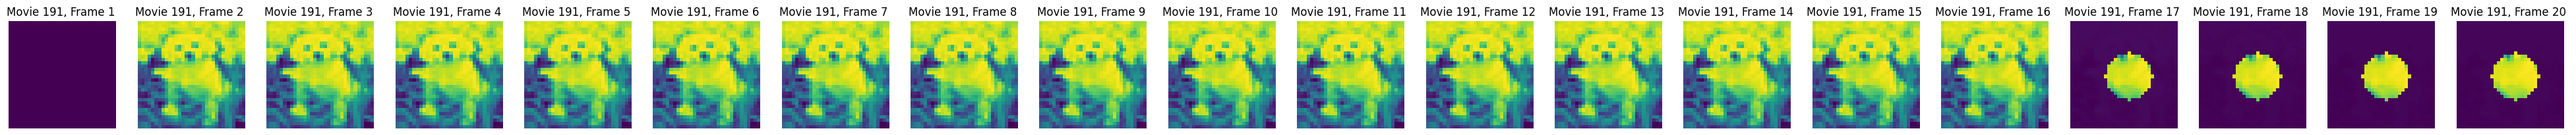

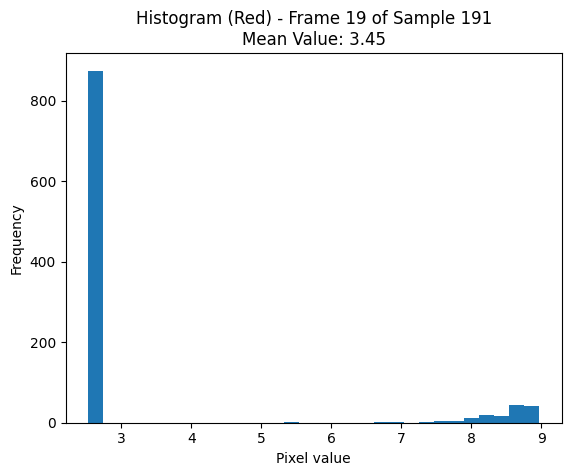

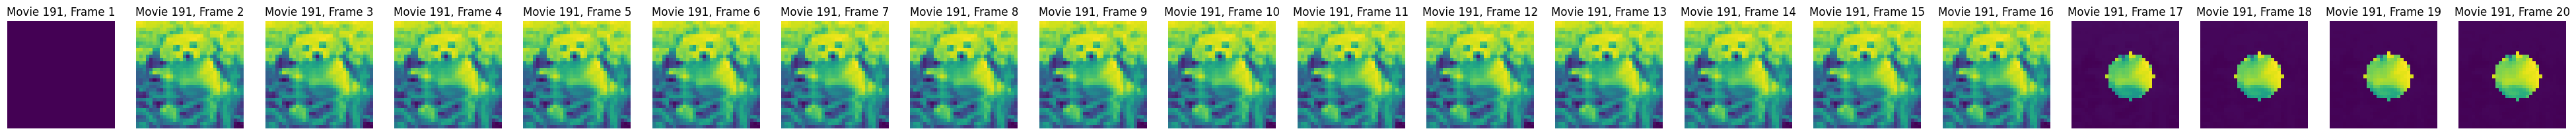

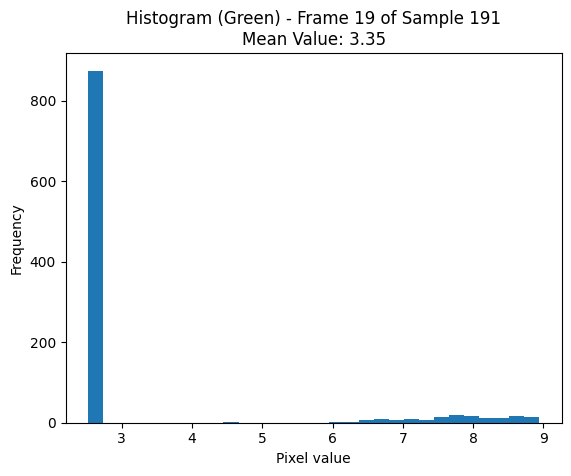

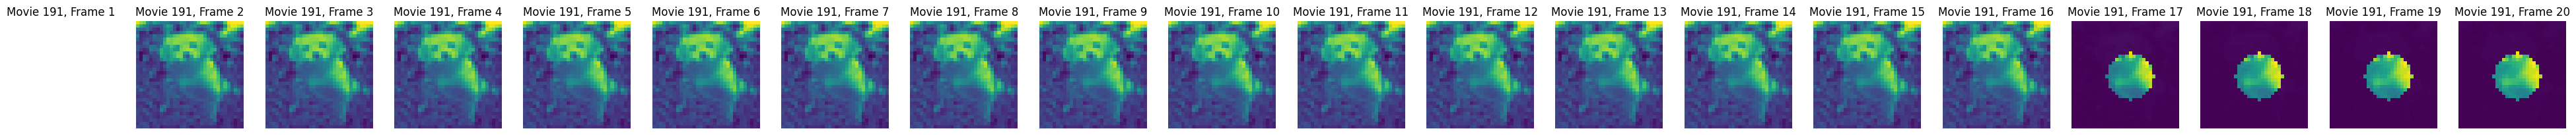

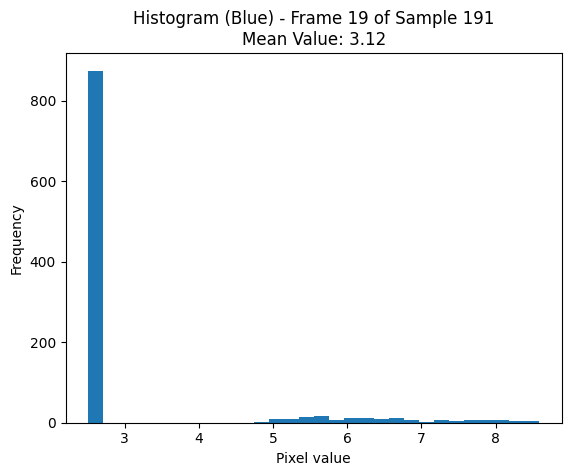

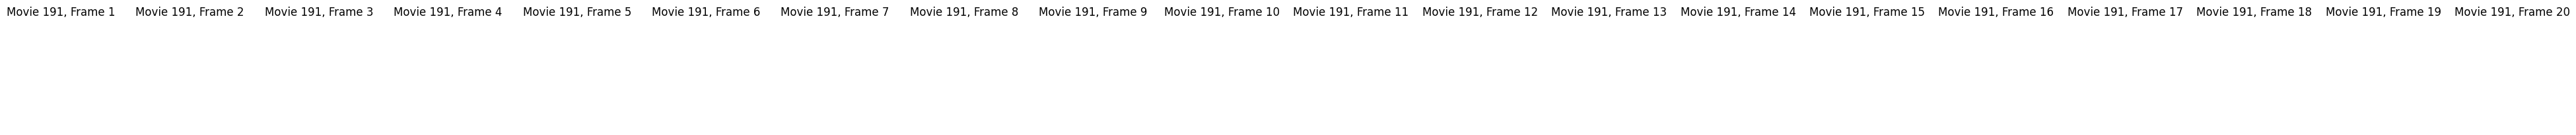

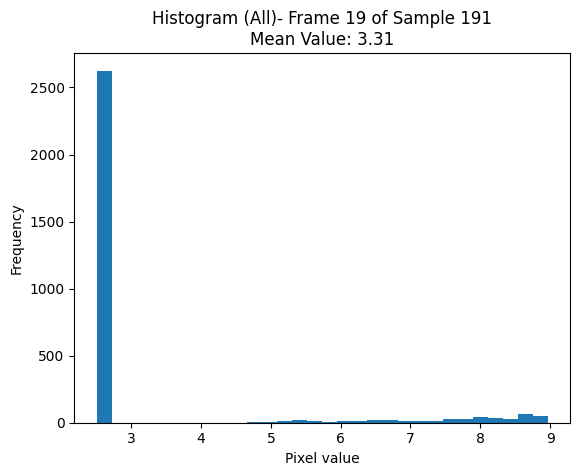

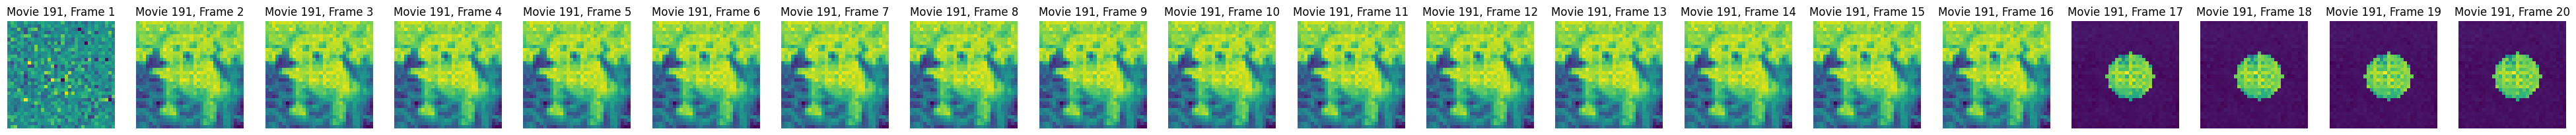

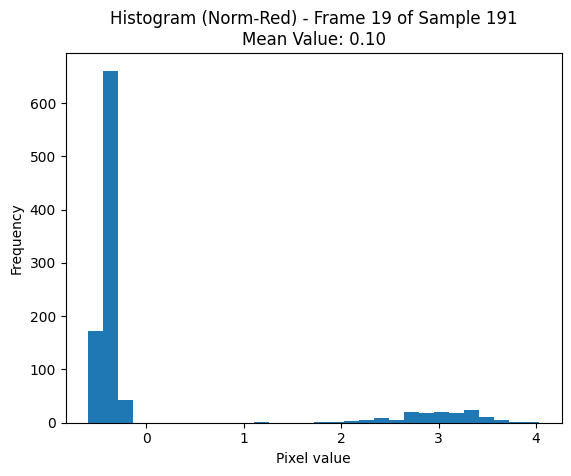

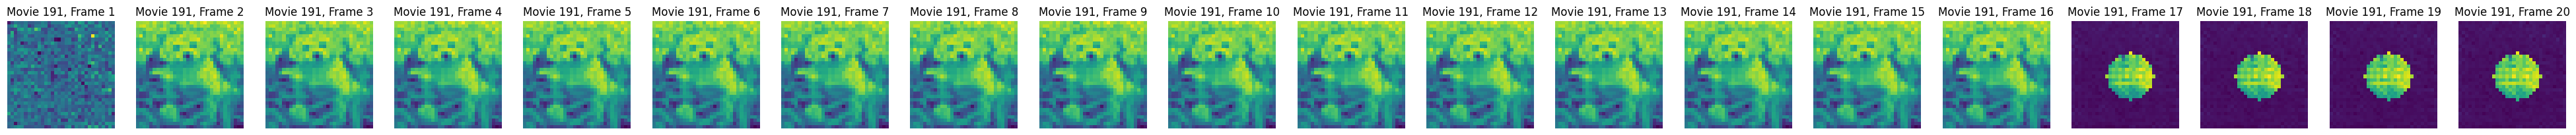

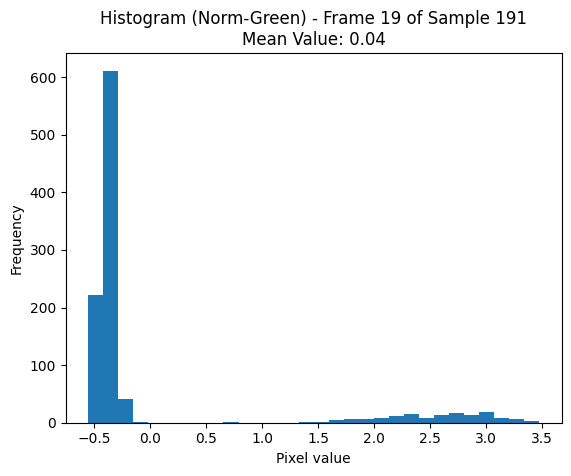

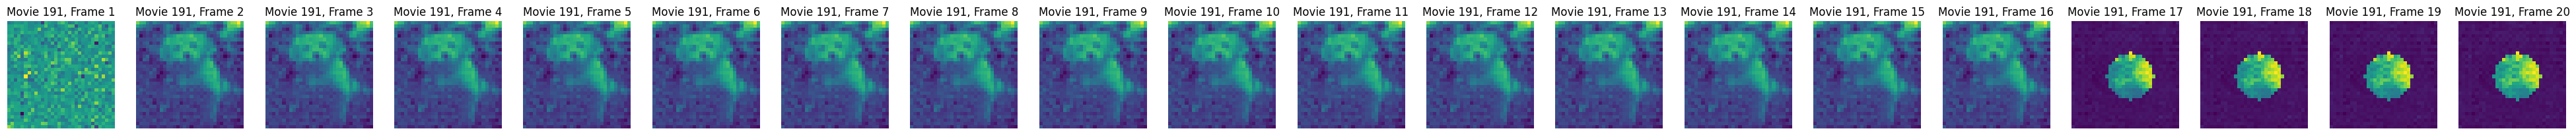

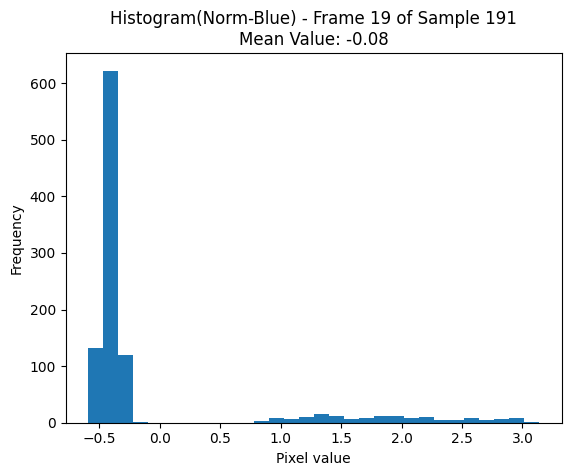

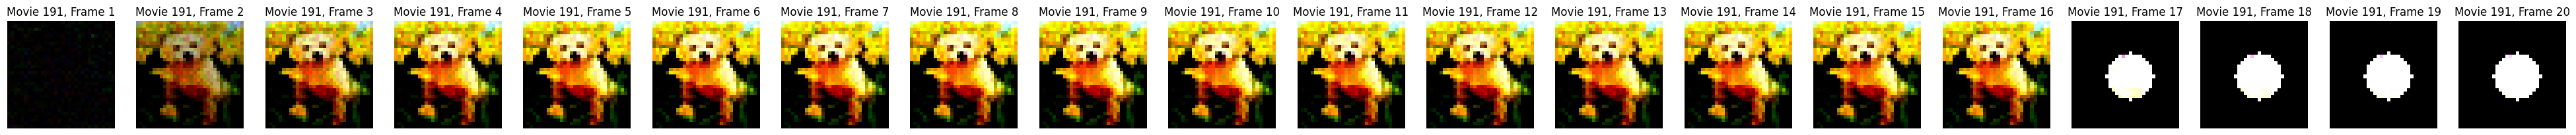

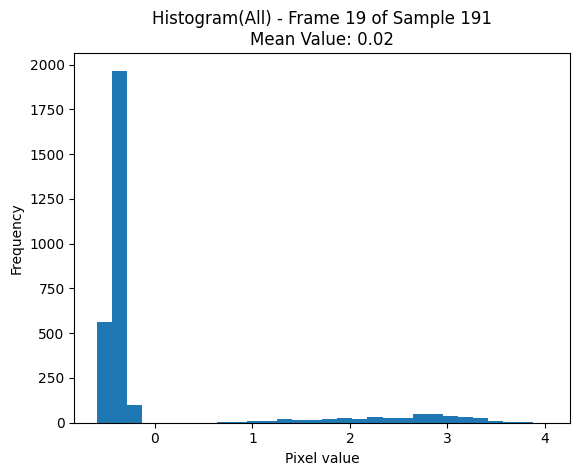

In [ ]:
# the index of the sample you want to display
sample_index =190
# the number of frames in each image
num_frames = 20


# loop through the frames and display each one separately-the output of PR before LayerNorm (Red)

fig_r, axs_r = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_r[i].imshow((output_PR20[sample_index, i,:,:,0]))
    axs_r[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_r[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR20[sample_index,frame_to_plot,:,:,0].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()



# loop through the frames and display each one separately -the output of PR before LayerNorm(Green)

fig_g, axs_g = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_g[i].imshow((output_PR20[sample_index, i,:,:,1]))
    axs_g[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_g[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR20[sample_index,frame_to_plot,:,:,1].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately-the output of PR before LayerNorm (Blue)

fig_b, axs_b= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_b[i].imshow(normalize_image(output_PR20[sample_index, i,:,:,2]))
    axs_b[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_b[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR20[sample_index,frame_to_plot,:,:,2].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()

factor=1
# loop through the frames and display each one separately -the output of PR before LayerNorm(Concatenation- All)
fig_rc, axs_rc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_rc[i].imshow((output_PR20[sample_index, i,:,:,:])*factor)
    axs_rc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_rc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR20[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (All)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()






# loop through the frames and display each one separately -the output of PR after LayerNorm(Normalization- Red)
fig_gc, axs_gc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_gc[i].imshow(output_PR_norm20[sample_index, i,:,:,0])
    axs_gc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_gc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm20[sample_index,frame_to_plot,:,:,0].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Norm-Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()




# loop through the frames and display each one separately -the output of PR after LayerNorm(Concatenation- Green)
fig_bc, axs_bc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_bc[i].imshow(output_PR_norm20[sample_index, i,:,:,1])
    axs_bc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_bc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm20[sample_index,frame_to_plot,:,:,1].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Norm-Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately -the output of PR after LayerNorm(Concatenation- All colors)
fig_con, axs_con= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_con[i].imshow(output_PR_norm20[sample_index, i,:,:,2])
    axs_con[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_con[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm20[sample_index,frame_to_plot,:,:,2].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram(Norm-Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()




# loop through the frames and display each one separately -the output of PR after LayerNorm(Norm- all)
fig_rstack, axs_rstack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_rstack[i].imshow((output_PR_norm20[sample_index, i,:,:,:]))
    axs_rstack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_rstack[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_PR_norm20[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram(All) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()



#### **9.2.1.5: Photoreceptor Parameters/Weight values**

In [ ]:
# Weight values of PR Layer
# Weight values of PR Layer
weights, names=get_weightsDict(model2)
print(names)
s1=names[0]
print(s1)
substring1 = s1.split("/")[0]

layer_name_ch1=substring1
print(substring1)

W_L_ch1=get_weightsOfLayer(weights,layer_name_ch1)

print(W_L_ch1)

['photoreceptor_da_multichan_randinit_6/zeta:0', 'photoreceptor_da_multichan_randinit_6/kappa:0', 'photoreceptor_da_multichan_randinit_6/alpha:0', 'photoreceptor_da_multichan_randinit_6/beta:0', 'photoreceptor_da_multichan_randinit_6/gamma:0', 'photoreceptor_da_multichan_randinit_6/tauY:0', 'photoreceptor_da_multichan_randinit_6/nY:0', 'photoreceptor_da_multichan_randinit_6/tauZ:0', 'photoreceptor_da_multichan_randinit_6/nZ:0', 'photoreceptor_da_multichan_randinit_6/tauC:0', 'photoreceptor_da_multichan_randinit_6/zeta_mulFac:0', 'photoreceptor_da_multichan_randinit_6/kappa_mulFac:0', 'photoreceptor_da_multichan_randinit_6/alpha_mulFac:0', 'photoreceptor_da_multichan_randinit_6/beta_mulFac:0', 'photoreceptor_da_multichan_randinit_6/gamma_mulFac:0', 'photoreceptor_da_multichan_randinit_6/tauY_mulFac:0', 'photoreceptor_da_multichan_randinit_6/nY_mulFac:0', 'photoreceptor_da_multichan_randinit_6/tauZ_mulFac:0', 'photoreceptor_da_multichan_randinit_6/nZ_mulFac:0', 'photoreceptor_da_multicha

### **9.2.2: ResNet20+PR(R+G+B)**

In [ ]:
## PR+ResNet20
# In this model each color channel is processed independently

frame_num = 20
num_classes = 10
chan1_n=1
chanl_col=3

input_shape_res=(32, 32, 3)

# for 20 channels
# input_shape_res=(32, 32, 60)

input_shape = (20, 32, 32)
inputs = Input(shape=input_shape)

input_layer = Input(shape=(frame_num, 32, 32, 3))



output=[]

for i in range(chanl_col):


    # Split the channels
    channel_input = Lambda(lambda x: x[..., i:i+1])(input_layer)
    # squeezed_inputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(channel_input)


    # PR Architecture
    y1 = Reshape((inputs.shape [1],inputs.shape [-2]*inputs.shape [-1]))(channel_input)
    y1 = photoreceptor_DA_multichan_randinit(units=chan1_n,kernel_regularizer=l2(1e-4))(y1)
    y1 = Reshape((inputs.shape[1],inputs.shape[-2],inputs.shape[-1],chan1_n))(y1)
    y1 = y1[:,:,:,:,:]

    #y1_norm = TimeDistributed(LayerNormalization(axis=[-3, -2]))(y1)
    output.append(y1)

# Red Channel
ch_r20=output[0]
# Green Channel
ch_g20=output[1]
# Blue Channel
ch_b20=output[2]


# Combine the color channels
# Method #1: Concatenate about the last axis
merged_channels20=Concatenate(axis=-1)([ch_r20, ch_g20, ch_b20])


# Normalization layer: Not distributed over time and time distributed ( either apply the layernorm here or after the input layer in resnet_ve2 model)
# layer_norm20=LayerNormalization()(merged_channels20)
layer_norm20=TimeDistributed(LayerNormalization(axis=[-3, -2]))(merged_channels20)


# Method # 2: Stacking the output
# Stack the last axis
output_stack20 = tf.stack(output, axis=-2)
# Reshape the output
reshaped_output20 = tf.reshape(output_stack20, shape=(-1, frame_num, 32, 32, chanl_col))

# # ResNet20 base model
ResNet20_image = resnet_v2(input_shape_res, depth, num_classes)


# ResNet20 base model with TimeDistributed layer
resnet_td = TimeDistributed(ResNet20_image)(layer_norm20)
y2 = TimeDistributed(Flatten())(resnet_td)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

# Outputs

# Different colors
red20=(Model(inputs=input_layer, outputs=ch_r20))
green20=(Model(inputs=input_layer, outputs=ch_g20))
blue20=(Model(inputs=input_layer, outputs=ch_b20))

# Concatenation
concat20=(Model(inputs=input_layer, outputs=merged_channels20))

# Stacking
stack20=(Model(inputs=input_layer, outputs=reshaped_output20))

# Normalization
norm20=(Model(inputs=input_layer, outputs=layer_norm20))

# Final Model
model4 = Model(inputs=input_layer, outputs=y2)

In [ ]:
# Plot the model for
from keras.utils.vis_utils import plot_model
plot_model(model4, to_file='Model #4.png', show_shapes=True, show_layer_names=True)

#### ***9.2.2.1: Compiling and Training***

In [ ]:
# Compile the model



model4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])



# Prepare model model saving directory.
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model4:ResNet20'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


# start from initial_epoch
#initial_epoch=69
# model4.load_weights('/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/CFAR10/Model4:ResNet20/saved_models/cifar10_ResNet20v2_model.070.h5')


# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

history4 = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, #initial_epoch=initial_epoch,
                      validation_data=validation_generator, validation_steps=validation_steps,
                      verbose=1, workers=1,
                        callbacks=callbacks)


#### **9.2.2.2: Accuracy Plot**

In [ ]:
n1=70
dict_hist = history4.history # assuming you have already trained your model and stored the history object

list_ep = [i for i in range(1,n1+1)]

plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1) # adding a subplot for accuracy
plt.plot(list_ep, dict_hist['accuracy'],ls='--',label='accuracy-train_dataset')
plt.plot(list_ep, dict_hist['val_accuracy'],ls='--',label='accuracy-validation_dataset')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2) # adding a subplot for loss
plt.plot(list_ep, dict_hist['loss'],ls='--',label='loss-train_dataset')
plt.plot(list_ep, dict_hist['val_loss'],ls='--',label='loss-validation_dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

#### **9.2.2.3:Frame_Level Prediction**

In [ ]:
# convert to one-hot encoded
# y_test=np.argmax(y_test,axis=1)



# import matplotlib.pyplot as plt
frame_num=20
num_movies_all_correct=np.zeros(20)
frame_accs=np.zeros(20)
mismatched_movies=[]

# Loop through each movie in the test set
for movie_idx, movie_data in enumerate(x_test_mask_movie):

    # labels
    movie_labels = (y_test_encoded[movie_idx])
    movie_labels = np.repeat(movie_labels, frame_num, axis=0)
    # label tensor and frames tensor
    movie_labels = movie_labels.reshape(frame_num, -1)

    # Predict the labels for each frame in the movieslack
    predicted_labels = model4.predict(movie_data.reshape(1, 20, 32, 32,3))

    # Calculate the accuracy for each frame in the movie
    mismatch_found = False
    for frame_idx in range(20):
        frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
        frame_accs[frame_idx] += (frame_acc)


        # Repeat the label for each frame in the movie
        label = movie_labels[frame_idx]

        print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

    all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
    if all_correct:
        num_movies_all_correct += 1

# Print the number of movies where all frames match the labels
print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")

# Divide by the number of movies to get the mean accuracy for each frame
frame_accs /= len(x_test_mask_movie)

#### **9.2.2.4: Visualize the output of each layer**

In [ ]:
# Output of different layers
output_r20=red20.predict(x_test_mask_movie)
output_g20=green20.predict(x_test_mask_movie)
output_b20=blue20.predict(x_test_mask_movie)
output_con20=concat20.predict(x_test_mask_movie)
output_stack20=stack20.predict(x_test_mask_movie)
# output_norm20=norm20.predict(x_test_mask_movie)

In [ ]:
# the index of the sample you want to display
sample_index = 460
# the number of frames in each image
num_frames = 20


# loop through the frames and display each one separately- each color before concatenation (Red)

fig_r, axs_r = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_r[i].imshow(output_r20[sample_index, i,:,:])
    axs_r[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1} ")
    axs_r[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_r20[sample_index,frame_to_plot,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()



# loop through the frames and display each one separately- each color before concatenation (Green)

fig_g, axs_g = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_g[i].imshow(output_g20[sample_index, i,:,:])
    axs_g[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_g[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_g20[sample_index,frame_to_plot,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately - each color before concatenation(Blue)

fig_b, axs_b= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_b[i].imshow(output_b20[sample_index, i,:,:])
    axs_b[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_b[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_b20[sample_index,frame_to_plot,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately - each color after concatenation(Concatenation- Red)
fig_rc, axs_rc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_rc[i].imshow(output_con20[sample_index, i,:,:,0])
    axs_rc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_rc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con20[sample_index,frame_to_plot,:,:,0].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Con-Red)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately - each color after concatenation(Concatenation- Green)
fig_gc, axs_gc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_gc[i].imshow(output_con20[sample_index, i,:,:,1])
    axs_gc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_gc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con20[sample_index,frame_to_plot,:,:,1].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Con-Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()

# loop through the frames and display each one separately - each color after concatenation(Concatenation- Blue)
fig_bc, axs_bc= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

for i in range(num_frames):
    axs_bc[i].imshow(output_con20[sample_index, i,:,:,2])
    axs_bc[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_bc[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con20[sample_index,frame_to_plot,:,:,2].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram (Con-Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()


# loop through the frames and display each one separately - all colors after concatenation(Concatenation- All colors)
fig_con, axs_con= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
for i in range(num_frames):
    axs_con[i].imshow((output_con20[sample_index, i,:,:,:]))
    axs_con[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
    axs_con[i].axis('off')

plt.show()

frame_to_plot=18
hist_data=output_con20[sample_index,frame_to_plot,:,:,:].flatten()
plt.hist(hist_data, bins=30)
Mean_train=np.mean(hist_data)
plt.title(f"Histogram(All) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
plt.xlabel('Pixel value')
plt.ylabel('Frequency')


plt.show()




# loop through the frames and display each one separately (Stack- Red)
# fig_rstack, axs_rstack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_rstack[i].imshow(output_stack20[sample_index, i,:,:,0])
#     axs_rstack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_rstack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack20[sample_index,frame_to_plot,:,:,0].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-Red) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Stack- Green)
# fig_gstack, axs_gstack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_gstack[i].imshow(output_stack20[sample_index, i,:,:,1])
#     axs_gstack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_gstack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack20[sample_index,frame_to_plot,:,:,1].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-Green) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Stack- Blue)
# fig_bstack, axs_bstack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_bstack[i].imshow(output_stack20[sample_index, i,:,:,2])
#     axs_bstack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_bstack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack20[sample_index,frame_to_plot,:,:,2].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-Blue) - Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Stack- All colors)
# fig_stack, axs_stack= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_stack[i].imshow(output_stack20[sample_index, i,:,:,:])
#     axs_stack[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_stack[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_stack20[sample_index,frame_to_plot,:,:,:].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Stack-All)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()



# # loop through the frames and display each one separately (Normalized- red)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow(output_norm20[sample_index, i,:,:,0])
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm20[sample_index,frame_to_plot,:,:,0].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-Red)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()

# # loop through the frames and display each one separately (Normalized- Green)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow(output_norm20[sample_index, i,:,:,1])
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm20[sample_index,frame_to_plot,:,:,1].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-Green)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()


# # loop through the frames and display each one separately (Normalized- Blue)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow(output_norm20[sample_index, i,:,:,2])
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm20[sample_index,frame_to_plot,:,:,2].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-Blue)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()

# # loop through the frames and display each one separately (Normalized- Blue)
# fig_norm, axs_norm= plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})
# for i in range(num_frames):
#     axs_norm[i].imshow((output_norm20[sample_index, i,:,:,:]))
#     axs_norm[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs_norm[i].axis('off')

# plt.show()

# frame_to_plot=18
# hist_data=output_norm20[sample_index,frame_to_plot,:,:,:].flatten()
# plt.hist(hist_data, bins=30)
# Mean_train=np.mean(hist_data)
# plt.title(f"Histogram(Norm-All)- Frame {frame_to_plot + 1} of Sample {sample_index + 1}\nMean Value: {Mean_train:.2f}")
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')


# plt.show()

#### **9.2.2.5: Photoreceptor Parameters/Weight values**

In [ ]:
# Weight values of PR Layer
weights, names=get_weightsDict(model4)
print(names)
s1=names[0]
s2=names[22]
s3=names[44]
print(s1)
print(s2)
print(s3)

substring1 = s1.split("/")[0]
substring2 = s2.split("/")[0]
substring3 = s3.split("/")[0]
layer_name_ch1=substring1
layer_name_ch2=substring2
layer_name_ch3=substring3

print(substring1)
print(substring2)
print(substring3)

W_L_ch1=get_weightsOfLayer(weights,layer_name_ch1)
W_L_ch2=get_weightsOfLayer(weights,layer_name_ch2)
W_L_ch3=get_weightsOfLayer(weights,layer_name_ch3)
print(W_L_ch1)
print(W_L_ch2)
print(W_L_ch3)



### **9.2.3: Untrained ResNet20-without PR model**

In [ ]:
## PR+ResNet20

frame_num = 20
num_classes = 10
chan1_n=1
chanl_col=3

input_shape_res=(32, 32, 3)

# for 20 channels
# input_shape_res=(32, 32, 60)

input_shape = (20, 32, 32)

inputs = Input(shape=input_shape)

input_layer = Input(shape=(frame_num, 32, 32, 3))



# # ResNet20 base model
ResNet20_image = resnet_v2(input_shape_res, depth, num_classes)


# ResNet20 base model with TimeDistributed layer
# layer_norm20=TimeDistributed(LayerNormalization(axis=[-3,-2,-1]))(input_layer)
resnet_td = TimeDistributed(ResNet20_image)(input_layer )
y2 = TimeDistributed(Flatten())(resnet_td)
y2 = keras.layers.Dropout(0.5)(y2)
y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)


# Final Model
model6 = Model(inputs=input_layer, outputs=y2)

In [ ]:
# Plot the model for
from keras.utils.vis_utils import plot_model
plot_model(model6, to_file='Model #4.png', show_shapes=True, show_layer_names=True)

#### **9.2.3.1: Compiling and Training**

In [ ]:
# Compile the model



model6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])


# Prepare model model saving directory.
save_path='/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CFAR10/Model6:ResNet20'
save_dir = os.path.join(save_path, 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


# you can start from initial epoch
# initial_epoch=216
# model4.load_weights('')

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

history6 = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, #initial_epoch=initial_epoch,
                      validation_data=validation_generator, validation_steps=validation_steps,
                      verbose=1, workers=1,
                        callbacks=callbacks)


#### **9.2.3.2: Accuracy Plot**

In [ ]:
n1=70
dict_hist = history6.history # assuming you have already trained your model and stored the history object

list_ep = [i for i in range(1,n1+1)]

plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1) # adding a subplot for accuracy
plt.plot(list_ep, dict_hist['accuracy'],ls='--',label='accuracy-train_dataset')
plt.plot(list_ep, dict_hist['val_accuracy'],ls='--',label='accuracy-validation_dataset')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2) # adding a subplot for loss
plt.plot(list_ep, dict_hist['loss'],ls='--',label='loss-train_dataset')
plt.plot(list_ep, dict_hist['val_loss'],ls='--',label='loss-validation_dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()

#### **9.2.3.3: Frame-level predictions**

In [ ]:
frame_num=20
num_movies_all_correct=np.zeros(20)
frame_accs=np.zeros(20)
mismatched_movies=[]

# Loop through each movie in the test set
for movie_idx, movie_data in enumerate(x_test_mask_movie):

    # labels
    movie_labels = (y_test_encoded[movie_idx])
    movie_labels = np.repeat(movie_labels, frame_num, axis=0)
    # label tensor and frames tensor
    movie_labels = movie_labels.reshape(frame_num, -1)

    # Predict the labels for each frame in the movieslack
    predicted_labels = model6.predict(movie_data.reshape(1, 20, 32, 32, 3))

    # Calculate the accuracy for each frame in the movie
    mismatch_found = False
    for frame_idx in range(20):
        frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
        frame_accs[frame_idx] += (frame_acc)


        # Repeat the label for each frame in the movie
        label = movie_labels[frame_idx]

        print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

    all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
    if all_correct:
        num_movies_all_correct += 1

# Print the number of movies where all frames match the labels
print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")

# Divide by the number of movies to get the mean accuracy for each frame
frame_accs /= len(x_test_mask_movie)

# **10. Photoreceptor Model Parameter Optimization**


## **10.1: RMS_ResNet50+PR(R+G+B)**

###**10.1.1: Map Weight Names to Their Indices**

In [ ]:
# Map weight names to their indices
weight_name_to_index={}

# update the layer of the PR model (ResNet50+PR(R+B+G)=concat)
weights =  concat.layers[7].get_weights()
for i in range(len(weights)):
    print(f"Weight {i} name: { concat.layers[7].weights[i].name}")

weight_names = []
for i, weight in enumerate(weights):
    weight_name =  concat.layers[7].weights[i].name
    # Get the substring after the last slash
    weight_name = weight_name.split("/")[-1]
    # Get the substring before the colon
    weight_name = weight_name.split(":")[0]
    weight_names.append(weight_name)

for i, weight_name in enumerate(weight_names):
  weight_name_to_index[weight_name]=i

Weight 0 name: photoreceptor_da_multichan_randinit/zeta:0
Weight 1 name: photoreceptor_da_multichan_randinit/kappa:0
Weight 2 name: photoreceptor_da_multichan_randinit/alpha:0
Weight 3 name: photoreceptor_da_multichan_randinit/beta:0
Weight 4 name: photoreceptor_da_multichan_randinit/gamma:0
Weight 5 name: photoreceptor_da_multichan_randinit/tauY:0
Weight 6 name: photoreceptor_da_multichan_randinit/nY:0
Weight 7 name: photoreceptor_da_multichan_randinit/tauZ:0
Weight 8 name: photoreceptor_da_multichan_randinit/nZ:0
Weight 9 name: photoreceptor_da_multichan_randinit/tauC:0
Weight 10 name: photoreceptor_da_multichan_randinit/zeta_mulFac:0
Weight 11 name: photoreceptor_da_multichan_randinit/kappa_mulFac:0
Weight 12 name: photoreceptor_da_multichan_randinit/alpha_mulFac:0
Weight 13 name: photoreceptor_da_multichan_randinit/beta_mulFac:0
Weight 14 name: photoreceptor_da_multichan_randinit/gamma_mulFac:0
Weight 15 name: photoreceptor_da_multichan_randinit/tauY_mulFac:0
Weight 16 name: photor

### **10.1.2: Output of PR Model for a Specific Parameter Set**

[array([[0.04876]], dtype=float32), array([[0.04983]], dtype=float32), array([[0.03099]], dtype=float32), array([[0.04991]], dtype=float32), array([[0.02]], dtype=float32), array([[0.0286]], dtype=float32), array([[0.05]], dtype=float32), array([[0.04388]], dtype=float32), array([[0.04969]], dtype=float32), array([[0.02]], dtype=float32), array([[1000.]], dtype=float32), array([[1000.]], dtype=float32), array([[100.]], dtype=float32), array([[10.]], dtype=float32), array([[10.]], dtype=float32), array([[100.]], dtype=float32), array([[10.]], dtype=float32), array([[100.]], dtype=float32), array([[10.]], dtype=float32), array([[100.]], dtype=float32), array([[0.17599835]], dtype=float32), array([[10.]], dtype=float32)] [array([[0.04876]], dtype=float32), array([[0.04983]], dtype=float32), array([[0.03099]], dtype=float32), array([[0.04991]], dtype=float32), array([[0.02]], dtype=float32), array([[0.0286]], dtype=float32), array([[0.05]], dtype=float32), array([[0.04388]], dtype=float32)

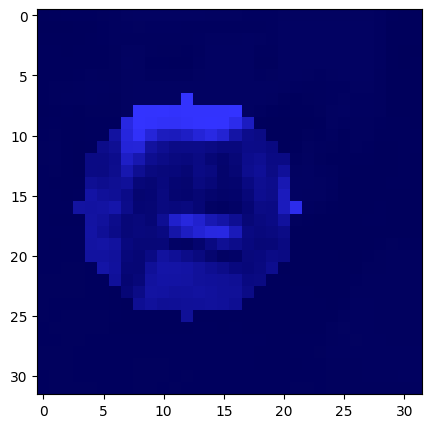

In [ ]:
# Change the weights manually

import os
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
import numpy as np
import copy


# # optimal values
#red
zeta=0.0419
kappa=0.0429
alpha=0.04988
beta=0.04964
gamma=0.0498
tauy=0.02222
ny=0.02
tauz=0.02262
nz=0.03512

#green
zeta=0.0428
kappa=0.0436
alpha=0.0481
beta=0.02026
gamma=0.02012
tauy=0.02596
ny=0.0200
tauz=0.04388
nz=0.04969

#blue
zeta=0.04876
kappa=0.04983
alpha=0.03099
beta=0.04991
gamma=0.02
tauy=0.0286
ny=0.05
tauz=0.04388
nz=0.04969


###### update the model here

old_weights_Ch1=concat.layers[7].get_weights()
old_weights_Ch2=concat.layers[8].get_weights()
old_weights_Ch3=concat.layers[9].get_weights()

print(old_weights_Ch1,old_weights_Ch2,old_weights_Ch3)

new_weights_ch1=copy.deepcopy(old_weights_Ch1)
new_weights_ch2=copy.deepcopy(old_weights_Ch2)
new_weights_ch3=copy.deepcopy(old_weights_Ch3)

# tauC
# new_weights_ch1[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))
# new_weights_ch2[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))
# new_weights_ch3[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))


# zeta
new_weights_ch1[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))


# zeta_multFac
# new_weights[2]=np.reshape((np.array([zeta_multFac_value],dtype=np.float32)),(1,1))

# kappa
new_weights_ch1[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))


# kappa_multFac
# new_weights[4]=np.reshape((np.array([kappa_multFac],dtype=np.float32)),(1,1))

# alpha
new_weights_ch1[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))

# alpha_multFac
# new_weights[6]=np.reshape((np.array([alpha_multFac],dtype=np.float32)),(1,1))

# beta
new_weights_ch1[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))


# beta_multFac
# new_weights[8]=np.reshape((np.array([beta_multFac],dtype=np.float32)),(1,1))

# gamma
new_weights_ch1[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma],dtype=np.float32)),(1,1))

 # gamma_multFac
# new_weights[10]=np.reshape((np.array([gamma_multFac],dtype=np.float32)),(1,1))

# tau_y
new_weights_ch1[weight_name_to_index["tauY"]]=np.reshape((np.array([tauy],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["tauY"]]=np.reshape((np.array([tauy],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["tauY"]]=np.reshape((np.array([tauy],dtype=np.float32)),(1,1))

# # tau_y_multFac
# new_weights[12]=np.reshape((np.array([tau_y_multFac],dtype=np.float32)),(1,1))

# # n_y
new_weights_ch1[weight_name_to_index["nY"]]=np.reshape((np.array([ny],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["nY"]]=np.reshape((np.array([ny],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["nY"]]=np.reshape((np.array([ny],dtype=np.float32)),(1,1))

# # # n_y_multFac
# new_weights[13]=np.reshape((np.array([n_y_multFac],dtype=np.float32)),(1,1))

# # tauZ
new_weights_ch1[weight_name_to_index["tauZ"]]=np.reshape((np.array([tauz],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["tauZ"]]=np.reshape((np.array([tauz],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["tauZ"]]=np.reshape((np.array([tauz],dtype=np.float32)),(1,1))

# # tauZ_multFac
# new_weights[16]=np.reshape((np.array([tau_z_multFac],dtype=np.float32)),(1,1))

# # n_z
new_weights_ch1[weight_name_to_index["nZ"]]=np.reshape((np.array([nz],dtype=np.float32)),(1,1))
new_weights_ch2[weight_name_to_index["nZ"]]=np.reshape((np.array([nz],dtype=np.float32)),(1,1))
new_weights_ch3[weight_name_to_index["nZ"]]=np.reshape((np.array([nz],dtype=np.float32)),(1,1))
# # n_z_multFac
# new_weights[18]=np.reshape((np.array([n_z_multFac],dtype=np.float32)),(1,1))

# # tauC_multFac
# new_weights[19]=np.reshape((np.array([tau_c_multFac],dtype=np.float32)),(1,1))

# # # nc
# new_weights_ch1[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))
# new_weights_ch2[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))
# new_weights_ch3[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))
# # # nc_multFac
# # new_weights[19]=np.reshape((np.array([n_c_multFac],dtype=np.float32)),(1,1))

######### update the model here
concat.layers[7].set_weights(new_weights_ch1)
concat.layers[8].set_weights(new_weights_ch2)
concat.layers[8].set_weights(new_weights_ch3)

print(new_weights_ch1)
print(new_weights_ch2)
print(new_weights_ch3)

output=concat.predict(x_test_mask_movie)

# get the output of photoreceptor
sample_index=20
frame_n=18
plt.figure(figsize=(5, 5))
# # only check the last frame
plt.imshow(normalize_image(output[sample_index,frame_n, :, :,:]))
plt.show()

### **10.1.3: RMS Calculation for Various Combinations of PR Parameters**

313/313 [==============================] - 1s 4ms/step


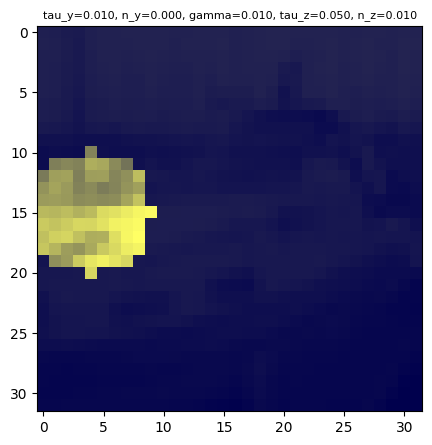

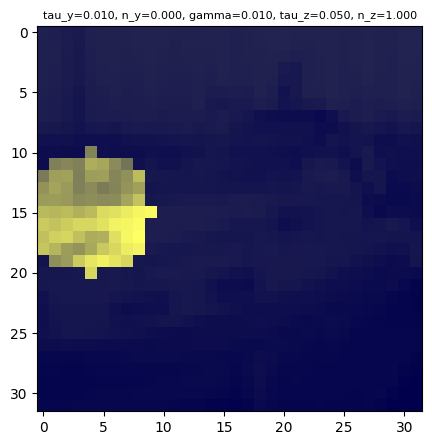

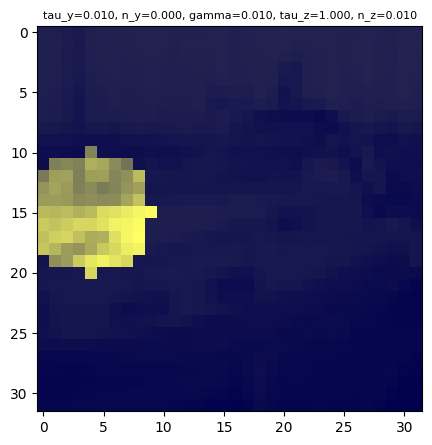

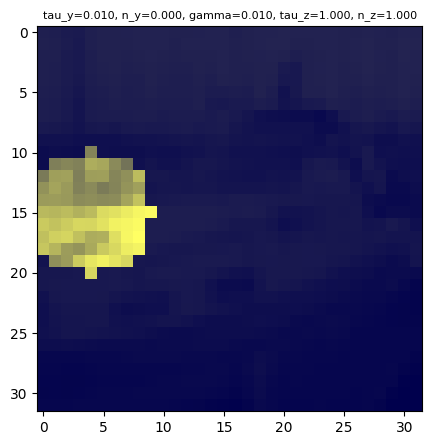

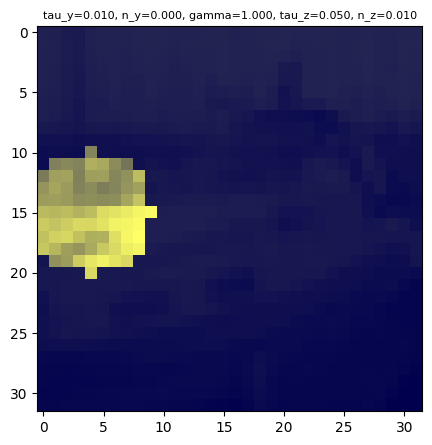

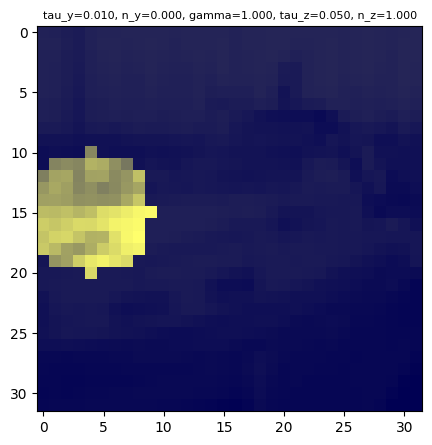

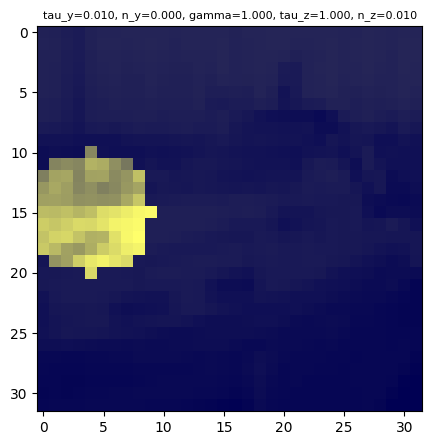

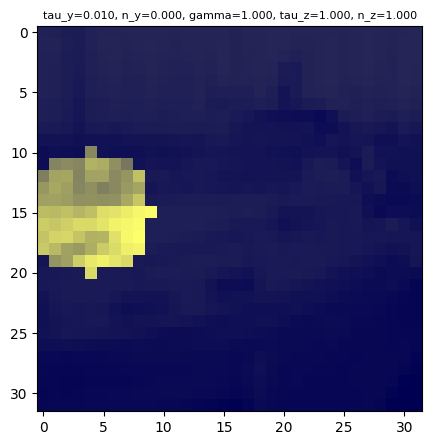

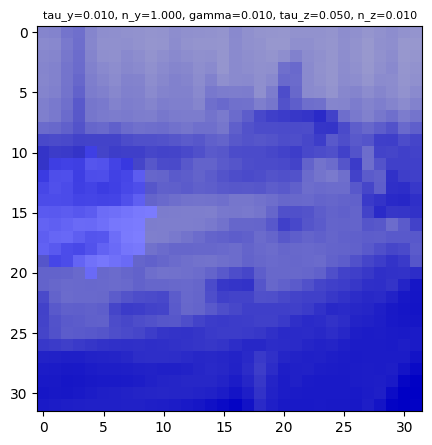

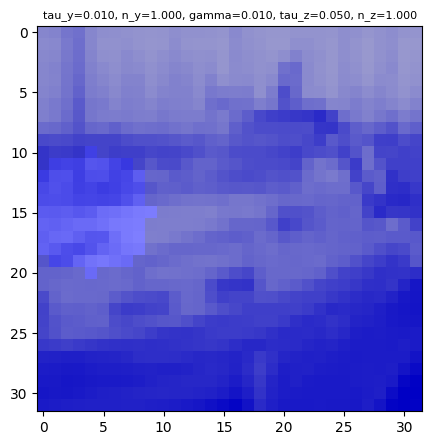

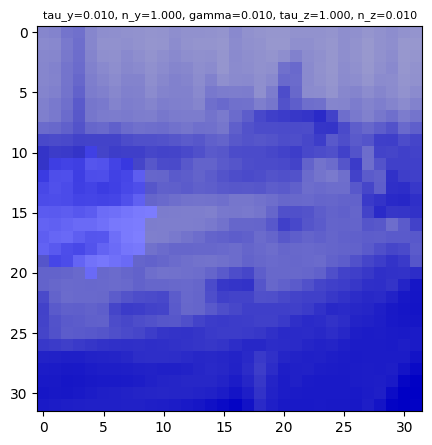

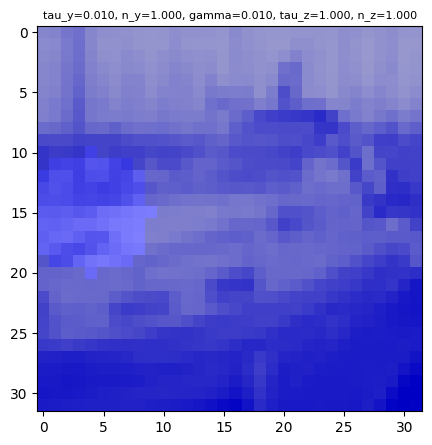

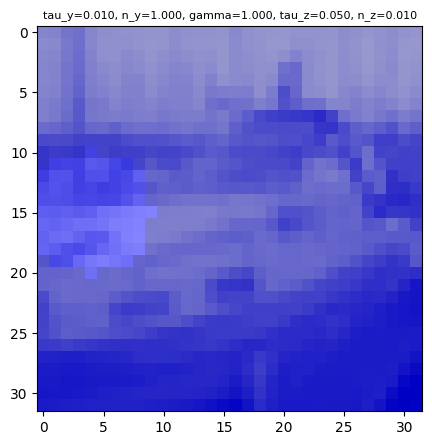

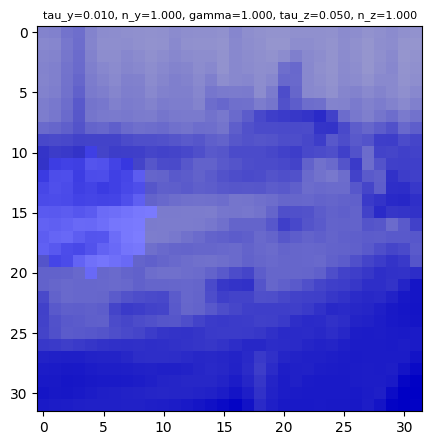

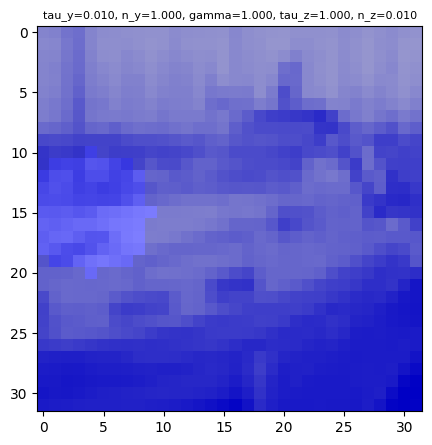

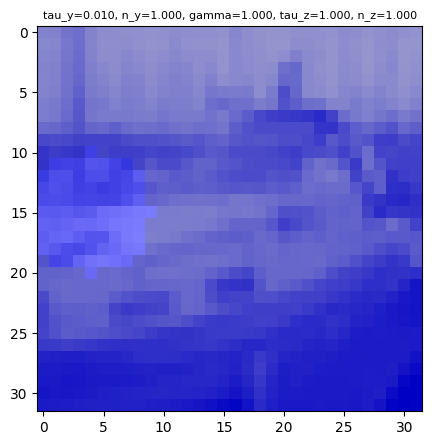

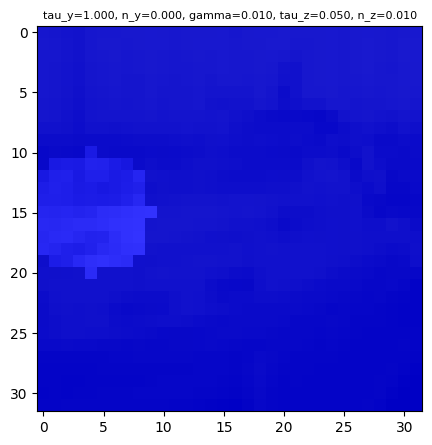

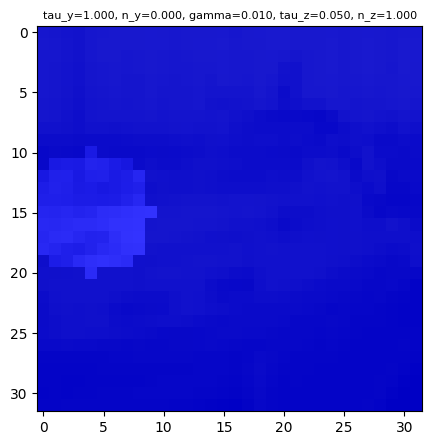

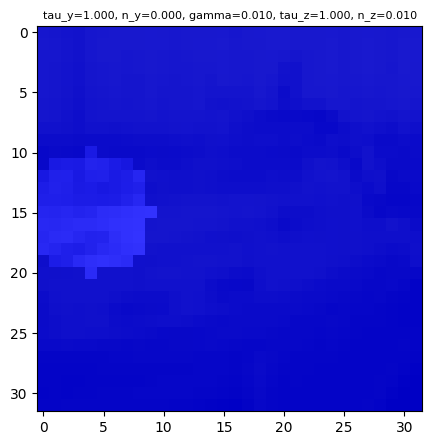

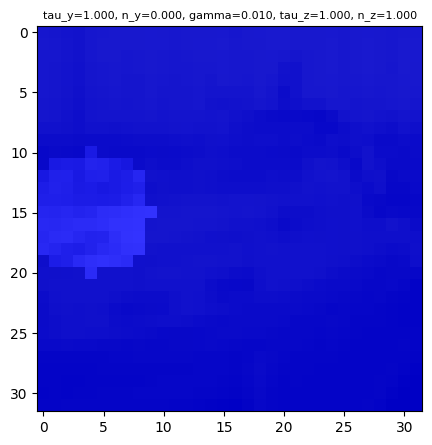

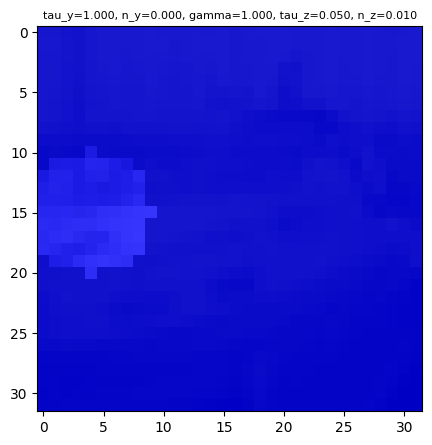

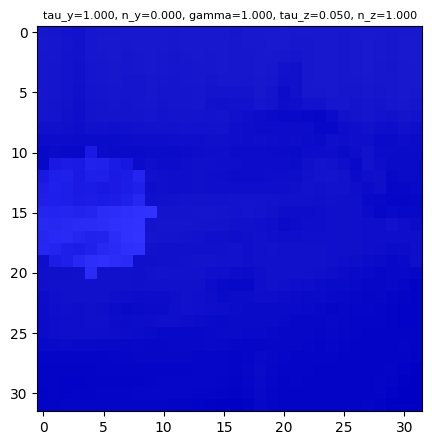

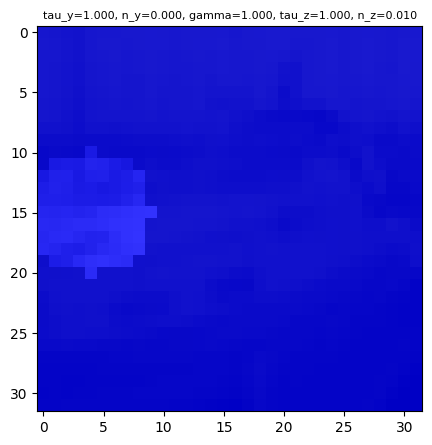

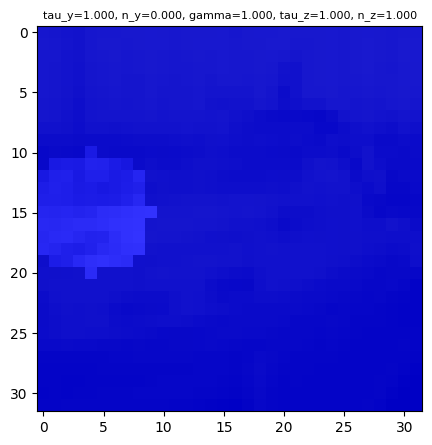

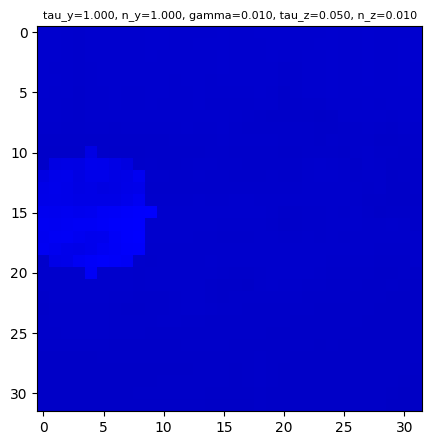

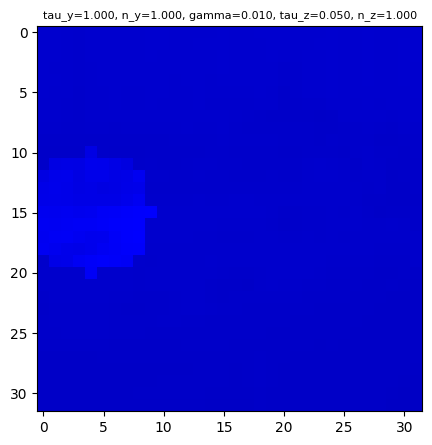

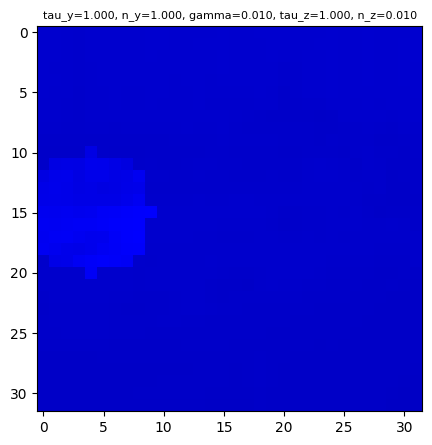

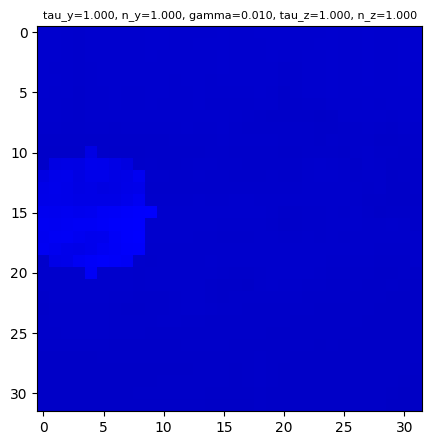

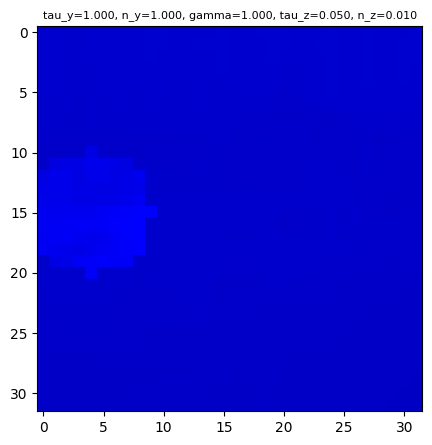

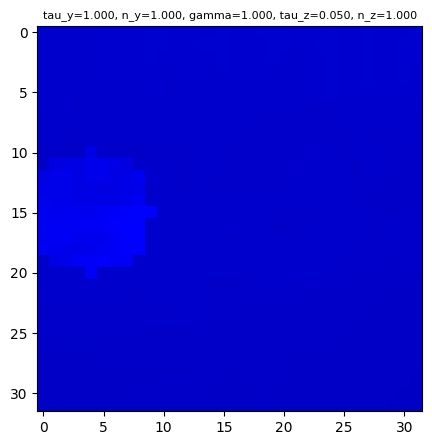

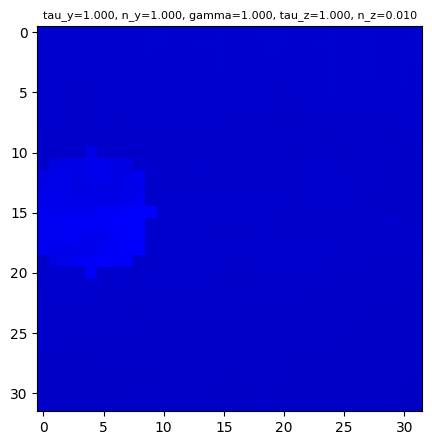

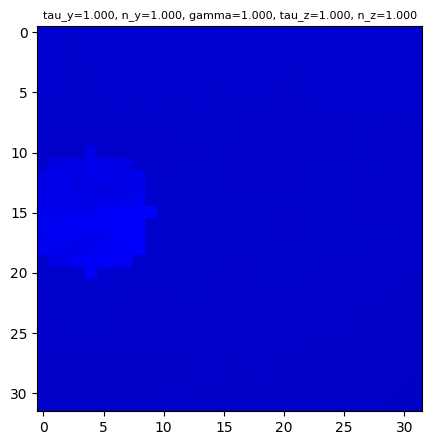

In [ ]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
import numpy as np
import copy



# First Set: ranges of PR model parameters
tauy_range= np.linspace(0.01, 1, 2)
ny_range = np.linspace(0.00001, 1, 2)
gamma_range=np.linspace(0.01, 1, 2)
tauz_range= np.linspace(0.05, 1, 2)
nz_range = np.linspace(0.01, 1, 2)

# # constant optimal values
# tauy=0.06
# gamma=0.1
# ny=0.1
# tauz=0.09
# nz=0.09
tauc=0.01
nc=0.05



# Second Set : ranges of PR model parameters
# zeta_range=np.linspace(0,0.2,4)
# kappa_range=np.linspace(0,0.2,4)
# alpha_range=np.linspace(0,0.2,4)
# beta_range=np.linspace(0,0.2,4)

# optimal valuess
zeta=0
kappa=0.005
alpha=0.1
beta=0.001

# create a matrix to store the RMS error values (5D array)
# First Set
rms_errors = np.zeros((len(tauy_range), len(ny_range), len(gamma_range), len(tauz_range), len(nz_range), x_test_mask_movie.shape[0]))
# Second Set
# rms_errors = np.zeros((len(zeta_range),len(kappa_range),len(alpha_range),len(beta_range), x_test_mask_movie_sq.shape[0]))




# Loop through the range of parameters

# First Set
for i, tau_y in enumerate(tauy_range):
    for j, n_y in enumerate(ny_range):
        for k, gamma_value in enumerate(gamma_range):
            for l, tau_z in enumerate(tauz_range):
                for m, n_z in enumerate(nz_range):

# Second Set
# for p, zeta_value in enumerate(zeta_range):
#     for q, kappa_value in enumerate(kappa_range):
#         for r, alpha_value in enumerate (alpha_range):
#             for s, beta_value in enumerate (beta_range):

###### update the weight values

                        old_weights_Ch1=concat.layers[7].get_weights()
                        old_weights_Ch2=concat.layers[8].get_weights()
                        old_weights_Ch3=concat.layers[9].get_weights()
                        new_weights_ch1=copy.deepcopy(old_weights_Ch1)
                        new_weights_ch2=copy.deepcopy(old_weights_Ch2)
                        new_weights_ch3=copy.deepcopy(old_weights_Ch3)

                        # tauC
                        # new_weights_ch1[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))
                        # new_weights_ch2[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))
                        # new_weights_ch3[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))


                        # zeta
                        new_weights_ch1[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))


                        # zeta_multFac
                        # new_weights[2]=np.reshape((np.array([zeta_multFac_value],dtype=np.float32)),(1,1))

                        # kappa
                        new_weights_ch1[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))


                        # kappa_multFac
                        # new_weights[4]=np.reshape((np.array([kappa_multFac],dtype=np.float32)),(1,1))

                        # alpha
                        new_weights_ch1[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))

                        # alpha_multFac
                        # new_weights[6]=np.reshape((np.array([alpha_multFac],dtype=np.float32)),(1,1))

                        # beta
                        new_weights_ch1[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))


                        # beta_multFac
                        # new_weights[8]=np.reshape((np.array([beta_multFac],dtype=np.float32)),(1,1))

                        # gamma
                        new_weights_ch1[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma_value],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma_value],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma_value],dtype=np.float32)),(1,1))

                        # gamma_multFac
                        # new_weights[10]=np.reshape((np.array([gamma_multFac],dtype=np.float32)),(1,1))

                        # tau_y
                        new_weights_ch1[weight_name_to_index["tauY"]]=np.reshape((np.array([tau_y],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["tauY"]]=np.reshape((np.array([tau_y],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["tauY"]]=np.reshape((np.array([tau_y],dtype=np.float32)),(1,1))

                        # # tau_y_multFac
                        # new_weights[12]=np.reshape((np.array([tau_y_multFac],dtype=np.float32)),(1,1))

                        # # n_y
                        new_weights_ch1[weight_name_to_index["nY"]]=np.reshape((np.array([n_y],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["nY"]]=np.reshape((np.array([n_y],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["nY"]]=np.reshape((np.array([n_y],dtype=np.float32)),(1,1))

                        # # # n_y_multFac
                        # new_weights[13]=np.reshape((np.array([n_y_multFac],dtype=np.float32)),(1,1))

                        # # tauZ
                        new_weights_ch1[weight_name_to_index["tauZ"]]=np.reshape((np.array([tau_z],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["tauZ"]]=np.reshape((np.array([tau_z],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["tauZ"]]=np.reshape((np.array([tau_z],dtype=np.float32)),(1,1))

                        # # tauZ_multFac
                        # new_weights[16]=np.reshape((np.array([tau_z_multFac],dtype=np.float32)),(1,1))

                        # # n_z
                        new_weights_ch1[weight_name_to_index["nZ"]]=np.reshape((np.array([n_z],dtype=np.float32)),(1,1))
                        new_weights_ch2[weight_name_to_index["nZ"]]=np.reshape((np.array([n_z],dtype=np.float32)),(1,1))
                        new_weights_ch3[weight_name_to_index["nZ"]]=np.reshape((np.array([n_z],dtype=np.float32)),(1,1))
                        # # n_z_multFac
                        # new_weights[18]=np.reshape((np.array([n_z_multFac],dtype=np.float32)),(1,1))

                        # # tauC_multFac
                        # new_weights[19]=np.reshape((np.array([tau_c_multFac],dtype=np.float32)),(1,1))

                        # # # nc
                        # new_weights_ch1[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))
                        # new_weights_ch2[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))
                        # new_weights_ch3[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))
                        # # # nc_multFac
                        # # new_weights[19]=np.reshape((np.array([n_c_multFac],dtype=np.float32)),(1,1))


                        concat.layers[7].set_weights(new_weights_ch1)
                        concat.layers[8].set_weights(new_weights_ch2)
                        concat.layers[8].set_weights(new_weights_ch3)



                        # Get the output

                        output=concat.predict(x_test_mask_movie)


                        # Visualize the output image
                        sample_index=2
                        plt.figure(figsize=(5, 5))
                        # # Check a frame with mask (frame 15-frame 20)
                        plt.imshow(normalize_image(output[sample_index,18, :, :]))
                        # First Set
                        plt.title(f"tau_y={tauy_range[i]:.3f}, n_y={ny_range[j]:.3f}, gamma={gamma_range[k]:.3f}, tau_z={tauz_range[l]:.3f}, n_z={nz_range[m]:.3f}", fontsize=8)
                        # Second Set
                        # # plt.title(f"zeta={zeta_range[p]:.3f},kappa={kappa_range[q]:.4f},alpha={alpha_range[r]:.4f},beta={beta_range[s]:.4f}", fontsize=8)

                      # Save the plots

                      #   plt.colorbar()
                      #   plt.show()
                      #   # save animation as an MP4 video file
                          # first set
                      #   filename=f"tau_y={tauy_range[i]:.3f}_n_y={ny_range[j]:.3f}_gamma={gamma_range[k]:.3f}_tau_z={tauz_range[l]:.3f}_n_z={nz_range[m]:.3f}.png"
                      #   # second set
                      #   filename=f"zeta={zeta_range[p]:.3f}_kappa={kappa_range[q]:.3f}_alpha={alpha_range[r]:.3f}_beta={beta_range[s]:.3f}.png"
                      ## Update the path
                      #   digits_path = '/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CIFAR1-_RGB_Test1'
                      # # Combine the digits_path with the filename
                      #   output_path = os.path.join(digits_path, filename)
                      #   plt.savefig(output_path, dpi=300)
                      #   plt.close()

                     #   # extract one of the input frames (unmasked image) and one of the output frames (masked image)
                        first_frame_input=x_test_mask_movie[sample_index,2, :, :,:]
                        last_frame_output = output[sample_index,18, :, :,:]



        ### Compute RMS between unmaksed and masked images

                        rms_error=compute_rms_error_per_frame(first_frame_input,last_frame_output)
                        # First Set
                        rms_errors[i, j, k, l, m,:] = rms_error
                        # Second Set
                        # rms_errors[p, q, r, s,:] = rms_error

### **10.1.4: Compute Minimum RMS Value**

In [ ]:
# Find the min RMS value for each combination
min_rms_value = np.min(rms_errors)
print(min_rms_value)
min_rms_index = np.argmin(rms_errors)
print(min_rms_index)
min_rms_multi_index = np.unravel_index(min_rms_index, rms_errors.shape)
print(min_rms_multi_index)

## first Set (TauY, Ny, Gamma, TauZ, Nz)
min_tau_y=min_rms_multi_index[0]
min_n_y=min_rms_multi_index[1]
min_gamma=min_rms_multi_index[2]
min_tau_z=min_rms_multi_index[3]
min_n_z=min_rms_multi_index[4]

min_tau_y = tauy_range[min_rms_multi_index[0]]
min_n_y = ny_range[min_rms_multi_index[1]]
min_gamma = gamma_range[min_rms_multi_index[2]]
min_tau_z = tauz_range[min_rms_multi_index[3]]
min_n_z = nz_range[min_rms_multi_index[4]]

print(f"Minimum RMS found at:")
print(f"tau_y: {min_tau_y}")
print(f"n_y: {min_n_y}")
print(f"gamma: {min_gamma}")
print(f"tau_z: {min_tau_z}")
print(f"n_z: {min_n_z}")



1.2159966941133138
200000
(1, 0, 1, 0, 0, 0)
Minimum RMS found at:
tau_y: 1.0
n_y: 1e-05
gamma: 1.0
tau_z: 0.05
n_z: 0.01


In [ ]:
# Find the min RMS value for each combination
min_rms_value = np.min(rms_errors)
print(min_rms_value)
min_rms_index = np.argmin(rms_errors)
print(min_rms_index)
min_rms_multi_index = np.unravel_index(min_rms_index, rms_errors.shape)
print(min_rms_multi_index)


## first Set (Zetta, Kappa, Alpha, Beta)

min_zeta=min_rms_multi_index[0]
min_kappa=min_rms_multi_index[1]
min_alpha=min_rms_multi_index[2]
min_beta=min_rms_multi_index[3]

min_zeta=zeta_range[min_rms_multi_index[0]]
min_kappa=kappa_range[min_rms_multi_index[1]]
min_alpha=alpha_range[min_rms_multi_index[2]]
min_beta=beta_range[min_rms_multi_index[3]]

print(f"Minimum RMS found at:")
print(f"zeta: {min_zeta}")
print(f"kappa: {min_kappa}")
print(f"alpha: {min_alpha}")
print(f"beta: {min_beta}")

## **10.2: RMS_ResNet20+PR(RGB)**

### **10.2.1: Map Weight Names to Their Indices**

In [ ]:
# Map weight names to their indices
weight_name_to_index={}

# update the layer of the PR model ( ResNet20+PR = PR_out20)
weights = PR_out20.layers[2].get_weights()
for i in range(len(weights)):
    print(f"Weight {i} name: {PR_out20.layers[2].weights[i].name}")

weight_names = []
for i, weight in enumerate(weights):
    weight_name = PR_out20.layers[2].weights[i].name
    # Get the substring after the last slash
    weight_name = weight_name.split("/")[-1]
    # Get the substring before the colon
    weight_name = weight_name.split(":")[0]
    weight_names.append(weight_name)

for i, weight_name in enumerate(weight_names):
  weight_name_to_index[weight_name]=i

Weight 0 name: photoreceptor_da_multichan_randinit_6/zeta:0
Weight 1 name: photoreceptor_da_multichan_randinit_6/kappa:0
Weight 2 name: photoreceptor_da_multichan_randinit_6/alpha:0
Weight 3 name: photoreceptor_da_multichan_randinit_6/beta:0
Weight 4 name: photoreceptor_da_multichan_randinit_6/gamma:0
Weight 5 name: photoreceptor_da_multichan_randinit_6/tauY:0
Weight 6 name: photoreceptor_da_multichan_randinit_6/nY:0
Weight 7 name: photoreceptor_da_multichan_randinit_6/tauZ:0
Weight 8 name: photoreceptor_da_multichan_randinit_6/nZ:0
Weight 9 name: photoreceptor_da_multichan_randinit_6/tauC:0
Weight 10 name: photoreceptor_da_multichan_randinit_6/zeta_mulFac:0
Weight 11 name: photoreceptor_da_multichan_randinit_6/kappa_mulFac:0
Weight 12 name: photoreceptor_da_multichan_randinit_6/alpha_mulFac:0
Weight 13 name: photoreceptor_da_multichan_randinit_6/beta_mulFac:0
Weight 14 name: photoreceptor_da_multichan_randinit_6/gamma_mulFac:0
Weight 15 name: photoreceptor_da_multichan_randinit_6/tauY

### **10.2.2: Output of PR Model for a Specific Parameter Set**

[array([[0.02]], dtype=float32), array([[0.02]], dtype=float32), array([[0.05]], dtype=float32), array([[0.05]], dtype=float32), array([[0.01]], dtype=float32), array([[0.03]], dtype=float32), array([[1.e-05]], dtype=float32), array([[0.05]], dtype=float32), array([[0.06]], dtype=float32), array([[0.02]], dtype=float32), array([[1000.]], dtype=float32), array([[1000.]], dtype=float32), array([[100.]], dtype=float32), array([[10.]], dtype=float32), array([[10.]], dtype=float32), array([[100.]], dtype=float32), array([[10.]], dtype=float32), array([[100.]], dtype=float32), array([[10.]], dtype=float32), array([[100.]], dtype=float32), array([[0.17702909]], dtype=float32), array([[10.]], dtype=float32)]
[array([[0.02]], dtype=float32), array([[0.02]], dtype=float32), array([[0.05]], dtype=float32), array([[0.05]], dtype=float32), array([[0.02]], dtype=float32), array([[0.0499]], dtype=float32), array([[0.03732]], dtype=float32), array([[0.02]], dtype=float32), array([[0.03944]], dtype=flo

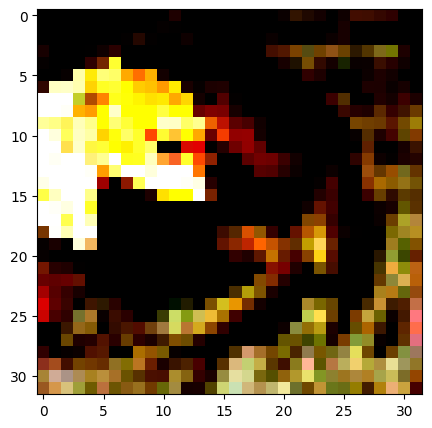

In [ ]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
import numpy as np
import copy


# optimal valuess

tauy=0.0499
gamma=0.02
ny=0.03732
tauz=0.02
nz=0.03944
# tauc=6
# nc=0.05
zeta=0.02
kappa=0.02
alpha=0.05
beta=0.05

# Get the weights values
old_weights=PR_out_norm20.layers[2].get_weights()
new_weights=copy.deepcopy(old_weights)
print(old_weights)


# tauC
#new_weights[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))

# zeta
new_weights[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))

# zeta_multFac
# new_weights[2]=np.reshape((np.array([zeta_multFac_value],dtype=np.float32)),(1,1))

# kappa
new_weights[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))

# kappa_multFac
# new_weights[4]=np.reshape((np.array([kappa_multFac],dtype=np.float32)),(1,1))

# alpha
new_weights[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))

# alpha_multFac
# new_weights[6]=np.reshape((np.array([alpha_multFac],dtype=np.float32)),(1,1))

# beta
new_weights[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))

# beta_multFac
# new_weights[8]=np.reshape((np.array([beta_multFac],dtype=np.float32)),(1,1))

# gamma
new_weights[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma],dtype=np.float32)),(1,1))

# gamma_multFac
# new_weights[10]=np.reshape((np.array([gamma_multFac],dtype=np.float32)),(1,1))

# tau_y
new_weights[weight_name_to_index["tauY"]]=np.reshape((np.array([tauy],dtype=np.float32)),(1,1))

# # tau_y_multFac
# new_weights[12]=np.reshape((np.array([tau_y_multFac],dtype=np.float32)),(1,1))

# # n_y
new_weights[weight_name_to_index["nY"]]=np.reshape((np.array([ny],dtype=np.float32)),(1,1))

# # # n_y_multFac
# new_weights[13]=np.reshape((np.array([n_y_multFac],dtype=np.float32)),(1,1))

# # tauZ
new_weights[weight_name_to_index["tauZ"]]=np.reshape((np.array([tauz],dtype=np.float32)),(1,1))

# # tauZ_multFac
# new_weights[16]=np.reshape((np.array([tau_z_multFac],dtype=np.float32)),(1,1))

# # n_z
new_weights[weight_name_to_index["nZ"]]=np.reshape((np.array([nz],dtype=np.float32)),(1,1))

# # n_z_multFac
# new_weights[18]=np.reshape((np.array([n_z_multFac],dtype=np.float32)),(1,1))

# # tauC_multFac
# new_weights[19]=np.reshape((np.array([tau_c_multFac],dtype=np.float32)),(1,1))

# # nc
#new_weights[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))

# # nc_multFac

# new_weights[19]=np.reshape((np.array([n_c_multFac],dtype=np.float32)),(1,1))

######### update the model here
PR_out_norm20.layers[2].set_weights(new_weights)
new_weight_values=PR_out_norm20.layers[2].get_weights()
print(new_weights)
print(new_weight_values)
output=PR_out_norm20.predict(x_test_mask_movie)



# get the output of photoreceptor for a frame with mask
sample_index=300
plt.figure(figsize=(5, 5))
plt.imshow((output[sample_index,18,:,:]))

### **10.2.3: RMS Calculation for Various Combinations of PR Parameters**

In [ ]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
import numpy as np
import copy



# First Set: ranges of PR model parameters
tauy_range= np.linspace(0.03, 0.1, 3)
ny_range = np.linspace(0.00001, 0.1, 3)
gamma_range=np.linspace(0.01, 0.1, 3)
tauz_range= np.linspace(0.05,0.1, 3)
nz_range = np.linspace(0.06, 0.1, 3)



# Second Set: ranges of PR model parameters
# zeta_range=np.linspace(0,0.2,4)
# kappa_range=np.linspace(0,0.2,4)
# alpha_range=np.linspace(0,0.2,4)
# beta_range=np.linspace(0,0.2,4)

# optimal valuess
zeta=0.02
kappa=0.02
alpha=0.05
beta=0.05




# create a matrix to store the RMS error (5D array)
# First Set
rms_errors = np.zeros((len(tauy_range), len(ny_range), len(gamma_range), len(tauz_range), len(nz_range), x_test_mask_movie.shape[0]))
# Second Set
#rms_errors = np.zeros((len(zeta_range),len(kappa_range),len(alpha_range),len(beta_range), x_test_mask_movie.shape[0]))




# Loop through the range of parameters


for i, tau_y in enumerate(tauy_range):
    for j, n_y in enumerate(ny_range):
        for k, gamma_value in enumerate(gamma_range):
            for l, tau_z in enumerate(tauz_range):
                for m, n_z in enumerate(nz_range):

# for p, zeta_value in enumerate(zeta_range):
#     for q, kappa_value in enumerate(kappa_range):
#         for r, alpha_value in enumerate (alpha_range):
#             for s, beta_value in enumerate (beta_range):

###### update the model here

                        old_weights=PR_out_norm20.layers[2].get_weights()
                        new_weights=copy.deepcopy(old_weights)

                        # tauC
                        #new_weights[weight_name_to_index["tauC"]]=np.reshape((np.array([tauc],dtype=np.float32)),(1,1))

                        # zeta
                        new_weights[weight_name_to_index["zeta"]]=np.reshape((np.array([zeta],dtype=np.float32)),(1,1))

                      # zeta_multFac
                        # new_weights[2]=np.reshape((np.array([zeta_multFac_value],dtype=np.float32)),(1,1))

                      # kappa
                        new_weights[weight_name_to_index["kappa"]]=np.reshape((np.array([kappa],dtype=np.float32)),(1,1))

                      # kappa_multFac
                        # new_weights[4]=np.reshape((np.array([kappa_multFac],dtype=np.float32)),(1,1))

                      # alpha
                        new_weights[weight_name_to_index["alpha"]]=np.reshape((np.array([alpha],dtype=np.float32)),(1,1))

                        # alpha_multFac
                      # new_weights[6]=np.reshape((np.array([alpha_multFac],dtype=np.float32)),(1,1))

                      # beta
                        new_weights[weight_name_to_index["beta"]]=np.reshape((np.array([beta],dtype=np.float32)),(1,1))

                    # beta_multFac
                      # new_weights[8]=np.reshape((np.array([beta_multFac],dtype=np.float32)),(1,1))

                      # gamma
                        new_weights[weight_name_to_index["gamma"]]=np.reshape((np.array([gamma_value],dtype=np.float32)),(1,1))

                  # gamma_multFac
                    # new_weights[10]=np.reshape((np.array([gamma_multFac],dtype=np.float32)),(1,1))

                      # tau_y
                        new_weights[weight_name_to_index["tauY"]]=np.reshape((np.array([tau_y],dtype=np.float32)),(1,1))

                  # # tau_y_multFac
                      # new_weights[12]=np.reshape((np.array([tau_y_multFac],dtype=np.float32)),(1,1))

                      # # n_y
                        new_weights[weight_name_to_index["nY"]]=np.reshape((np.array([n_y],dtype=np.float32)),(1,1))

                        # # # n_y_multFac
                      # new_weights[13]=np.reshape((np.array([n_y_multFac],dtype=np.float32)),(1,1))

                      # # tauZ
                        new_weights[weight_name_to_index["tauZ"]]=np.reshape((np.array([tau_z],dtype=np.float32)),(1,1))

                      # # tauZ_multFac
                        # new_weights[16]=np.reshape((np.array([tau_z_multFac],dtype=np.float32)),(1,1))

                        # # n_z
                        new_weights[weight_name_to_index["nZ"]]=np.reshape((np.array([n_z],dtype=np.float32)),(1,1))

                      # # n_z_multFac
                      # new_weights[18]=np.reshape((np.array([n_z_multFac],dtype=np.float32)),(1,1))

                        # # tauC_multFac
                      # new_weights[19]=np.reshape((np.array([tau_c_multFac],dtype=np.float32)),(1,1))

                      # # nc
                        #new_weights[weight_name_to_index["nC"]]=np.reshape((np.array([nc],dtype=np.float32)),(1,1))

                        # # nc_multFac
                      # new_weights[19]=np.reshape((np.array([n_c_multFac],dtype=np.float32)),(1,1))

    ######### update the model here
                        PR_out_norm20.layers[2].set_weights(new_weights)

                        output=PR_out_norm20.predict(x_test_mask_movie)



                        # get the output of photoreceptor
                        #sample_index=200
                        #plt.figure(figsize=(5, 5))
                        # # only check the last frame
                        #plt.imshow((output[sample_index,18, :, :]))
                        #plt.title(f"tau_y={tauy_range[i]:.3f}, n_y={ny_range[j]:.3f}, gamma={gamma_range[k]:.3f}, tau_z={tauz_range[l]:.3f}, n_z={nz_range[m]:.3f}", fontsize=8)
                        # # # plt.title(f"zeta={zeta_range[p]:.3f},kappa={kappa_range[q]:.4f},alpha={alpha_range[r]:.4f},beta={beta_range[s]:.4f}", fontsize=8)

                      #   plt.colorbar()
                      #   plt.show()
                      #   # save animation as an MP4 video file
                      #   filename=f"tau_y={tauy_range[i]:.3f}_n_y={ny_range[j]:.3f}_gamma={gamma_range[k]:.3f}_tau_z={tauz_range[l]:.3f}_n_z={nz_range[m]:.3f}.png"
                      #   # filename=f"zeta={zeta_range[p]:.3f}_kappa={kappa_range[q]:.3f}_alpha={alpha_range[r]:.3f}_beta={beta_range[s]:.3f}.png"
                      #   digits_path = '/content/drive/MyDrive/PhD-Nilou/Project#3_DynamicCoding/Nilou_Codes/CIFAR1-_RGB_Test1'
                      # # Combine the digits_path with the filename
                      #   output_path = os.path.join(digits_path, filename)
                      #   plt.savefig(output_path, dpi=300)
                      #   plt.close()

                      #   # extract first frame of the input (unmasked image) and last frame of the output (masked image)
                        first_frame_input=x_test_mask_movie[sample_index,2, :, :,:]
                        last_frame_output = output[sample_index,18, :, :,:]



        ### Compute RMS
                        rms_error=compute_rms_error_per_frame(first_frame_input,last_frame_output)
                        rms_errors[i, j, k, l, m,:] = rms_error
                         #rms_errors[p, q, r, s,:] = rms_error

313/313 [==============================] - 1s 3ms/step


ResourceExhaustedError: ignored

### **10.2.4: Compute Minimum RMS Value**

In [ ]:
# Find the min RMS value for each combination
min_rms_value = np.min(rms_errors)
print(min_rms_value)
min_rms_index = np.argmin(rms_errors)
print(min_rms_index)
min_rms_multi_index = np.unravel_index(min_rms_index, rms_errors.shape)
print(min_rms_multi_index)

## first part

min_tau_y=min_rms_multi_index[0]
min_n_y=min_rms_multi_index[1]
min_gamma=min_rms_multi_index[2]
min_tau_z=min_rms_multi_index[3]
min_n_z=min_rms_multi_index[4]


# min_tau_y = tauy_range[min_rms_multi_index[0]]
# min_n_y = ny_range[min_rms_multi_index[1]]
# min_gamma = gamma_range[min_rms_multi_index[2]]
# min_tau_z = tauz_range[min_rms_multi_index[3]]
# min_n_z = nz_range[min_rms_multi_index[4]]

# print(f"Minimum RMS found at:")
# print(f"tau_y: {min_tau_y}")
# print(f"n_y: {min_n_y}")
# print(f"gamma: {min_gamma}")
# print(f"tau_z: {min_tau_z}")
# print(f"n_z: {min_n_z}")


0.0
420000
(0, 1, 1, 2, 0, 0)
Minimum RMS found at:
tau_y: 0.03
n_y: 0.05000500000000001
gamma: 0.05500000000000001
tau_z: 0.1
n_z: 0.06


In [ ]:
## second part

# min_zeta=min_rms_multi_index[0]
# min_kappa=min_rms_multi_index[1]
# min_alpha=min_rms_multi_index[2]
# min_beta=min_rms_multi_index[3]

# min_zeta=zeta_range[min_rms_multi_index[0]]
# min_kappa=kappa_range[min_rms_multi_index[1]]
# min_alpha=alpha_range[min_rms_multi_index[2]]
# min_beta=beta_range[min_rms_multi_index[3]]

# print(f"Minimum RMS found at:")
# print(f"zeta: {min_zeta}")
# print(f"kappa: {min_kappa}")
# print(f"alpha: {min_alpha}")
# print(f"beta: {min_beta}")

# **11: Future Work**

## **11.1: VGG-16 Model**

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, LSTM

# frame_num = 20
# input_shape = (32, 32, 3)
# movie_input_shape = (frame_num, 32, 32, 3)
# num_classes = 10



# # Load the VGG16 base model
# vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# # input layer ( movie)
# input_layer = Input(shape=movie_input_shape)

# # ResNet50 base model with TimeDistributed layer
# resnet_td = TimeDistributed(vgg16_base)(input_layer)
# y2 = TimeDistributed(Flatten())(resnet_td)
# y2 = keras.layers.Dropout(0.5)(y2)
# y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

# model2 = Model(inputs=input_layer, outputs=y2)

In [ ]:
# one label per frame
# n = 5
# model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n,
#                       validation_data=validation_generator, validation_steps=validation_steps,
#                       verbose=1)

In [ ]:
# one label per frame
# n = 5
# model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# history2 = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=n,
#                       validation_data=validation_generator, validation_steps=validation_steps,
#                       verbose=1)

In [ ]:
# # convert to one-hot encoded
# # y_test=np.argmax(y_test,axis=1)



# # import matplotlib.pyplot as plt
# frame_num=20
# num_movies_all_correct=np.zeros(20)
# frame_accs=np.zeros(20)
# mismatched_movies=[]

# # Loop through each movie in the test set
# for movie_idx, movie_data in enumerate(x_test_mask_movie):

#     # labels
#     movie_labels = (y_test[movie_idx])
#     movie_labels = np.repeat(movie_labels, frame_num, axis=0)
#     # label tensor and frames tensor
#     movie_labels = movie_labels.reshape(frame_num, -1)

#     # Predict the labels for each frame in the movieslack
#     predicted_labels = model2.predict(movie_data.reshape(1, 20, 32, 32, 3))

#     # Calculate the accuracy for each frame in the movie
#     mismatch_found = False
#     for frame_idx in range(20):
#         frame_acc = (np.argmax(predicted_labels[0][frame_idx]) == (movie_labels[frame_idx]))
#         frame_accs[frame_idx] += (frame_acc)


#         # Repeat the label for each frame in the movie
#         label = movie_labels[frame_idx]

#         print(f"Movie {movie_idx+1}, Frame {frame_idx+1} Accuracy: {(frame_acc)},predicted_label:{np.argmax(predicted_labels[0][frame_idx])}, actual label:{(movie_labels[frame_idx])}")

#     all_correct = all(np.argmax(predicted_labels[0][i]) == (movie_labels[i]) for i in range(1, 20))
#     if all_correct:
#         num_movies_all_correct += 1

# # Print the number of movies where all frames match the labels
# print(f"Number of movies where all frames match the labels: {num_movies_all_correct[0]}")

# # Divide by the number of movies to get the mean accuracy for each frame
# frame_accs /= len(x_test_mask_movie)

## **11.2: EffficientNet**




In [ ]:
# import tensorflow.keras.applications as ap
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, LSTM

# frame_num = 20
# input_shape = (32, 32, 3)
# movie_input_shape = (frame_num, 32, 32, 3)
# num_classes = 10



# # Load the VGG16 base model
# EfficientNet_base = ap.EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=input_shape)

# # input layer ( movie)
# input_layer = Input(shape=movie_input_shape)

# # ResNet50 base model with TimeDistributed layer
# resnet_td = TimeDistributed(EfficientNet_base)(input_layer)
# y2 = TimeDistributed(Flatten())(resnet_td)
# y2 = keras.layers.Dropout(0.5)(y2)
# y2 = keras.layers.Dense(num_classes, activation='softmax')(y2)

# model3 = Model(inputs=input_layer, outputs=y2)

In [ ]:
# from keras.utils.vis_utils import plot_model
# model=EfficientNet_base
# plot_model(EfficientNet_base,to_file='Model3.png')

In [ ]:
# # Choose a movie index to plot its frames
# movie_idx =3000

# # Get the data and labels for the chosen movie
# movie_data = x_test_mask_movie[movie_idx]
# movie_labels = y_test[movie_idx]

# # Repeat the labels for each frame in the movie ( the first frame is eliminated )
# frame_num = 20
# movie_labels = np.repeat(movie_labels, frame_num, axis=0)
# movie_labels = movie_labels.reshape(frame_num, -1)

# # Predict the labels for each frame in the movieslack
# predicted_labels = model1.predict(movie_data.reshape(1, 20, 32, 32,3))




# fig, axs = plt.subplots(1, num_frames, figsize=(100, 30), subplot_kw={'aspect': 'equal'})
# # loop through the frames and display each one separately
# for i in range(num_frames):
#     digit = movie_data[i, :, :]
#     digit_label = np.argmax(predicted_labels[0][i])
#     axs[i].imshow(digit)
#     axs[i].set_title(f"Movie {movie_idx+1}, Frame {i+1}, Digit Label: {digit_label}")
#     axs[i].axis('off')



# plt.show()

In [ ]:
# ### Input
# # the index of the sample you want to display
# sample_index = 9991
# # the number of frames in each image
# num_frames = 20

# fig, axs = plt.subplots(1, num_frames, figsize=(50, 30), subplot_kw={'aspect': 'equal'})

# # loop through the frames and display each one separately
# for i in range(num_frames):
#     axs[i].imshow(x_test_mask_movie[sample_index, i, :, :])
#     axs[i].set_title(f"Movie {sample_index + 1}, Frame {i + 1}")
#     axs[i].axis('off')

# plt.show()